# Auxilary Classifier GAN (ACGAN)

Referecnce : https://github.com/eriklindernoren/PyTorch-GAN

In [1]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Use MNIST Dataset & DataLoader

In [3]:
bs =128

dataset = datasets.MNIST("./mnist", train=True, download=True, 
                         transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True)

torch.Size([128, 1, 32, 32]) tensor([8, 2, 1, 5, 0, 8, 3, 7, 7, 9, 9, 8, 1, 6, 7, 2, 6, 7, 6, 1, 9, 4, 1, 1,
        3, 1, 4, 9, 8, 2, 5, 0, 8, 0, 8, 7, 3, 5, 6, 2, 6, 6, 8, 7, 4, 1, 5, 3,
        0, 4, 6, 1, 6, 3, 6, 2, 5, 6, 6, 0, 8, 4, 6, 3, 1, 5, 9, 2, 1, 9, 7, 0,
        1, 7, 2, 2, 8, 7, 5, 0, 2, 6, 1, 7, 3, 1, 0, 3, 0, 6, 1, 9, 5, 7, 3, 1,
        4, 5, 9, 2, 3, 0, 8, 9, 9, 7, 6, 0, 2, 6, 9, 6, 5, 8, 5, 1, 8, 7, 9, 6,
        1, 6, 9, 2, 0, 8, 6, 4])


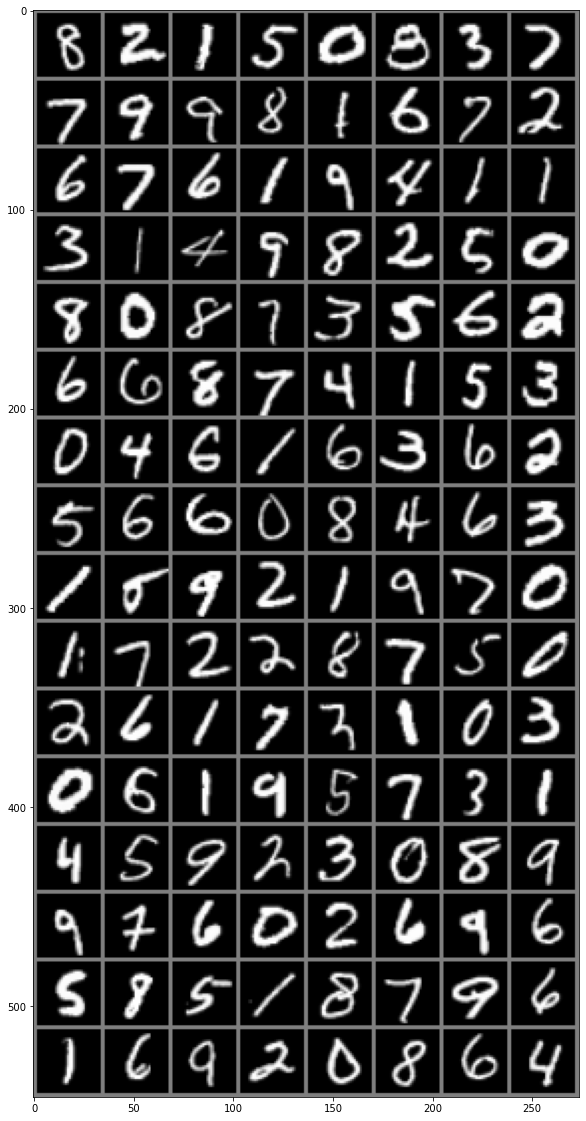

In [4]:
batch = next(iter(dataloader))
len(batch)
print(batch[0].shape, batch[1])

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(batch[0]))

## Define Generator & Discriminator
### Generator architecture
input random vector: 100 dim
* Embedding: embeding labels to 100 dim
* Linear: out_features 128 * 8 * 8
* BatchNorm2d
* Upsample: scale_factor 2
* Conv2d: out_channel: 128, kernel size 3, stride 1, padding 1
* BatchNorm2d
* LeakyReLU: 0.2
* Upsample: scale_factor 2
* Conv2d: out_channel: 64, kernel size 3, stride 1, padding 1
* BatchNorm
* LeakyReLU: 0.2
* Conv2d: out_channel: 1, kernel size 3, stride 1, padding 1
* Tanh

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        
        self.emb = nn.Embedding(10, 100) 
        self.fc1 = nn.Linear(100, 128*8*8)
        self.bn1 = nn.BatchNorm2d(128)
        self.up = nn.Upsample(scale_factor=2)
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, 3, 1, 1)
        self.last_act = nn.Tanh()
        
    def forward(self, z, labels):
        #### Implement Here ####
        ## noise, labels -> noise: 100, label: 1 dim -> 100 dim 
        ## noise * label
        z = torch.mul(self.emb(labels), z) # 100
        z = self.fc1(z)
        img = z.view(-1, 128, 8, 8)
        img = self.bn1(img)
        img = self.act(self.bn2(self.conv1(self.up(img))))
        img = self.act(self.bn3(self.conv2(self.up(img))))
        img = self.last_act(self.conv3(img))
        
        return img

### Discriminator architecture
input: [1 , 32 , 32] image  
* Conv2d: out_channel: 16, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* Conv2d: out_channel: 32, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 64, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* Conv2d: out_channel: 128, kernel size 3, stride 2, padding 1
* LeakyReLU: 0.2
* Dropout: 0.25
* BatchNorm2d
* two linear layers: one for adversarial loss, one for classification
- Linear(Val) : output 1, activation : sigmoid
- Linear(classification) : output 10, no activation

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #### Implement Here ####
        self.block1 = self.make_block(1, 16, False)
        self.block2 = self.make_block(16, 32)
        self.block3 = self.make_block(32, 64)
        self.block4 = self.make_block(64, 128)
        self.val_fc = nn.Linear(512, 1)
        self.val_act = nn.Sigmoid()
        self.cl_fc = nn.Linear(128*2*2, 10)
        
        
    def make_block(self, in_channel, out_channel, bn= True):
        #### Implement Here ####
        layers = [
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        ]
        if bn:
            layers.append(nn.BatchNorm2d(out_channel))
        
        return nn.Sequential(*layers) 
        
        
    def forward(self, img):
        ## fill here
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        x = img.view(img.shape[0], -1)
        validity = self.val_act(self.val_fc(x)) # 0, 1
        label = self.cl_fc(x) # 0 - 9
        
        return validity, label

In [7]:
G = Generator()

input_sample = torch.randn(10,100)
labels = torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).long()
output = G(input_sample, labels)
output.shape

torch.Size([10, 1, 32, 32])

In [8]:
D = Discriminator()
validity, pred_label = D(output)
print(validity.shape)
print(pred_label.shape)

torch.Size([10, 1])
torch.Size([10, 10])


## Weight Initialization

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1: # Conv2d layer weights init
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1: # BatchNorm2d layer weights init
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# weight initialize
G.apply(weights_init_normal)
D.apply(weights_init_normal)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## Define loss & Optimizer & model

In [10]:
# Loss function
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

## optimizer fill here
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.00002, betas=(0.5, 0.9999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.00002, betas=(0.5, 0.9999))

## Start Training

In [11]:
G, D = G.to(device), D.to(device)
os.makedirs("./acgan_images", exist_ok=True)
epochs = 200

In [12]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.Tensor(np.random.normal(0, 1, (n_row ** 2, 100))).to(device)
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.LongTensor(labels).to(device)
    gen_imgs = G(z, labels)
    save_image(gen_imgs, "acgan_images/%06d.png" % batches_done, nrow=n_row, normalize=True)
    imshow(torchvision.utils.make_grid(gen_imgs.cpu(), nrow=n_row))

[Epoch 0/200] [Batch 0/468] [D loss: 1.616997, acc: 7%] [G loss: 1.586358]


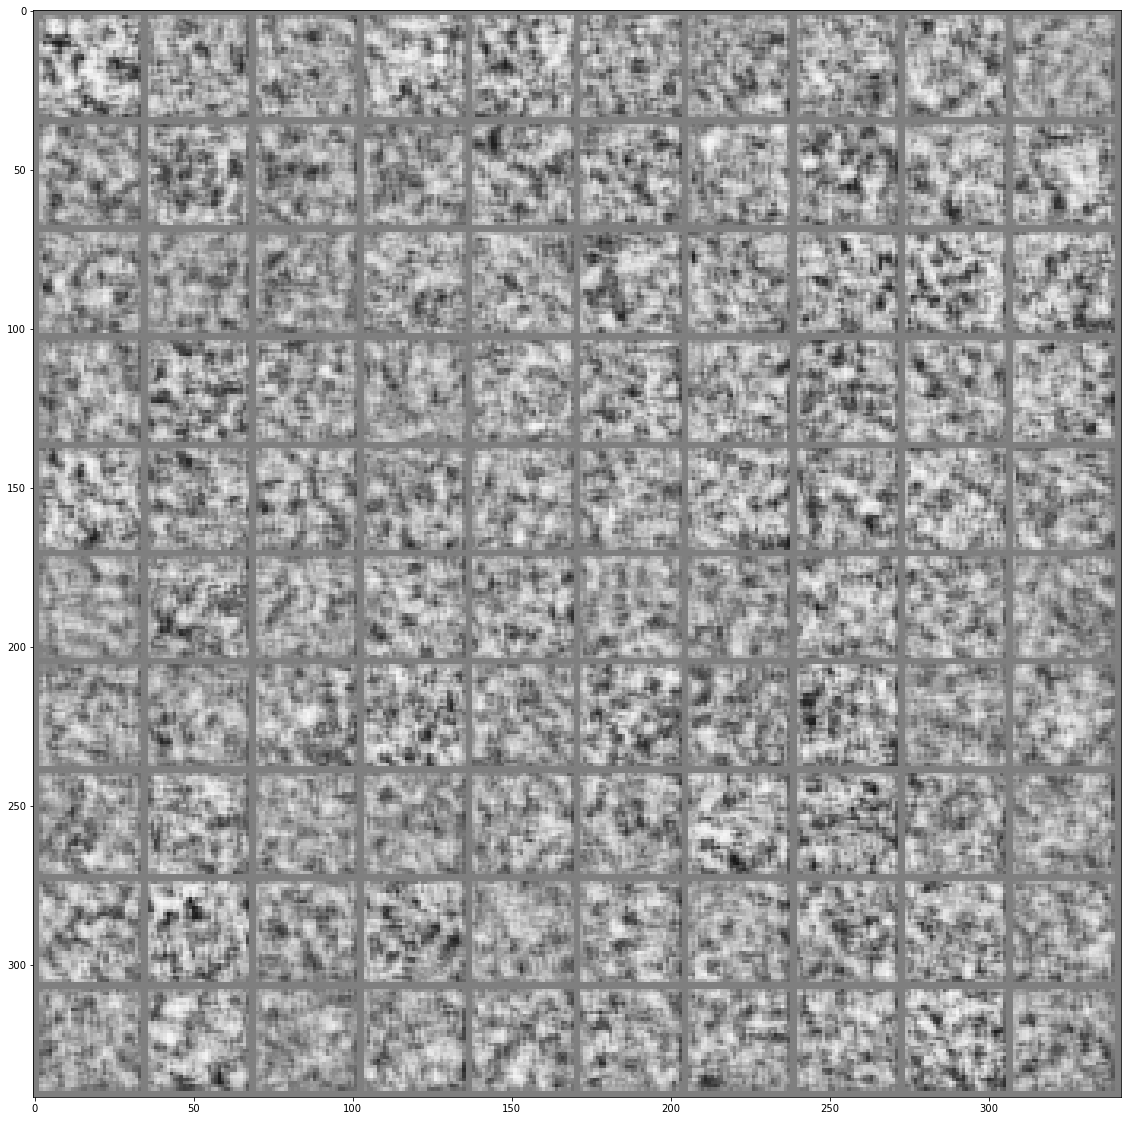

[Epoch 0/200] [Batch 100/468] [D loss: 1.558483, acc: 10%] [G loss: 1.608671]
[Epoch 0/200] [Batch 200/468] [D loss: 1.507372, acc: 11%] [G loss: 1.506189]
[Epoch 0/200] [Batch 300/468] [D loss: 1.489597, acc: 14%] [G loss: 1.532181]
[Epoch 0/200] [Batch 400/468] [D loss: 1.431728, acc: 20%] [G loss: 1.588501]
[Epoch 1/200] [Batch 32/468] [D loss: 1.368345, acc: 31%] [G loss: 1.469348]
[Epoch 1/200] [Batch 132/468] [D loss: 1.241039, acc: 39%] [G loss: 1.330842]
[Epoch 1/200] [Batch 232/468] [D loss: 1.075318, acc: 57%] [G loss: 1.159070]
[Epoch 1/200] [Batch 332/468] [D loss: 0.960608, acc: 61%] [G loss: 0.977091]
[Epoch 1/200] [Batch 432/468] [D loss: 0.824050, acc: 75%] [G loss: 0.881419]
[Epoch 2/200] [Batch 64/468] [D loss: 0.742485, acc: 77%] [G loss: 0.774727]
[Epoch 2/200] [Batch 164/468] [D loss: 0.657762, acc: 83%] [G loss: 0.673186]
[Epoch 2/200] [Batch 264/468] [D loss: 0.641892, acc: 81%] [G loss: 0.670221]
[Epoch 2/200] [Batch 364/468] [D loss: 0.617016, acc: 85%] [G loss

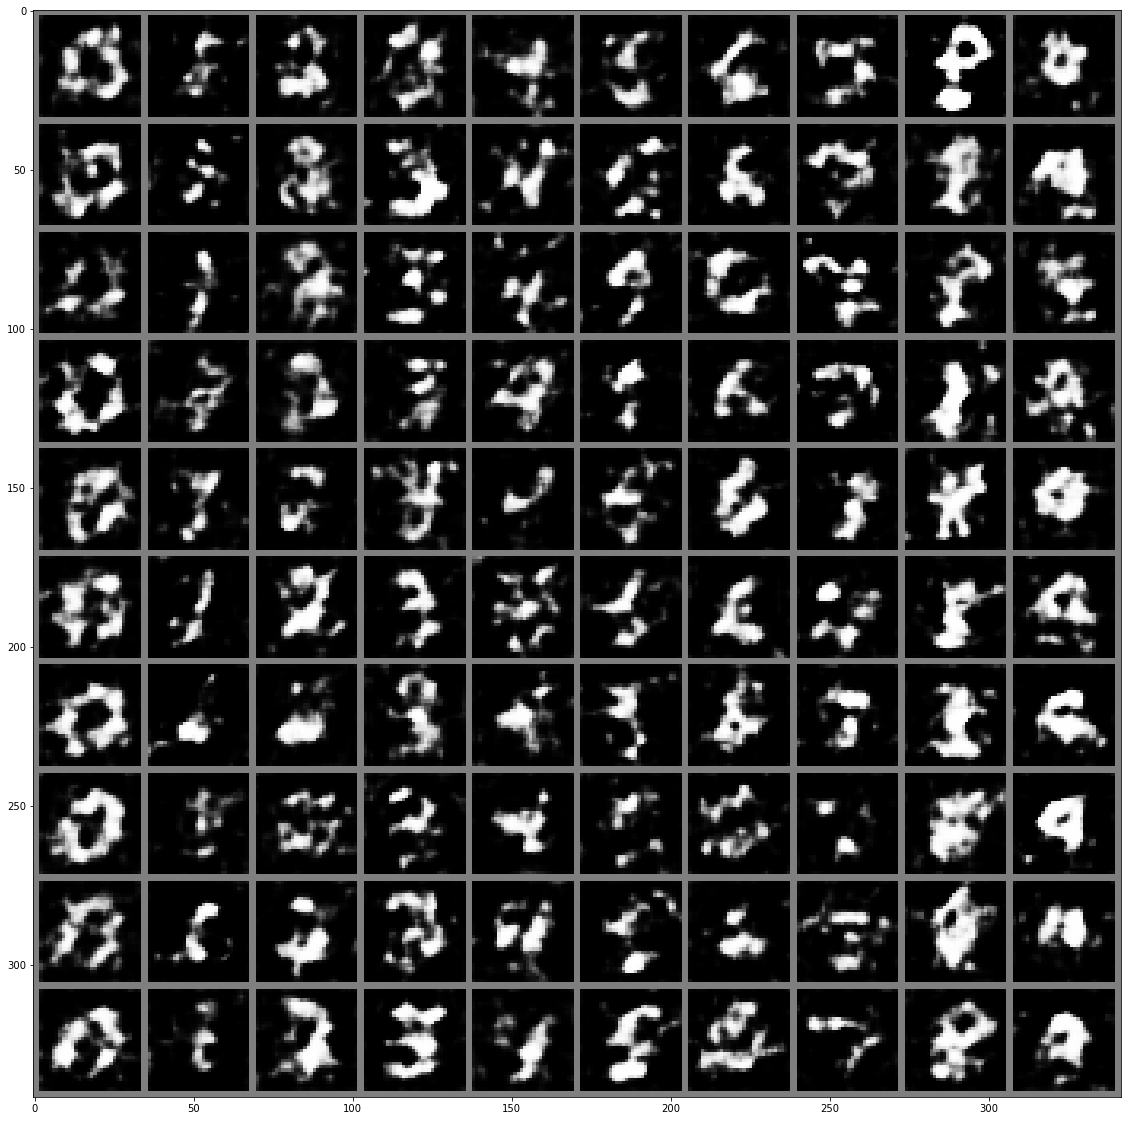

[Epoch 4/200] [Batch 228/468] [D loss: 0.494889, acc: 89%] [G loss: 0.539536]
[Epoch 4/200] [Batch 328/468] [D loss: 0.482093, acc: 89%] [G loss: 0.493973]
[Epoch 4/200] [Batch 428/468] [D loss: 0.491152, acc: 87%] [G loss: 0.542907]
[Epoch 5/200] [Batch 60/468] [D loss: 0.477921, acc: 92%] [G loss: 0.547950]
[Epoch 5/200] [Batch 160/468] [D loss: 0.530399, acc: 87%] [G loss: 0.505450]
[Epoch 5/200] [Batch 260/468] [D loss: 0.459084, acc: 91%] [G loss: 0.497806]
[Epoch 5/200] [Batch 360/468] [D loss: 0.467838, acc: 89%] [G loss: 0.511493]
[Epoch 5/200] [Batch 460/468] [D loss: 0.468438, acc: 91%] [G loss: 0.524777]
[Epoch 6/200] [Batch 92/468] [D loss: 0.469253, acc: 91%] [G loss: 0.536073]
[Epoch 6/200] [Batch 192/468] [D loss: 0.492194, acc: 90%] [G loss: 0.529263]
[Epoch 6/200] [Batch 292/468] [D loss: 0.483820, acc: 91%] [G loss: 0.492222]
[Epoch 6/200] [Batch 392/468] [D loss: 0.500891, acc: 90%] [G loss: 0.535065]
[Epoch 7/200] [Batch 24/468] [D loss: 0.458511, acc: 91%] [G loss:

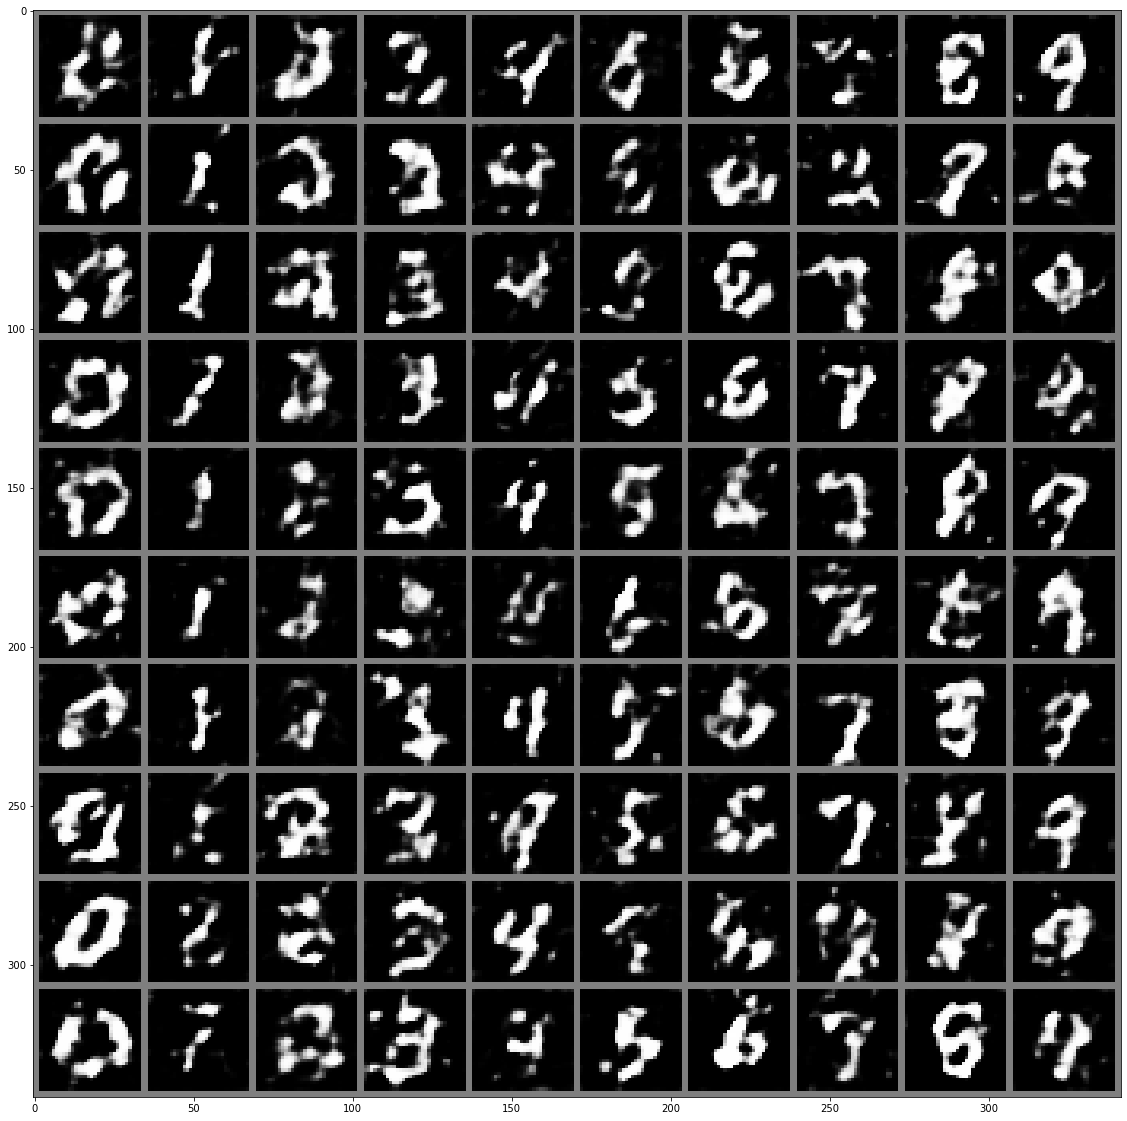

[Epoch 8/200] [Batch 356/468] [D loss: 0.446482, acc: 88%] [G loss: 0.542154]
[Epoch 8/200] [Batch 456/468] [D loss: 0.477074, acc: 89%] [G loss: 0.553222]
[Epoch 9/200] [Batch 88/468] [D loss: 0.461958, acc: 90%] [G loss: 0.597746]
[Epoch 9/200] [Batch 188/468] [D loss: 0.405909, acc: 92%] [G loss: 0.549303]
[Epoch 9/200] [Batch 288/468] [D loss: 0.452117, acc: 90%] [G loss: 0.510879]
[Epoch 9/200] [Batch 388/468] [D loss: 0.420623, acc: 90%] [G loss: 0.534114]
[Epoch 10/200] [Batch 20/468] [D loss: 0.397344, acc: 91%] [G loss: 0.581147]
[Epoch 10/200] [Batch 120/468] [D loss: 0.421633, acc: 94%] [G loss: 0.516219]
[Epoch 10/200] [Batch 220/468] [D loss: 0.416537, acc: 92%] [G loss: 0.585765]
[Epoch 10/200] [Batch 320/468] [D loss: 0.402935, acc: 93%] [G loss: 0.575006]
[Epoch 10/200] [Batch 420/468] [D loss: 0.375354, acc: 92%] [G loss: 0.554096]
[Epoch 11/200] [Batch 52/468] [D loss: 0.421191, acc: 92%] [G loss: 0.594080]
[Epoch 11/200] [Batch 152/468] [D loss: 0.391293, acc: 91%] [

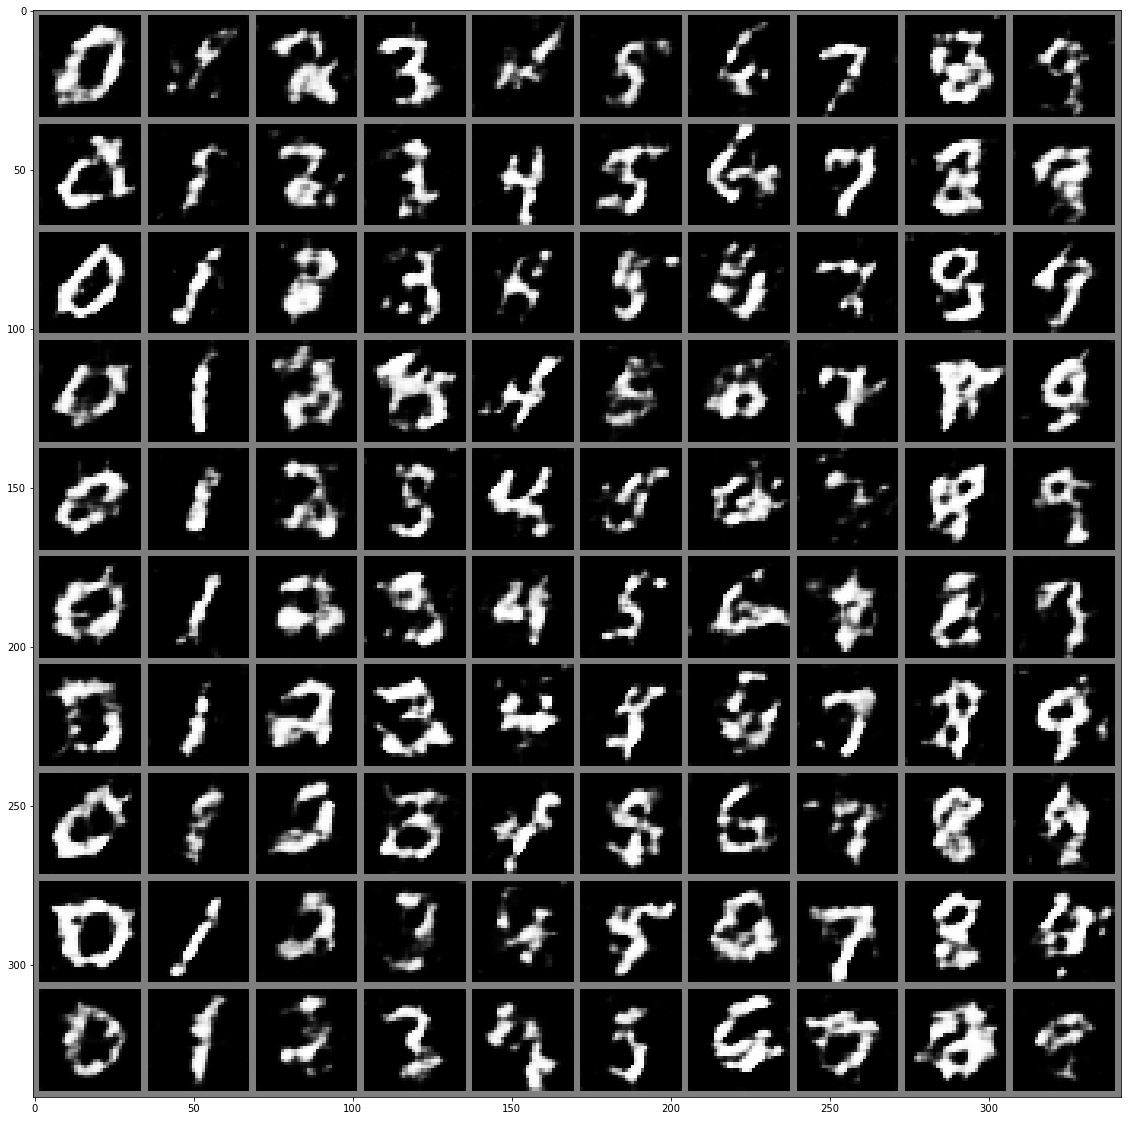

[Epoch 13/200] [Batch 16/468] [D loss: 0.353926, acc: 93%] [G loss: 0.704664]
[Epoch 13/200] [Batch 116/468] [D loss: 0.372464, acc: 92%] [G loss: 0.618825]
[Epoch 13/200] [Batch 216/468] [D loss: 0.349606, acc: 94%] [G loss: 0.660491]
[Epoch 13/200] [Batch 316/468] [D loss: 0.379905, acc: 92%] [G loss: 0.643562]
[Epoch 13/200] [Batch 416/468] [D loss: 0.353761, acc: 92%] [G loss: 0.674033]
[Epoch 14/200] [Batch 48/468] [D loss: 0.350289, acc: 94%] [G loss: 0.655826]
[Epoch 14/200] [Batch 148/468] [D loss: 0.404373, acc: 91%] [G loss: 0.648922]
[Epoch 14/200] [Batch 248/468] [D loss: 0.345286, acc: 92%] [G loss: 0.701125]
[Epoch 14/200] [Batch 348/468] [D loss: 0.375890, acc: 92%] [G loss: 0.696324]
[Epoch 14/200] [Batch 448/468] [D loss: 0.324145, acc: 95%] [G loss: 0.626275]
[Epoch 15/200] [Batch 80/468] [D loss: 0.343274, acc: 93%] [G loss: 0.602598]
[Epoch 15/200] [Batch 180/468] [D loss: 0.373343, acc: 96%] [G loss: 0.816429]
[Epoch 15/200] [Batch 280/468] [D loss: 0.350645, acc: 

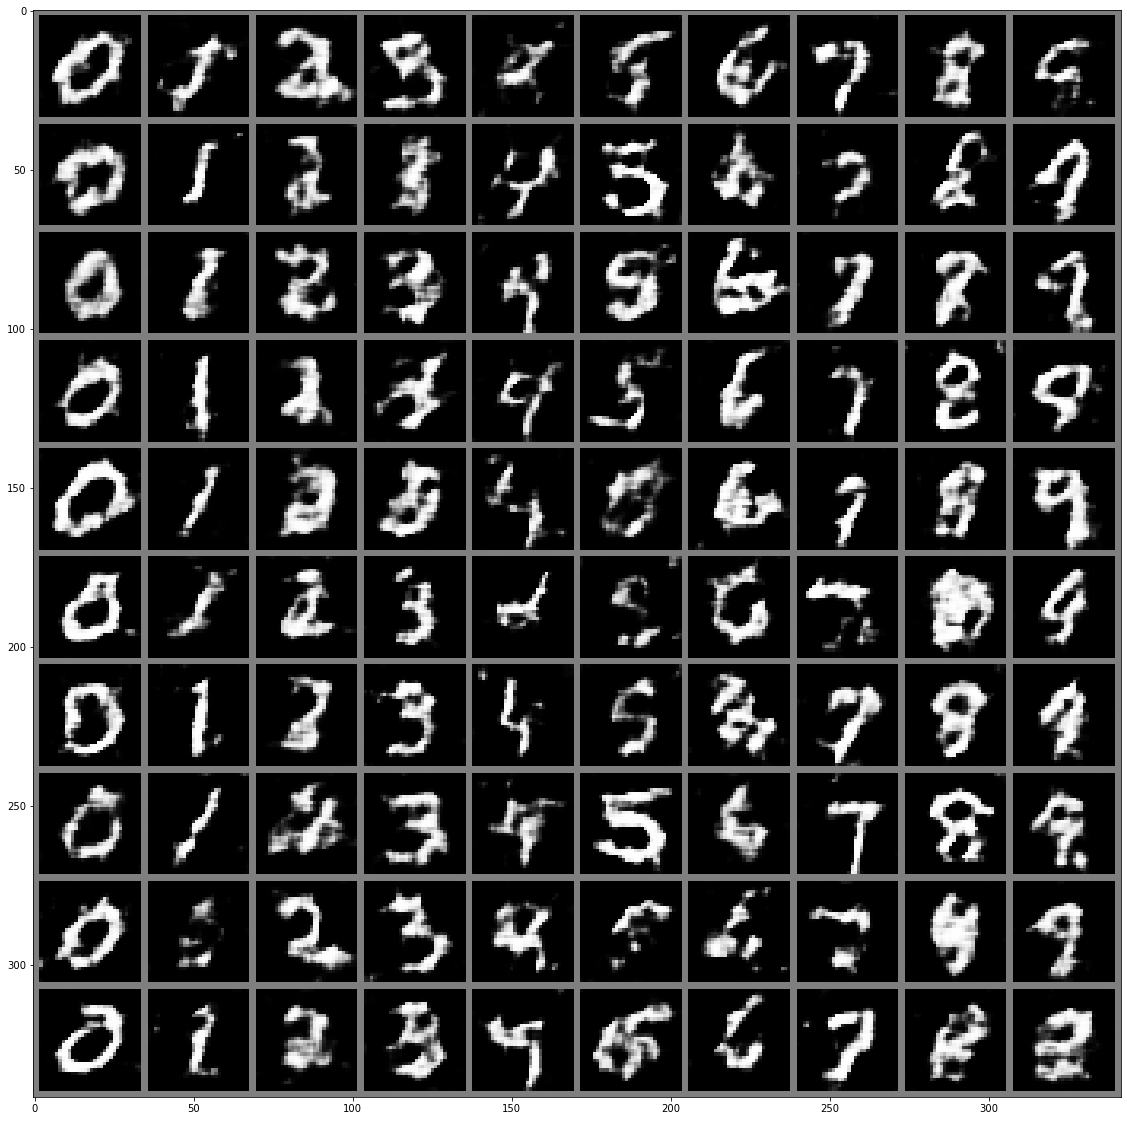

[Epoch 17/200] [Batch 144/468] [D loss: 0.358267, acc: 92%] [G loss: 0.712082]
[Epoch 17/200] [Batch 244/468] [D loss: 0.313236, acc: 92%] [G loss: 0.643715]
[Epoch 17/200] [Batch 344/468] [D loss: 0.364857, acc: 94%] [G loss: 0.648645]
[Epoch 17/200] [Batch 444/468] [D loss: 0.324707, acc: 94%] [G loss: 0.657163]
[Epoch 18/200] [Batch 76/468] [D loss: 0.350765, acc: 93%] [G loss: 0.695977]
[Epoch 18/200] [Batch 176/468] [D loss: 0.326237, acc: 96%] [G loss: 0.805262]
[Epoch 18/200] [Batch 276/468] [D loss: 0.257771, acc: 96%] [G loss: 0.720210]
[Epoch 18/200] [Batch 376/468] [D loss: 0.346137, acc: 94%] [G loss: 0.753379]
[Epoch 19/200] [Batch 8/468] [D loss: 0.271171, acc: 96%] [G loss: 0.649090]
[Epoch 19/200] [Batch 108/468] [D loss: 0.272538, acc: 95%] [G loss: 0.644839]
[Epoch 19/200] [Batch 208/468] [D loss: 0.356893, acc: 93%] [G loss: 0.694216]
[Epoch 19/200] [Batch 308/468] [D loss: 0.352364, acc: 93%] [G loss: 0.731557]
[Epoch 19/200] [Batch 408/468] [D loss: 0.264952, acc: 

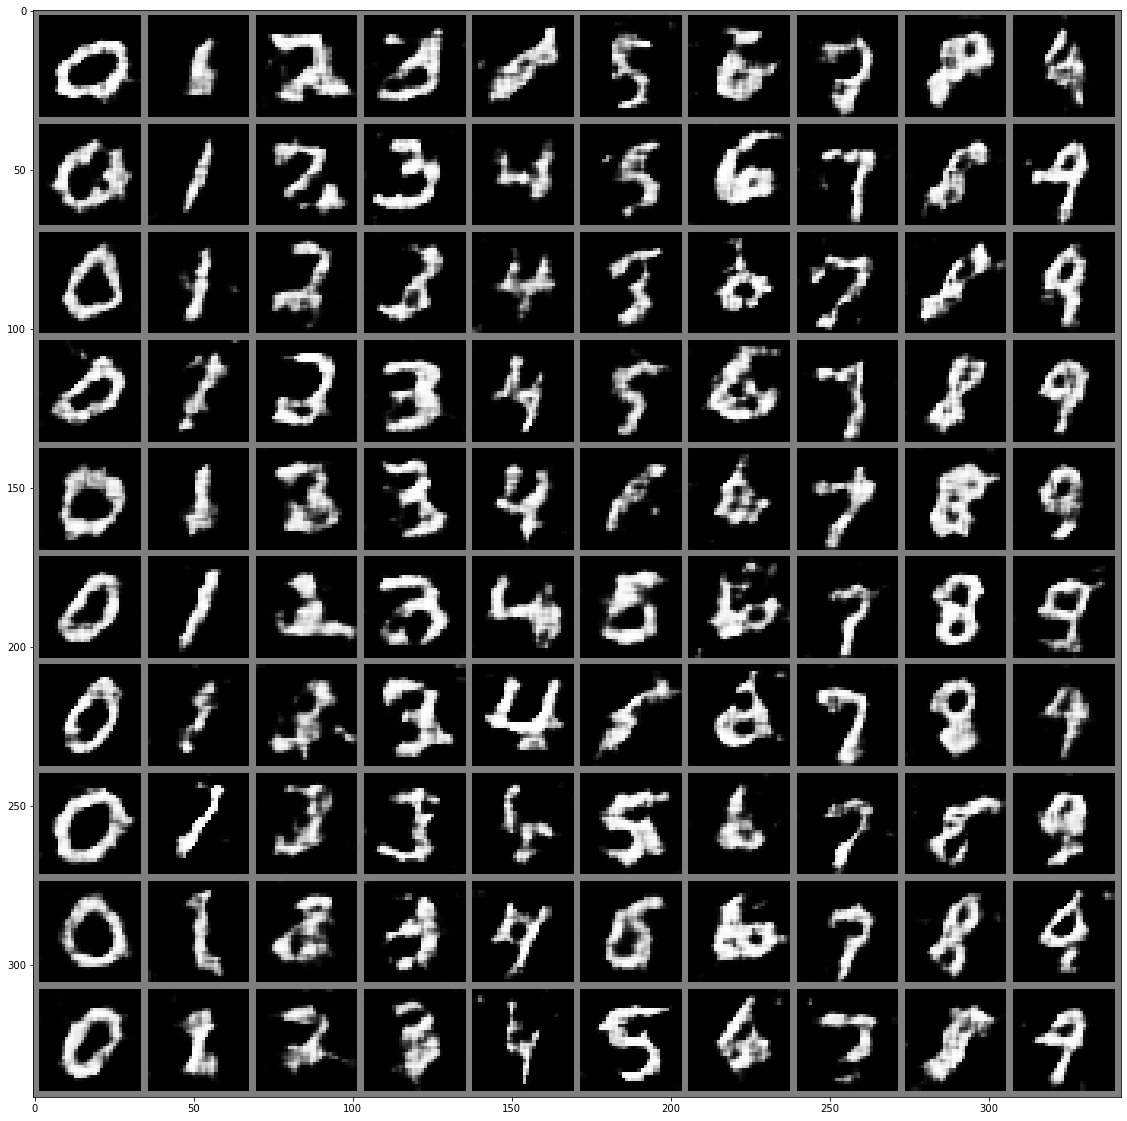

[Epoch 21/200] [Batch 272/468] [D loss: 0.334236, acc: 95%] [G loss: 0.711459]
[Epoch 21/200] [Batch 372/468] [D loss: 0.314253, acc: 96%] [G loss: 0.641429]
[Epoch 22/200] [Batch 4/468] [D loss: 0.350295, acc: 94%] [G loss: 0.763931]
[Epoch 22/200] [Batch 104/468] [D loss: 0.319277, acc: 92%] [G loss: 0.751840]
[Epoch 22/200] [Batch 204/468] [D loss: 0.339912, acc: 94%] [G loss: 0.636712]
[Epoch 22/200] [Batch 304/468] [D loss: 0.349758, acc: 93%] [G loss: 0.693366]
[Epoch 22/200] [Batch 404/468] [D loss: 0.276759, acc: 93%] [G loss: 0.684700]
[Epoch 23/200] [Batch 36/468] [D loss: 0.312399, acc: 94%] [G loss: 0.603003]
[Epoch 23/200] [Batch 136/468] [D loss: 0.367243, acc: 94%] [G loss: 0.669132]
[Epoch 23/200] [Batch 236/468] [D loss: 0.304183, acc: 94%] [G loss: 0.558990]
[Epoch 23/200] [Batch 336/468] [D loss: 0.278996, acc: 94%] [G loss: 0.876916]
[Epoch 23/200] [Batch 436/468] [D loss: 0.342905, acc: 94%] [G loss: 0.665182]
[Epoch 24/200] [Batch 68/468] [D loss: 0.281867, acc: 9

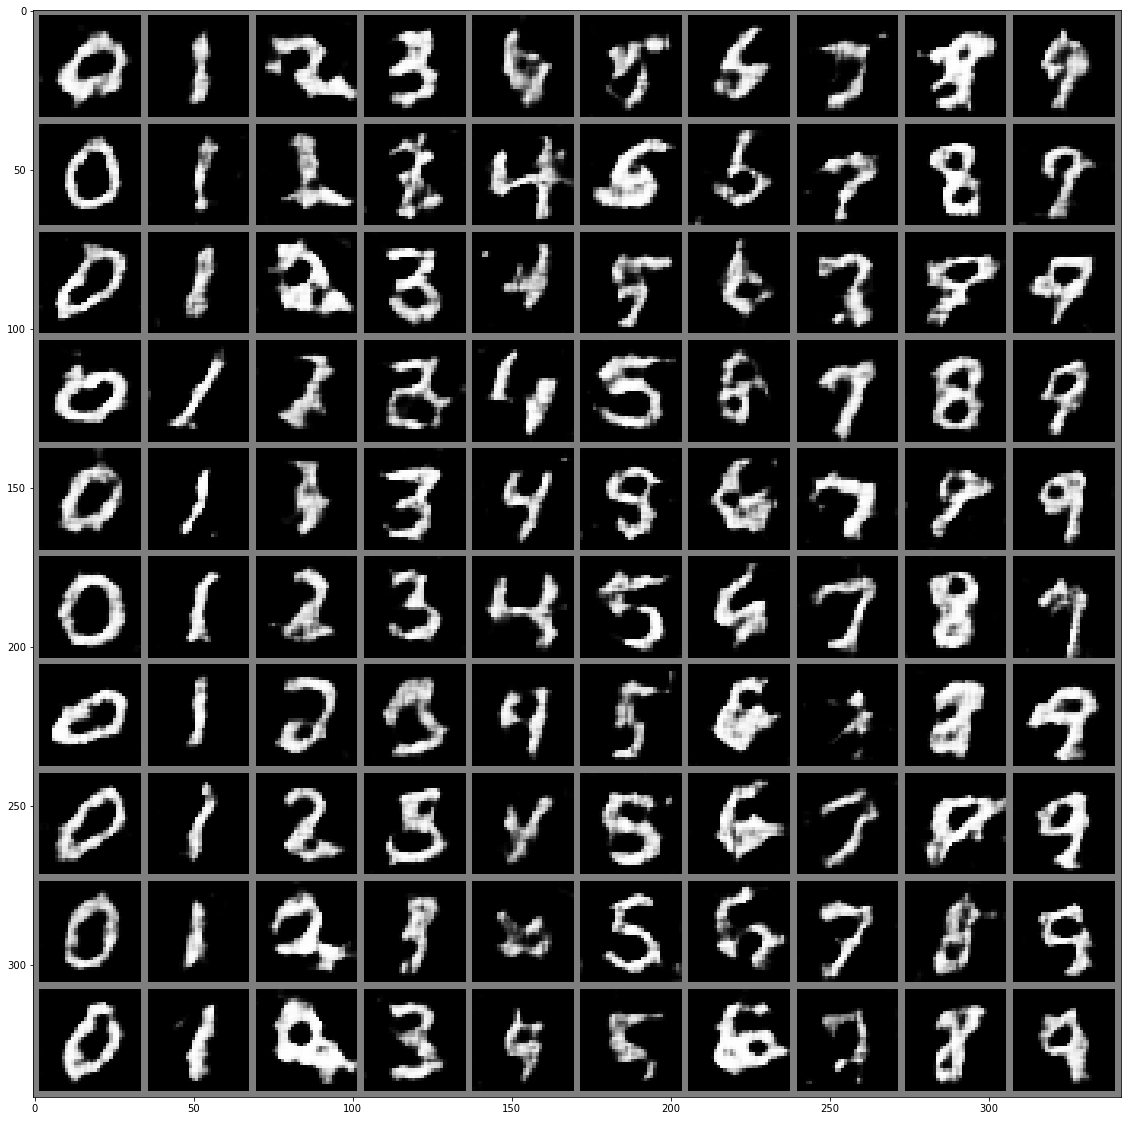

[Epoch 25/200] [Batch 400/468] [D loss: 0.291970, acc: 94%] [G loss: 0.710042]
[Epoch 26/200] [Batch 32/468] [D loss: 0.367305, acc: 92%] [G loss: 0.886184]
[Epoch 26/200] [Batch 132/468] [D loss: 0.299905, acc: 94%] [G loss: 0.734771]
[Epoch 26/200] [Batch 232/468] [D loss: 0.310832, acc: 93%] [G loss: 0.680548]
[Epoch 26/200] [Batch 332/468] [D loss: 0.315986, acc: 91%] [G loss: 0.954054]
[Epoch 26/200] [Batch 432/468] [D loss: 0.282413, acc: 94%] [G loss: 0.670485]
[Epoch 27/200] [Batch 64/468] [D loss: 0.237500, acc: 96%] [G loss: 0.751718]
[Epoch 27/200] [Batch 164/468] [D loss: 0.350532, acc: 94%] [G loss: 0.701044]
[Epoch 27/200] [Batch 264/468] [D loss: 0.323168, acc: 95%] [G loss: 0.861625]
[Epoch 27/200] [Batch 364/468] [D loss: 0.272405, acc: 94%] [G loss: 0.801646]
[Epoch 27/200] [Batch 464/468] [D loss: 0.287742, acc: 95%] [G loss: 0.610069]
[Epoch 28/200] [Batch 96/468] [D loss: 0.348895, acc: 94%] [G loss: 0.907939]
[Epoch 28/200] [Batch 196/468] [D loss: 0.278062, acc: 

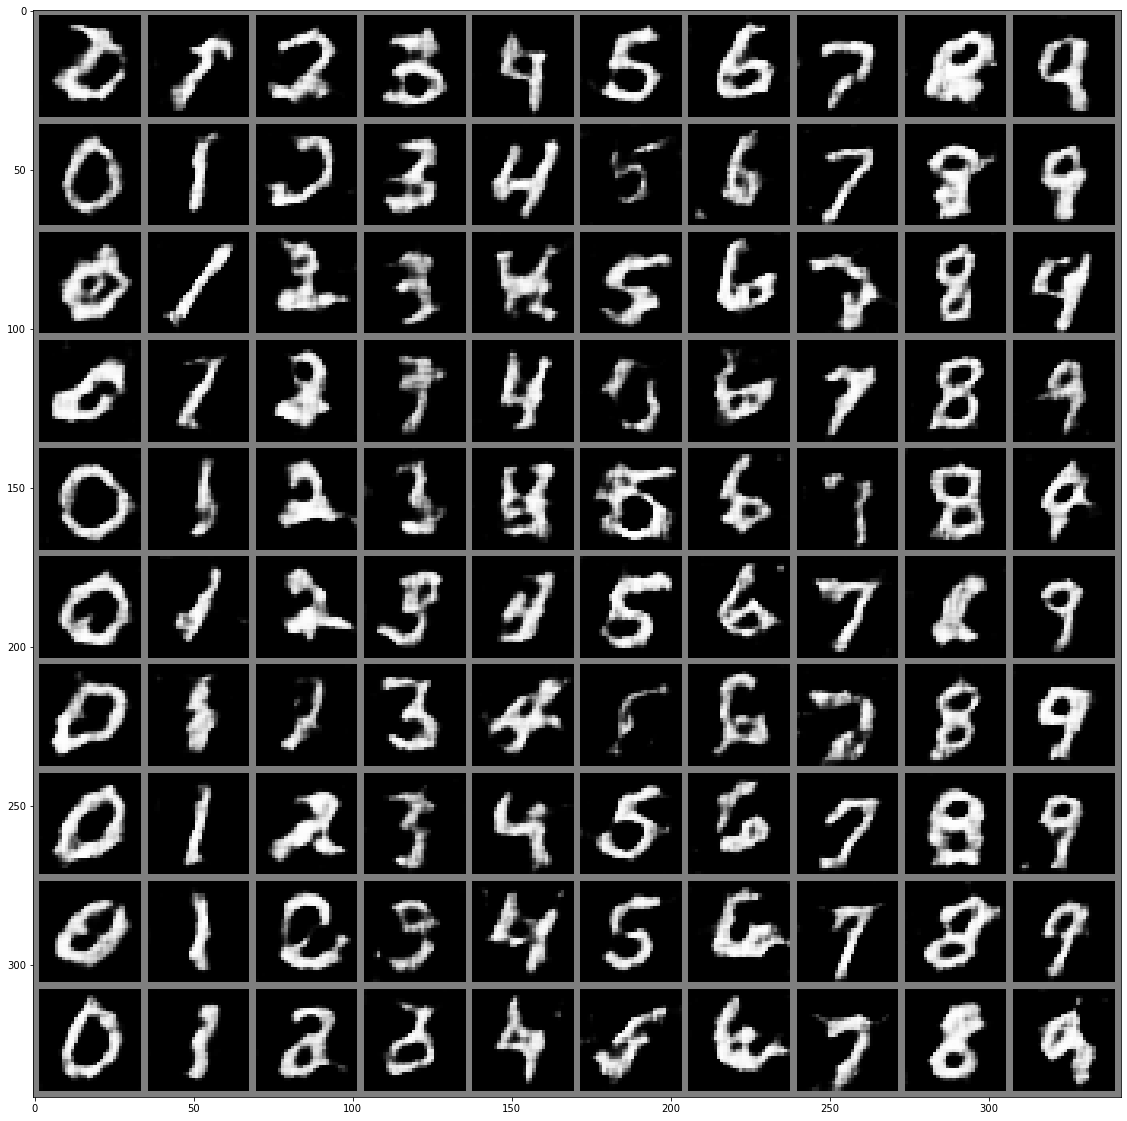

[Epoch 30/200] [Batch 60/468] [D loss: 0.236435, acc: 96%] [G loss: 0.610706]
[Epoch 30/200] [Batch 160/468] [D loss: 0.260939, acc: 97%] [G loss: 0.824850]
[Epoch 30/200] [Batch 260/468] [D loss: 0.337487, acc: 94%] [G loss: 0.595050]
[Epoch 30/200] [Batch 360/468] [D loss: 0.287194, acc: 94%] [G loss: 0.942575]
[Epoch 30/200] [Batch 460/468] [D loss: 0.309259, acc: 94%] [G loss: 0.665613]
[Epoch 31/200] [Batch 92/468] [D loss: 0.279202, acc: 94%] [G loss: 0.893402]
[Epoch 31/200] [Batch 192/468] [D loss: 0.298665, acc: 96%] [G loss: 0.529649]
[Epoch 31/200] [Batch 292/468] [D loss: 0.296430, acc: 95%] [G loss: 0.667935]
[Epoch 31/200] [Batch 392/468] [D loss: 0.359701, acc: 96%] [G loss: 0.676918]
[Epoch 32/200] [Batch 24/468] [D loss: 0.273690, acc: 97%] [G loss: 0.984380]
[Epoch 32/200] [Batch 124/468] [D loss: 0.330702, acc: 94%] [G loss: 0.680795]
[Epoch 32/200] [Batch 224/468] [D loss: 0.254265, acc: 96%] [G loss: 0.607268]
[Epoch 32/200] [Batch 324/468] [D loss: 0.298675, acc: 

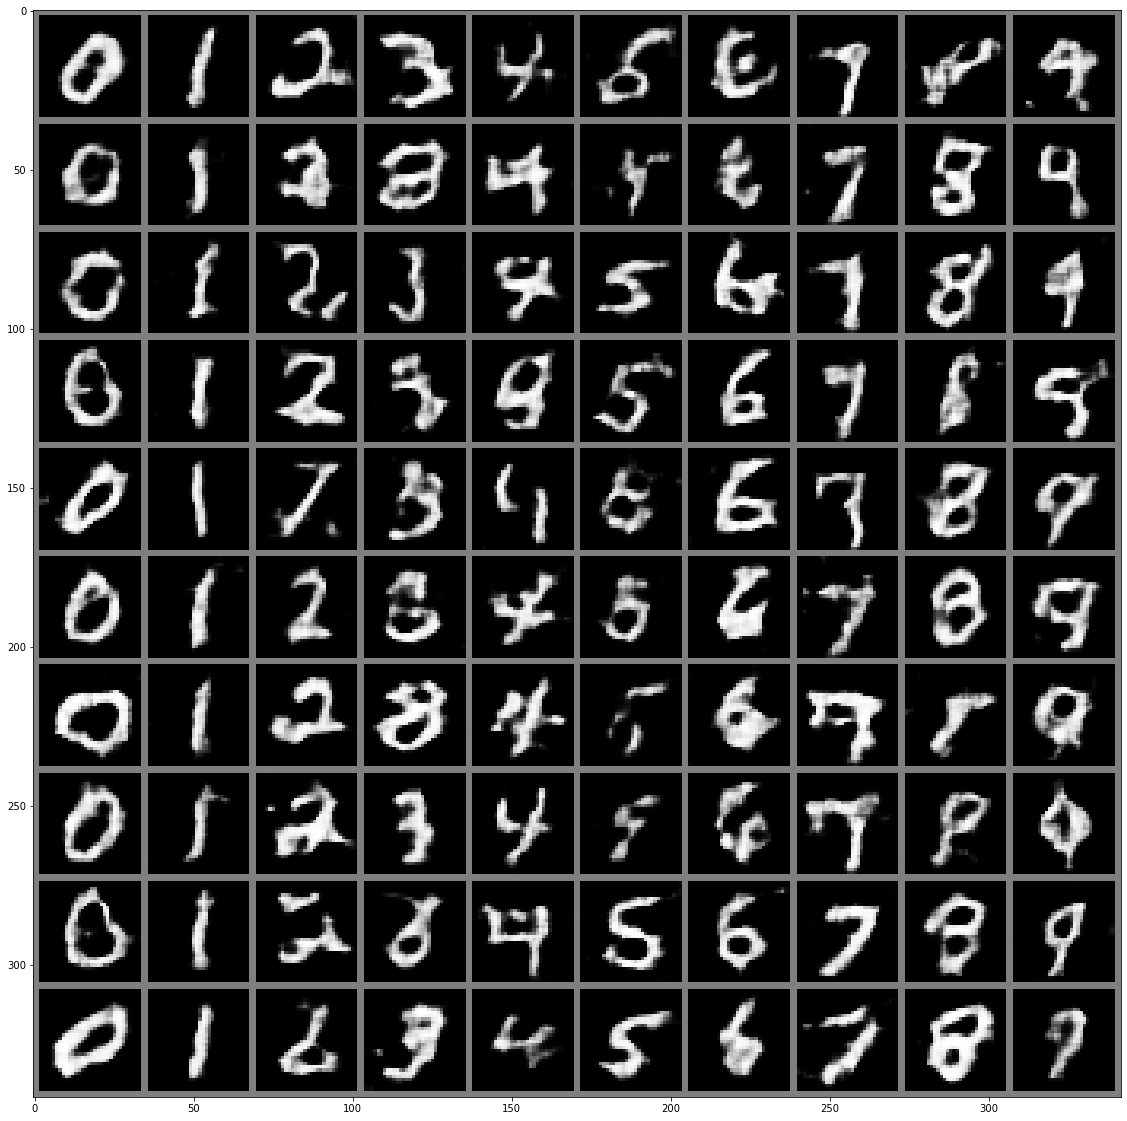

[Epoch 34/200] [Batch 188/468] [D loss: 0.289249, acc: 94%] [G loss: 0.999698]
[Epoch 34/200] [Batch 288/468] [D loss: 0.299074, acc: 95%] [G loss: 1.186567]
[Epoch 34/200] [Batch 388/468] [D loss: 0.217766, acc: 97%] [G loss: 1.091705]
[Epoch 35/200] [Batch 20/468] [D loss: 0.299136, acc: 96%] [G loss: 0.716316]
[Epoch 35/200] [Batch 120/468] [D loss: 0.215688, acc: 95%] [G loss: 0.577384]
[Epoch 35/200] [Batch 220/468] [D loss: 0.231234, acc: 95%] [G loss: 0.738368]
[Epoch 35/200] [Batch 320/468] [D loss: 0.245142, acc: 95%] [G loss: 0.876563]
[Epoch 35/200] [Batch 420/468] [D loss: 0.299281, acc: 95%] [G loss: 0.912427]
[Epoch 36/200] [Batch 52/468] [D loss: 0.268290, acc: 94%] [G loss: 0.770414]
[Epoch 36/200] [Batch 152/468] [D loss: 0.259716, acc: 98%] [G loss: 0.800836]
[Epoch 36/200] [Batch 252/468] [D loss: 0.310772, acc: 92%] [G loss: 0.807962]
[Epoch 36/200] [Batch 352/468] [D loss: 0.208716, acc: 93%] [G loss: 0.773406]
[Epoch 36/200] [Batch 452/468] [D loss: 0.201819, acc:

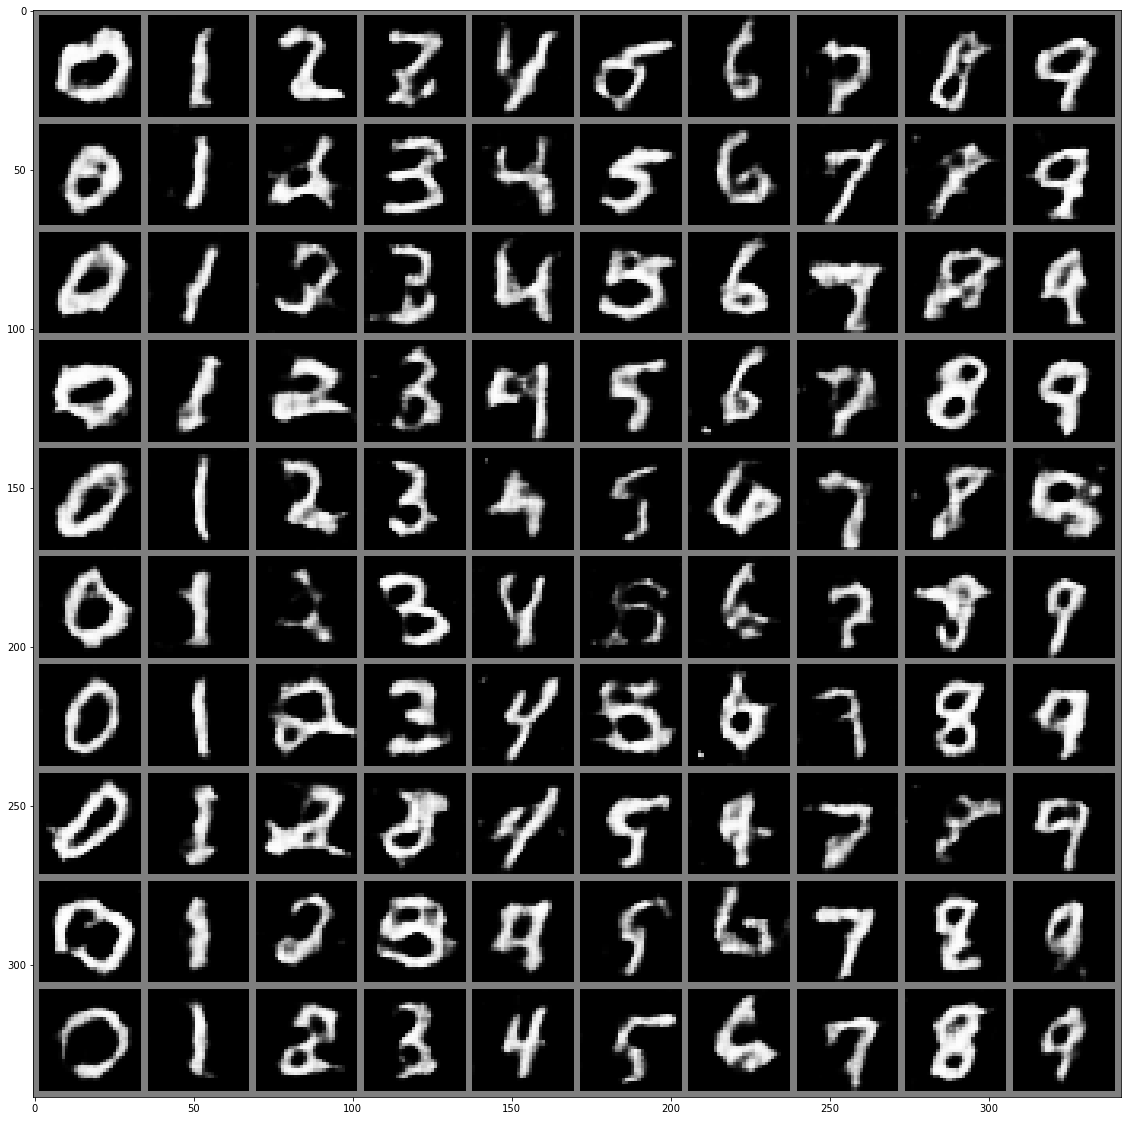

[Epoch 38/200] [Batch 316/468] [D loss: 0.256375, acc: 93%] [G loss: 0.544417]
[Epoch 38/200] [Batch 416/468] [D loss: 0.253544, acc: 93%] [G loss: 1.157367]
[Epoch 39/200] [Batch 48/468] [D loss: 0.288753, acc: 94%] [G loss: 1.124729]
[Epoch 39/200] [Batch 148/468] [D loss: 0.251169, acc: 95%] [G loss: 0.954243]
[Epoch 39/200] [Batch 248/468] [D loss: 0.321046, acc: 94%] [G loss: 1.087520]
[Epoch 39/200] [Batch 348/468] [D loss: 0.248753, acc: 94%] [G loss: 1.044259]
[Epoch 39/200] [Batch 448/468] [D loss: 0.291177, acc: 95%] [G loss: 0.665824]
[Epoch 40/200] [Batch 80/468] [D loss: 0.210237, acc: 96%] [G loss: 0.863348]
[Epoch 40/200] [Batch 180/468] [D loss: 0.195396, acc: 95%] [G loss: 1.409779]
[Epoch 40/200] [Batch 280/468] [D loss: 0.219861, acc: 94%] [G loss: 1.348081]
[Epoch 40/200] [Batch 380/468] [D loss: 0.233410, acc: 93%] [G loss: 1.106120]
[Epoch 41/200] [Batch 12/468] [D loss: 0.163873, acc: 95%] [G loss: 1.101094]
[Epoch 41/200] [Batch 112/468] [D loss: 0.321198, acc: 

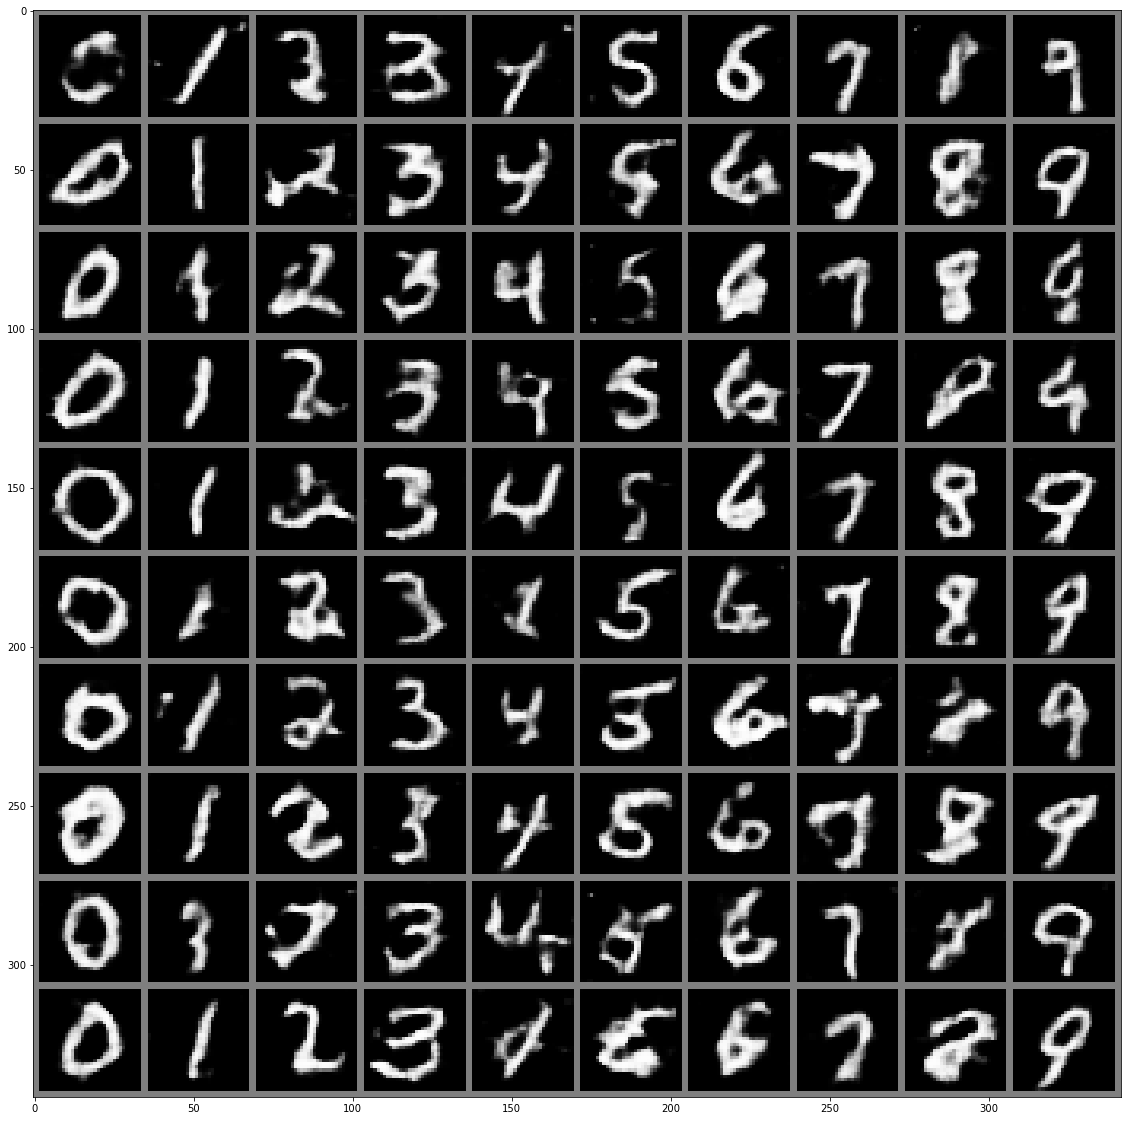

[Epoch 42/200] [Batch 444/468] [D loss: 0.269474, acc: 94%] [G loss: 0.440068]
[Epoch 43/200] [Batch 76/468] [D loss: 0.202875, acc: 95%] [G loss: 1.048774]
[Epoch 43/200] [Batch 176/468] [D loss: 0.131929, acc: 96%] [G loss: 0.633178]
[Epoch 43/200] [Batch 276/468] [D loss: 0.218833, acc: 97%] [G loss: 0.819429]
[Epoch 43/200] [Batch 376/468] [D loss: 0.258560, acc: 94%] [G loss: 1.083463]
[Epoch 44/200] [Batch 8/468] [D loss: 0.252210, acc: 93%] [G loss: 1.128838]
[Epoch 44/200] [Batch 108/468] [D loss: 0.176854, acc: 94%] [G loss: 0.744712]
[Epoch 44/200] [Batch 208/468] [D loss: 0.237547, acc: 95%] [G loss: 0.515567]
[Epoch 44/200] [Batch 308/468] [D loss: 0.257928, acc: 95%] [G loss: 0.992230]
[Epoch 44/200] [Batch 408/468] [D loss: 0.241238, acc: 94%] [G loss: 0.636936]
[Epoch 45/200] [Batch 40/468] [D loss: 0.233183, acc: 93%] [G loss: 1.426119]
[Epoch 45/200] [Batch 140/468] [D loss: 0.212483, acc: 97%] [G loss: 1.267518]
[Epoch 45/200] [Batch 240/468] [D loss: 0.163026, acc: 9

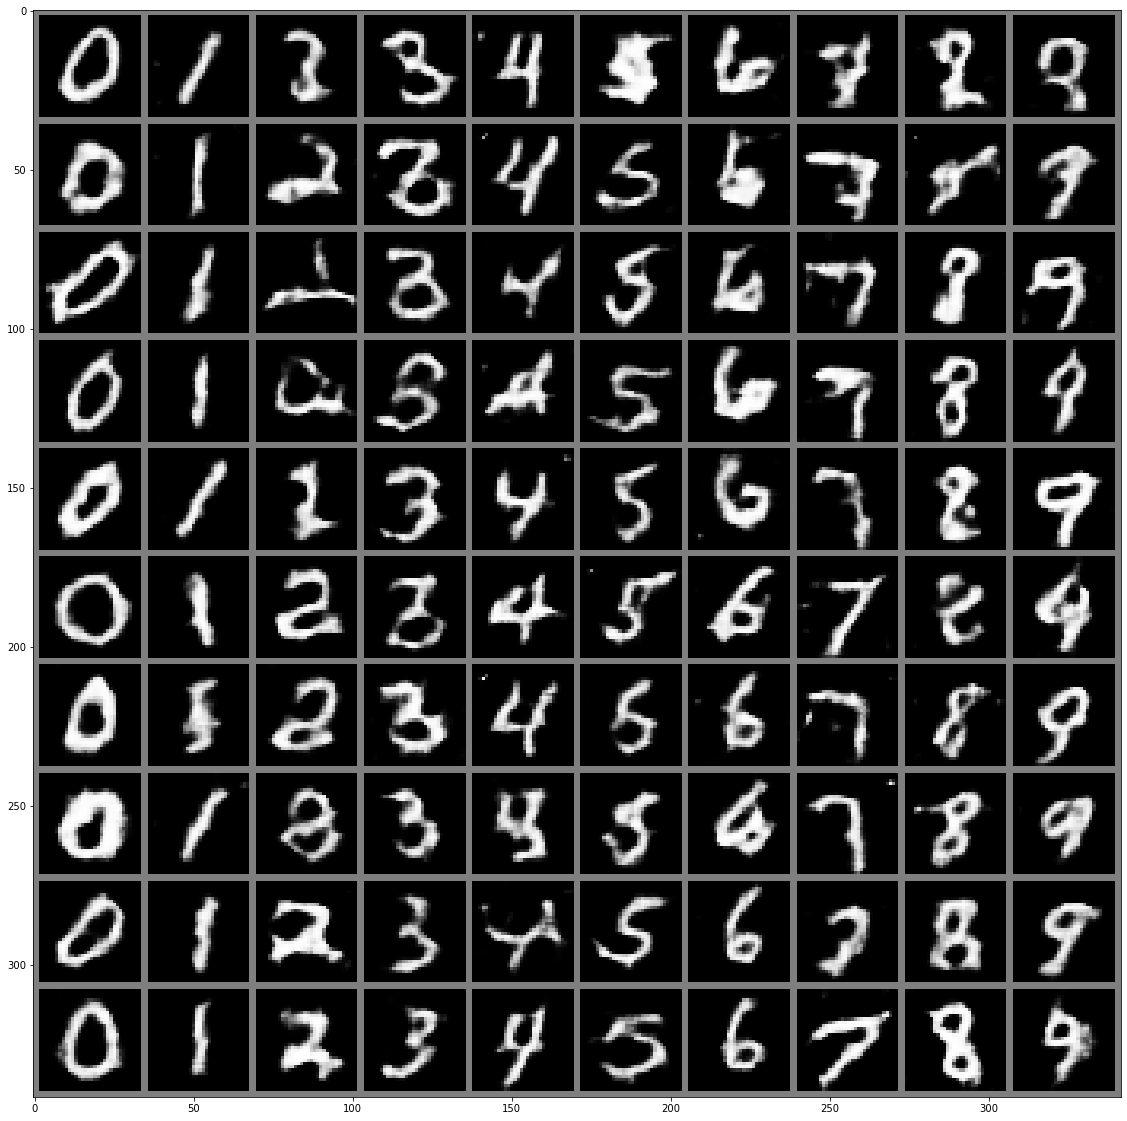

[Epoch 47/200] [Batch 104/468] [D loss: 0.237379, acc: 96%] [G loss: 1.192323]
[Epoch 47/200] [Batch 204/468] [D loss: 0.169407, acc: 96%] [G loss: 0.728157]
[Epoch 47/200] [Batch 304/468] [D loss: 0.209535, acc: 95%] [G loss: 1.037494]
[Epoch 47/200] [Batch 404/468] [D loss: 0.184933, acc: 95%] [G loss: 0.674872]
[Epoch 48/200] [Batch 36/468] [D loss: 0.351750, acc: 96%] [G loss: 1.257548]
[Epoch 48/200] [Batch 136/468] [D loss: 0.258894, acc: 94%] [G loss: 0.803593]
[Epoch 48/200] [Batch 236/468] [D loss: 0.288436, acc: 94%] [G loss: 0.648155]
[Epoch 48/200] [Batch 336/468] [D loss: 0.240691, acc: 92%] [G loss: 0.815991]
[Epoch 48/200] [Batch 436/468] [D loss: 0.221034, acc: 93%] [G loss: 0.970606]
[Epoch 49/200] [Batch 68/468] [D loss: 0.236796, acc: 94%] [G loss: 0.715285]
[Epoch 49/200] [Batch 168/468] [D loss: 0.146547, acc: 96%] [G loss: 0.897181]
[Epoch 49/200] [Batch 268/468] [D loss: 0.255858, acc: 92%] [G loss: 1.175643]
[Epoch 49/200] [Batch 368/468] [D loss: 0.275869, acc:

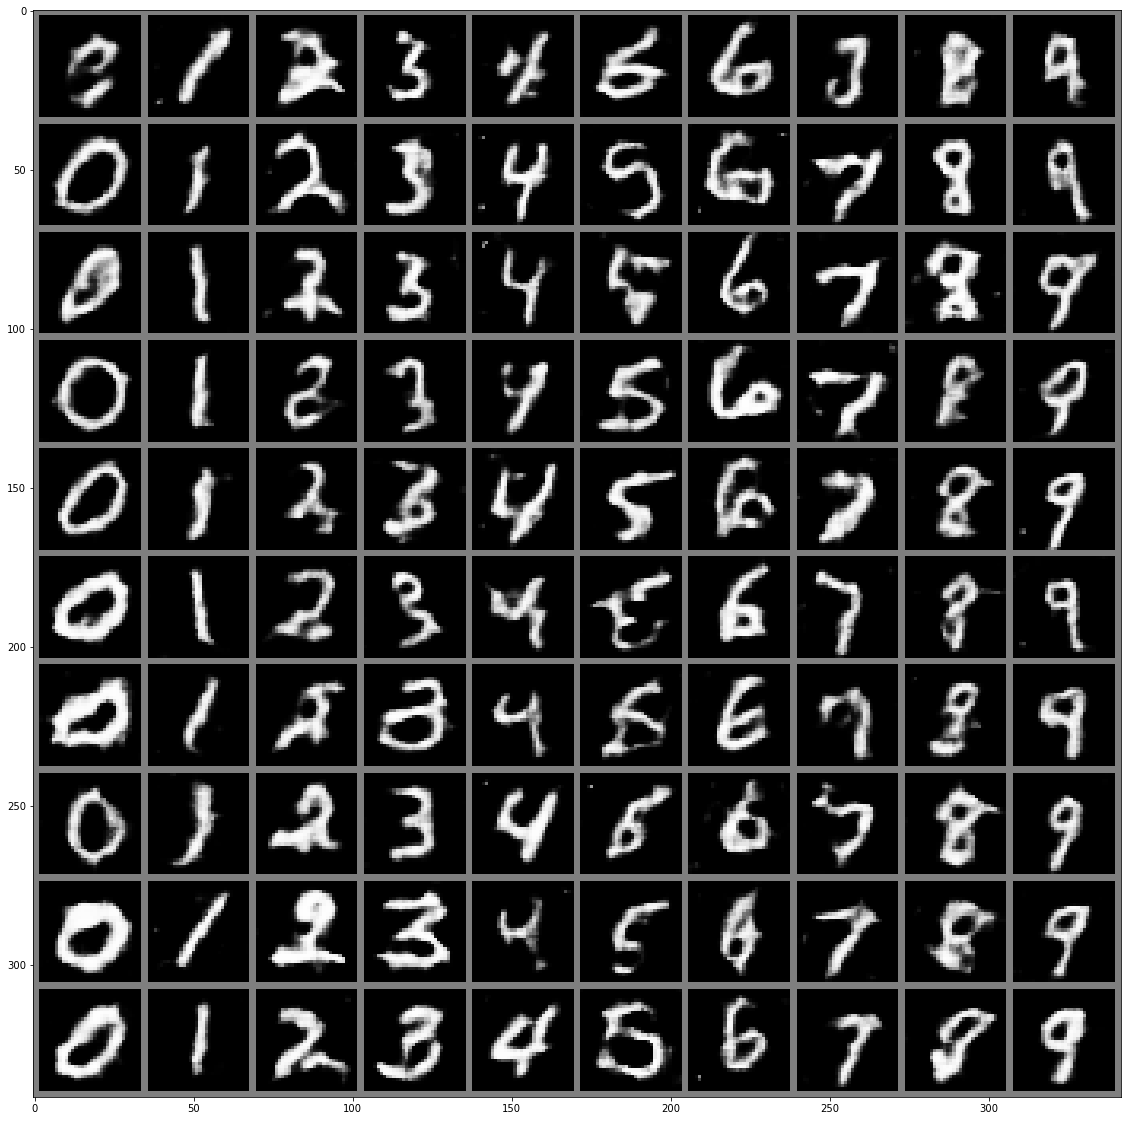

[Epoch 51/200] [Batch 232/468] [D loss: 0.204212, acc: 96%] [G loss: 0.761392]
[Epoch 51/200] [Batch 332/468] [D loss: 0.196037, acc: 94%] [G loss: 1.089539]
[Epoch 51/200] [Batch 432/468] [D loss: 0.203028, acc: 94%] [G loss: 0.977307]
[Epoch 52/200] [Batch 64/468] [D loss: 0.250075, acc: 95%] [G loss: 0.751644]
[Epoch 52/200] [Batch 164/468] [D loss: 0.205695, acc: 94%] [G loss: 0.886108]
[Epoch 52/200] [Batch 264/468] [D loss: 0.320067, acc: 94%] [G loss: 0.892051]
[Epoch 52/200] [Batch 364/468] [D loss: 0.252209, acc: 96%] [G loss: 0.696060]
[Epoch 52/200] [Batch 464/468] [D loss: 0.165917, acc: 94%] [G loss: 0.753269]
[Epoch 53/200] [Batch 96/468] [D loss: 0.181851, acc: 96%] [G loss: 1.045064]
[Epoch 53/200] [Batch 196/468] [D loss: 0.167399, acc: 95%] [G loss: 1.017428]
[Epoch 53/200] [Batch 296/468] [D loss: 0.279176, acc: 94%] [G loss: 1.484551]
[Epoch 53/200] [Batch 396/468] [D loss: 0.183658, acc: 95%] [G loss: 0.900911]
[Epoch 54/200] [Batch 28/468] [D loss: 0.261608, acc: 

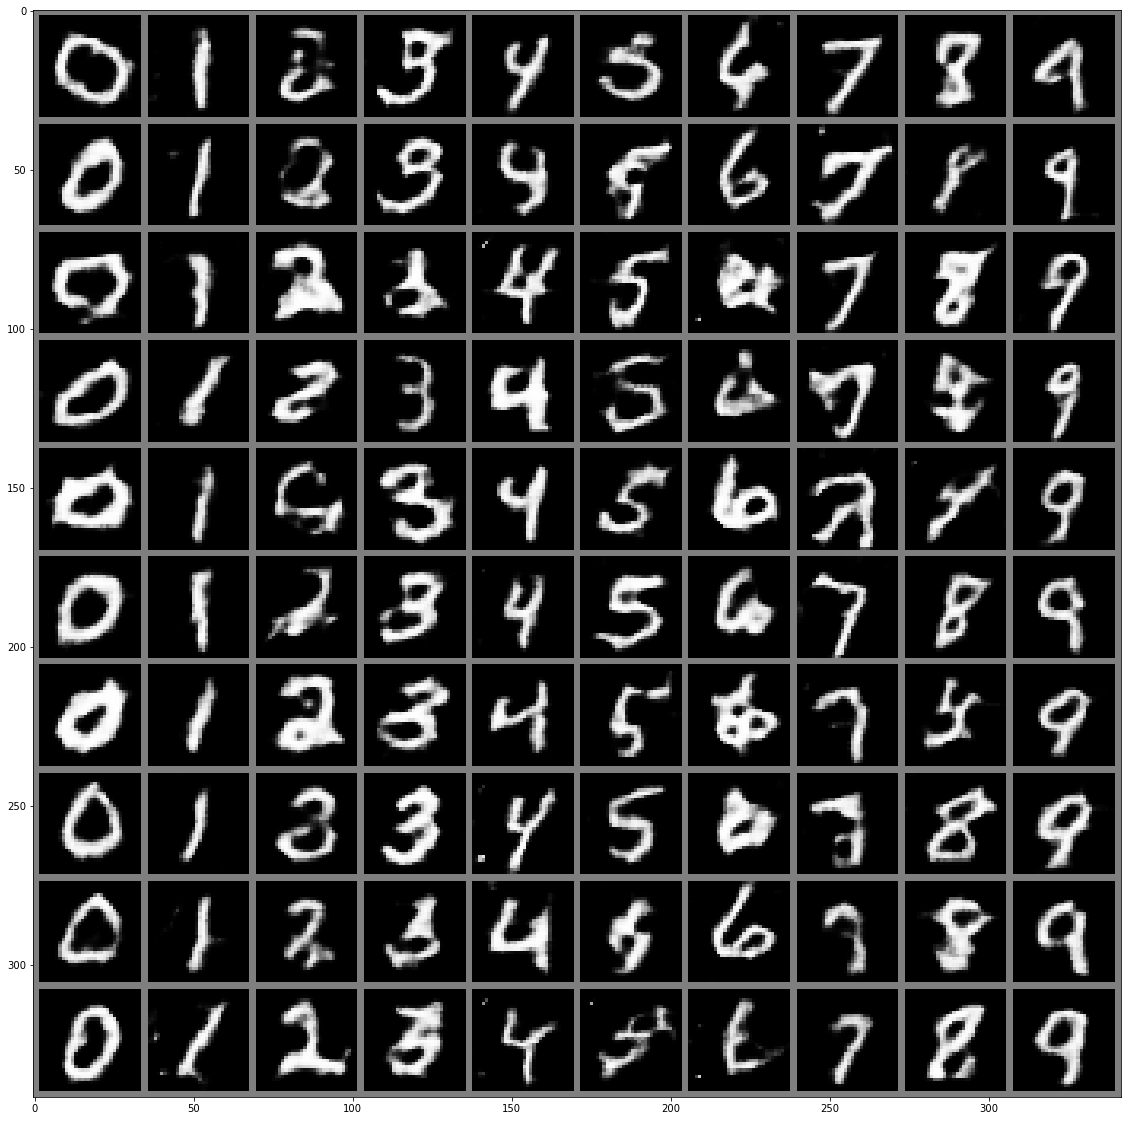

[Epoch 55/200] [Batch 360/468] [D loss: 0.263208, acc: 96%] [G loss: 0.997188]
[Epoch 55/200] [Batch 460/468] [D loss: 0.163919, acc: 95%] [G loss: 1.258902]
[Epoch 56/200] [Batch 92/468] [D loss: 0.250767, acc: 94%] [G loss: 0.729340]
[Epoch 56/200] [Batch 192/468] [D loss: 0.238205, acc: 94%] [G loss: 1.341217]
[Epoch 56/200] [Batch 292/468] [D loss: 0.244383, acc: 95%] [G loss: 1.153152]
[Epoch 56/200] [Batch 392/468] [D loss: 0.221404, acc: 99%] [G loss: 0.761018]
[Epoch 57/200] [Batch 24/468] [D loss: 0.192161, acc: 95%] [G loss: 1.230963]
[Epoch 57/200] [Batch 124/468] [D loss: 0.171790, acc: 96%] [G loss: 1.013023]
[Epoch 57/200] [Batch 224/468] [D loss: 0.223121, acc: 95%] [G loss: 1.555113]
[Epoch 57/200] [Batch 324/468] [D loss: 0.235077, acc: 92%] [G loss: 1.249303]
[Epoch 57/200] [Batch 424/468] [D loss: 0.177185, acc: 96%] [G loss: 0.799882]
[Epoch 58/200] [Batch 56/468] [D loss: 0.168174, acc: 96%] [G loss: 0.984568]
[Epoch 58/200] [Batch 156/468] [D loss: 0.154079, acc: 

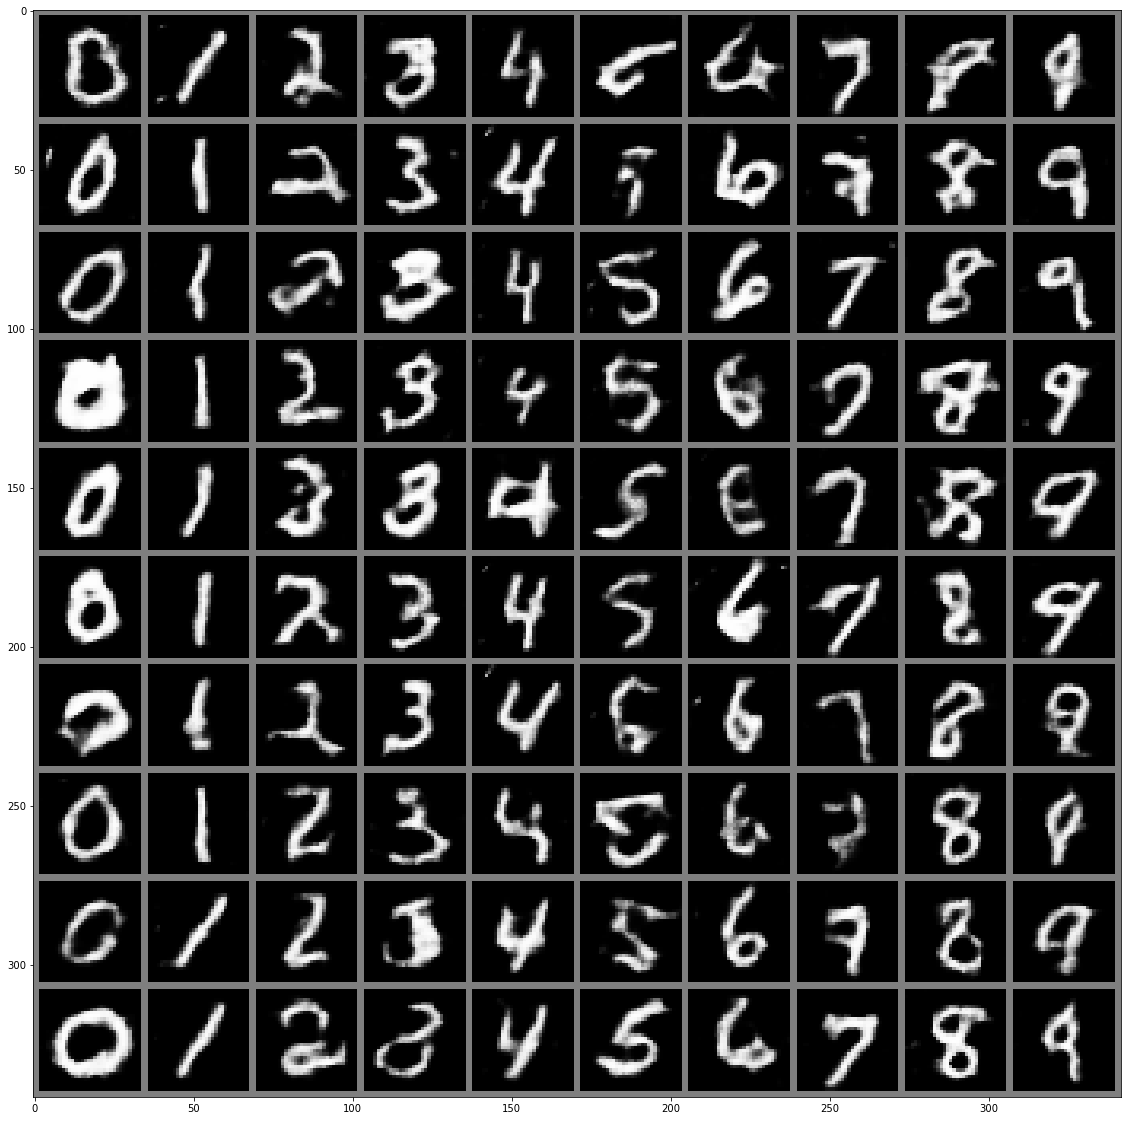

[Epoch 60/200] [Batch 20/468] [D loss: 0.200809, acc: 92%] [G loss: 1.411031]
[Epoch 60/200] [Batch 120/468] [D loss: 0.166575, acc: 93%] [G loss: 1.493418]
[Epoch 60/200] [Batch 220/468] [D loss: 0.190812, acc: 95%] [G loss: 1.023699]
[Epoch 60/200] [Batch 320/468] [D loss: 0.209906, acc: 96%] [G loss: 1.461649]
[Epoch 60/200] [Batch 420/468] [D loss: 0.182712, acc: 94%] [G loss: 1.173420]
[Epoch 61/200] [Batch 52/468] [D loss: 0.174970, acc: 94%] [G loss: 1.329696]
[Epoch 61/200] [Batch 152/468] [D loss: 0.340321, acc: 95%] [G loss: 0.767975]
[Epoch 61/200] [Batch 252/468] [D loss: 0.303835, acc: 94%] [G loss: 0.554220]
[Epoch 61/200] [Batch 352/468] [D loss: 0.194372, acc: 94%] [G loss: 0.852960]
[Epoch 61/200] [Batch 452/468] [D loss: 0.184329, acc: 96%] [G loss: 1.090216]
[Epoch 62/200] [Batch 84/468] [D loss: 0.170922, acc: 97%] [G loss: 0.615089]
[Epoch 62/200] [Batch 184/468] [D loss: 0.122309, acc: 97%] [G loss: 0.316154]
[Epoch 62/200] [Batch 284/468] [D loss: 0.154838, acc: 

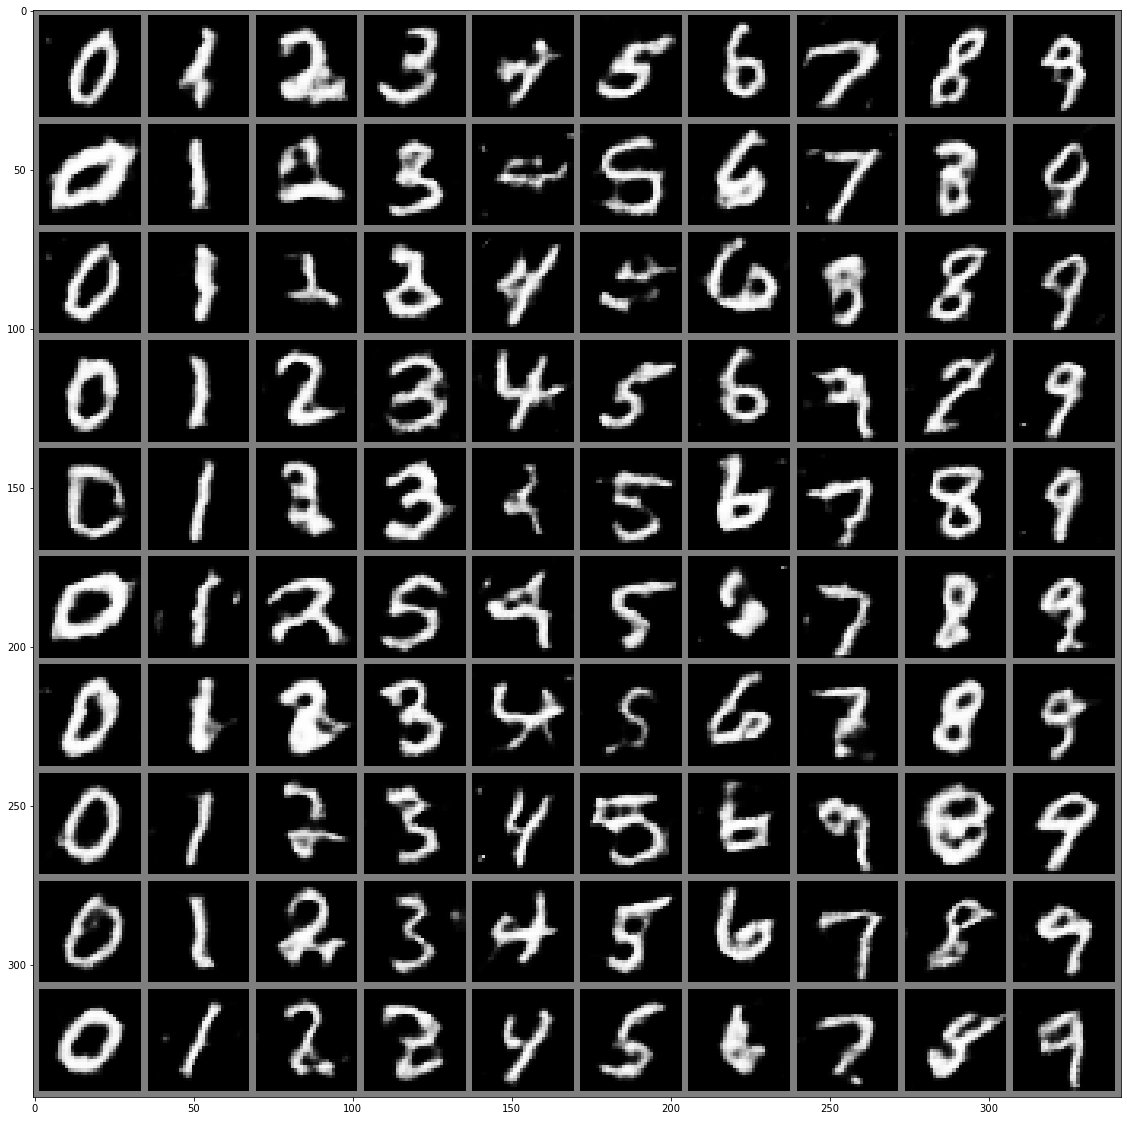

[Epoch 64/200] [Batch 148/468] [D loss: 0.191381, acc: 95%] [G loss: 1.245926]
[Epoch 64/200] [Batch 248/468] [D loss: 0.169201, acc: 96%] [G loss: 1.579265]
[Epoch 64/200] [Batch 348/468] [D loss: 0.212825, acc: 95%] [G loss: 1.147688]
[Epoch 64/200] [Batch 448/468] [D loss: 0.219453, acc: 94%] [G loss: 0.705588]
[Epoch 65/200] [Batch 80/468] [D loss: 0.344949, acc: 94%] [G loss: 0.316371]
[Epoch 65/200] [Batch 180/468] [D loss: 0.182533, acc: 96%] [G loss: 1.106331]
[Epoch 65/200] [Batch 280/468] [D loss: 0.172698, acc: 94%] [G loss: 1.254855]
[Epoch 65/200] [Batch 380/468] [D loss: 0.272984, acc: 96%] [G loss: 0.865203]
[Epoch 66/200] [Batch 12/468] [D loss: 0.207469, acc: 96%] [G loss: 0.678302]
[Epoch 66/200] [Batch 112/468] [D loss: 0.190891, acc: 95%] [G loss: 1.169974]
[Epoch 66/200] [Batch 212/468] [D loss: 0.202202, acc: 94%] [G loss: 1.487312]
[Epoch 66/200] [Batch 312/468] [D loss: 0.242409, acc: 98%] [G loss: 1.112852]
[Epoch 66/200] [Batch 412/468] [D loss: 0.296951, acc:

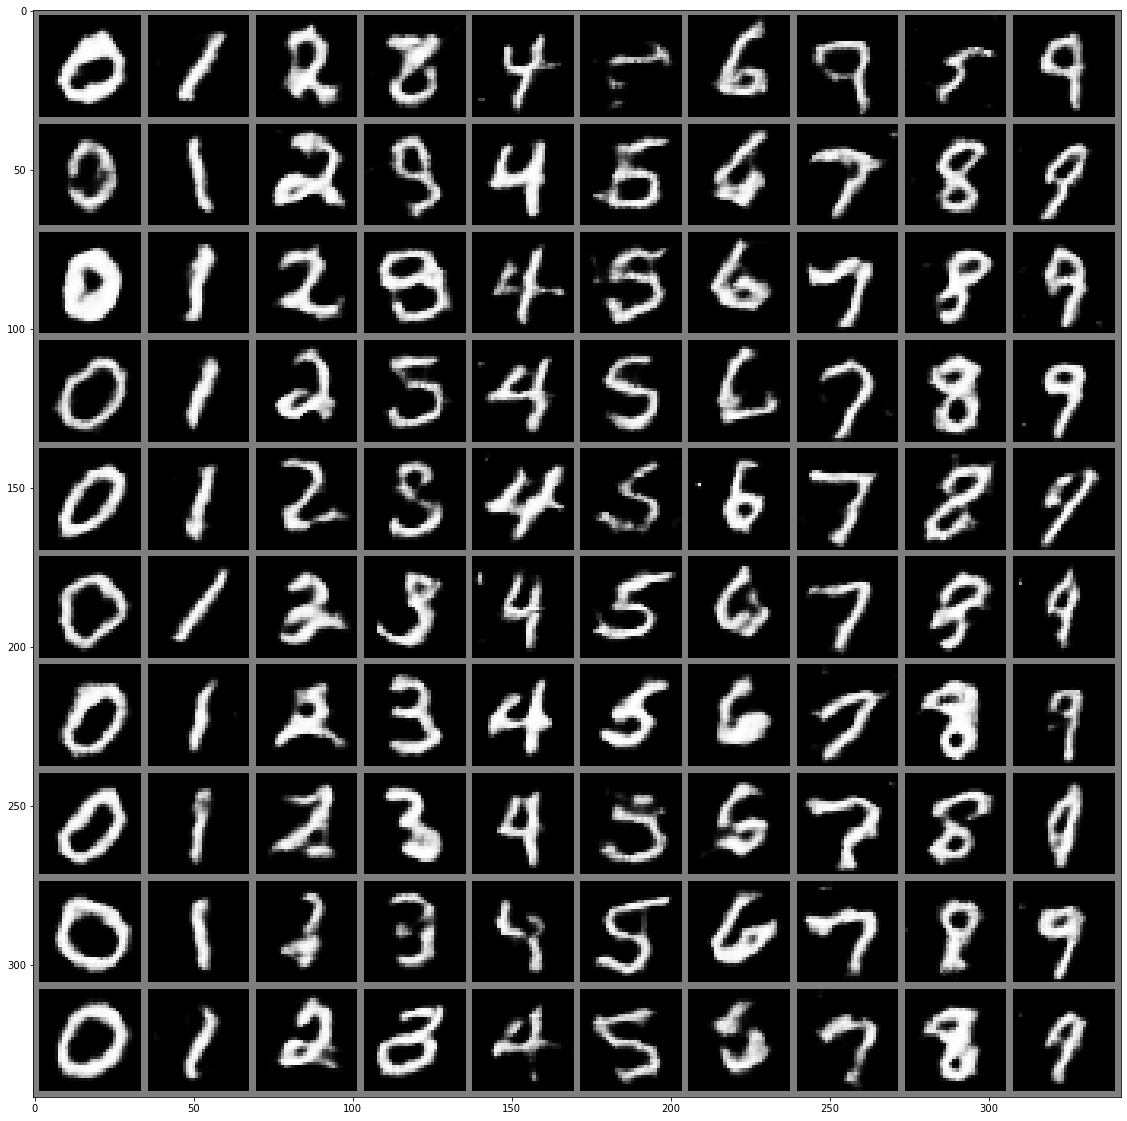

[Epoch 68/200] [Batch 276/468] [D loss: 0.262343, acc: 93%] [G loss: 0.854472]
[Epoch 68/200] [Batch 376/468] [D loss: 0.182932, acc: 94%] [G loss: 1.061335]
[Epoch 69/200] [Batch 8/468] [D loss: 0.121480, acc: 95%] [G loss: 0.972566]
[Epoch 69/200] [Batch 108/468] [D loss: 0.229311, acc: 95%] [G loss: 1.628770]
[Epoch 69/200] [Batch 208/468] [D loss: 0.249670, acc: 96%] [G loss: 1.112188]
[Epoch 69/200] [Batch 308/468] [D loss: 0.192834, acc: 95%] [G loss: 1.239325]
[Epoch 69/200] [Batch 408/468] [D loss: 0.264904, acc: 95%] [G loss: 1.220464]
[Epoch 70/200] [Batch 40/468] [D loss: 0.233659, acc: 92%] [G loss: 0.717116]
[Epoch 70/200] [Batch 140/468] [D loss: 0.219565, acc: 94%] [G loss: 0.710860]
[Epoch 70/200] [Batch 240/468] [D loss: 0.226670, acc: 96%] [G loss: 0.978161]
[Epoch 70/200] [Batch 340/468] [D loss: 0.202717, acc: 96%] [G loss: 1.412990]
[Epoch 70/200] [Batch 440/468] [D loss: 0.088835, acc: 97%] [G loss: 1.336771]
[Epoch 71/200] [Batch 72/468] [D loss: 0.154030, acc: 9

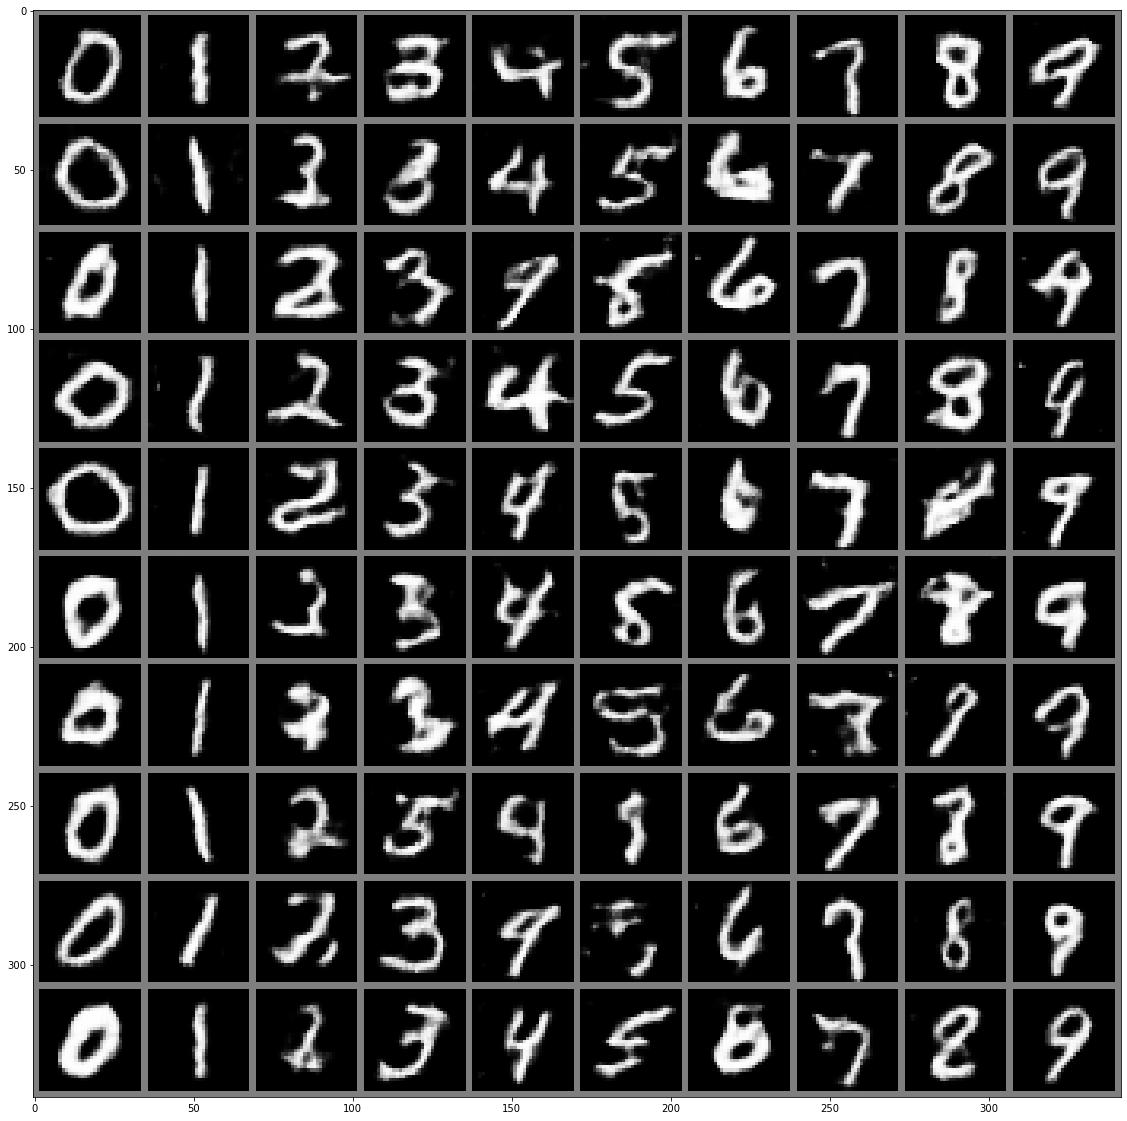

[Epoch 72/200] [Batch 404/468] [D loss: 0.214931, acc: 97%] [G loss: 0.574973]
[Epoch 73/200] [Batch 36/468] [D loss: 0.164527, acc: 94%] [G loss: 0.703759]
[Epoch 73/200] [Batch 136/468] [D loss: 0.222848, acc: 95%] [G loss: 1.155703]
[Epoch 73/200] [Batch 236/468] [D loss: 0.130871, acc: 95%] [G loss: 0.884587]
[Epoch 73/200] [Batch 336/468] [D loss: 0.198807, acc: 96%] [G loss: 1.474894]
[Epoch 73/200] [Batch 436/468] [D loss: 0.375781, acc: 96%] [G loss: 0.929630]
[Epoch 74/200] [Batch 68/468] [D loss: 0.166753, acc: 94%] [G loss: 0.970358]
[Epoch 74/200] [Batch 168/468] [D loss: 0.154108, acc: 98%] [G loss: 1.243544]
[Epoch 74/200] [Batch 268/468] [D loss: 0.116042, acc: 94%] [G loss: 0.742014]
[Epoch 74/200] [Batch 368/468] [D loss: 0.213347, acc: 95%] [G loss: 0.928046]
[Epoch 75/200] [Batch 0/468] [D loss: 0.149068, acc: 96%] [G loss: 1.009225]
[Epoch 75/200] [Batch 100/468] [D loss: 0.141489, acc: 95%] [G loss: 1.459430]
[Epoch 75/200] [Batch 200/468] [D loss: 0.248206, acc: 9

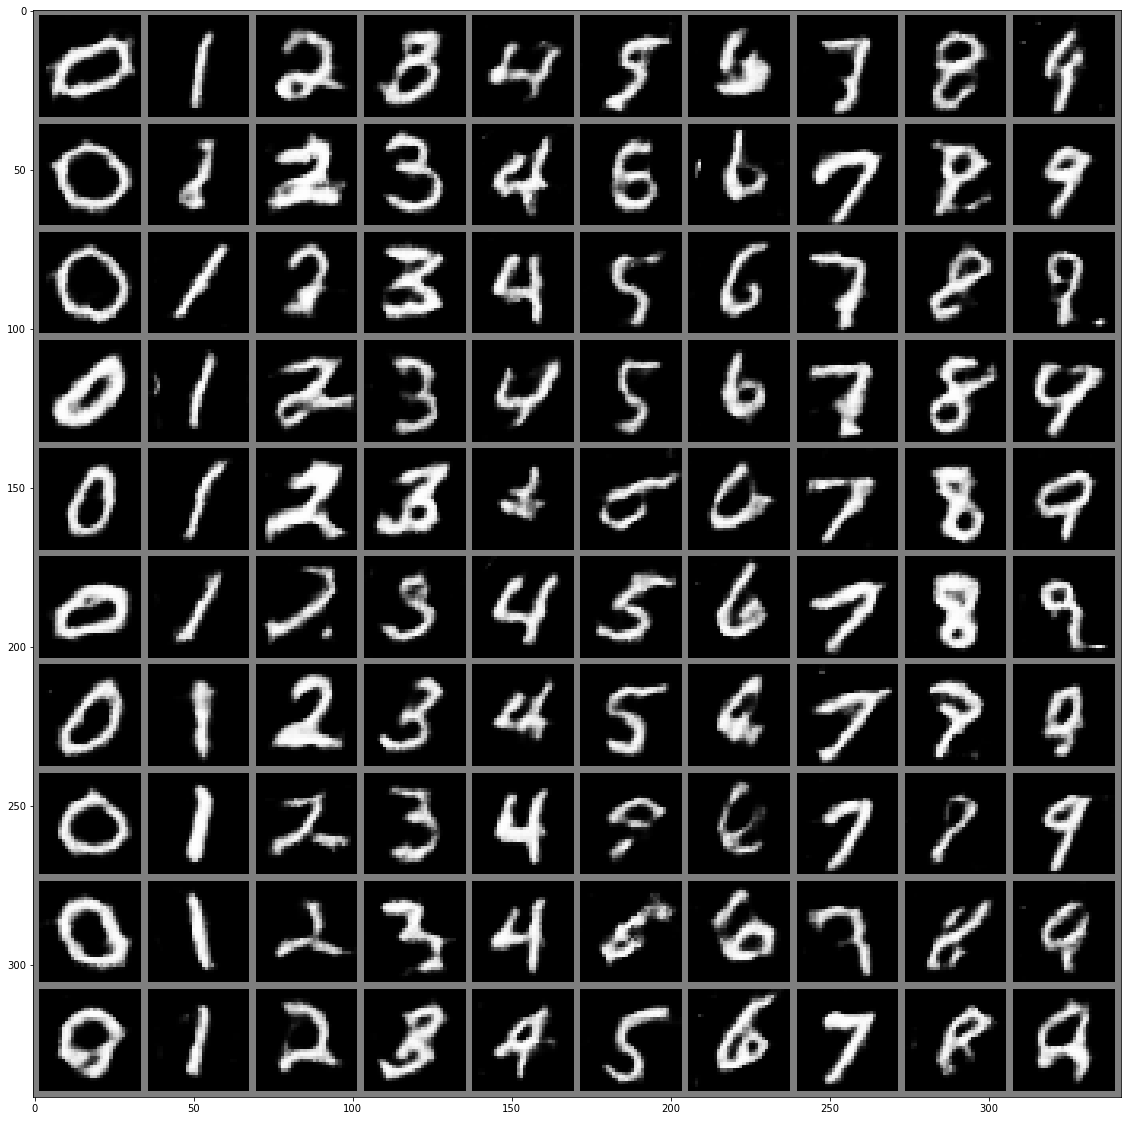

[Epoch 77/200] [Batch 64/468] [D loss: 0.249967, acc: 94%] [G loss: 1.732870]
[Epoch 77/200] [Batch 164/468] [D loss: 0.206390, acc: 94%] [G loss: 1.011608]
[Epoch 77/200] [Batch 264/468] [D loss: 0.196871, acc: 97%] [G loss: 1.406613]
[Epoch 77/200] [Batch 364/468] [D loss: 0.205892, acc: 92%] [G loss: 1.179157]
[Epoch 77/200] [Batch 464/468] [D loss: 0.311360, acc: 94%] [G loss: 0.510748]
[Epoch 78/200] [Batch 96/468] [D loss: 0.191757, acc: 98%] [G loss: 0.768503]
[Epoch 78/200] [Batch 196/468] [D loss: 0.297672, acc: 94%] [G loss: 1.610149]
[Epoch 78/200] [Batch 296/468] [D loss: 0.156235, acc: 96%] [G loss: 0.922395]
[Epoch 78/200] [Batch 396/468] [D loss: 0.198537, acc: 94%] [G loss: 1.123361]
[Epoch 79/200] [Batch 28/468] [D loss: 0.183322, acc: 94%] [G loss: 1.944324]
[Epoch 79/200] [Batch 128/468] [D loss: 0.153858, acc: 93%] [G loss: 1.096642]
[Epoch 79/200] [Batch 228/468] [D loss: 0.238173, acc: 93%] [G loss: 0.786520]
[Epoch 79/200] [Batch 328/468] [D loss: 0.257392, acc: 

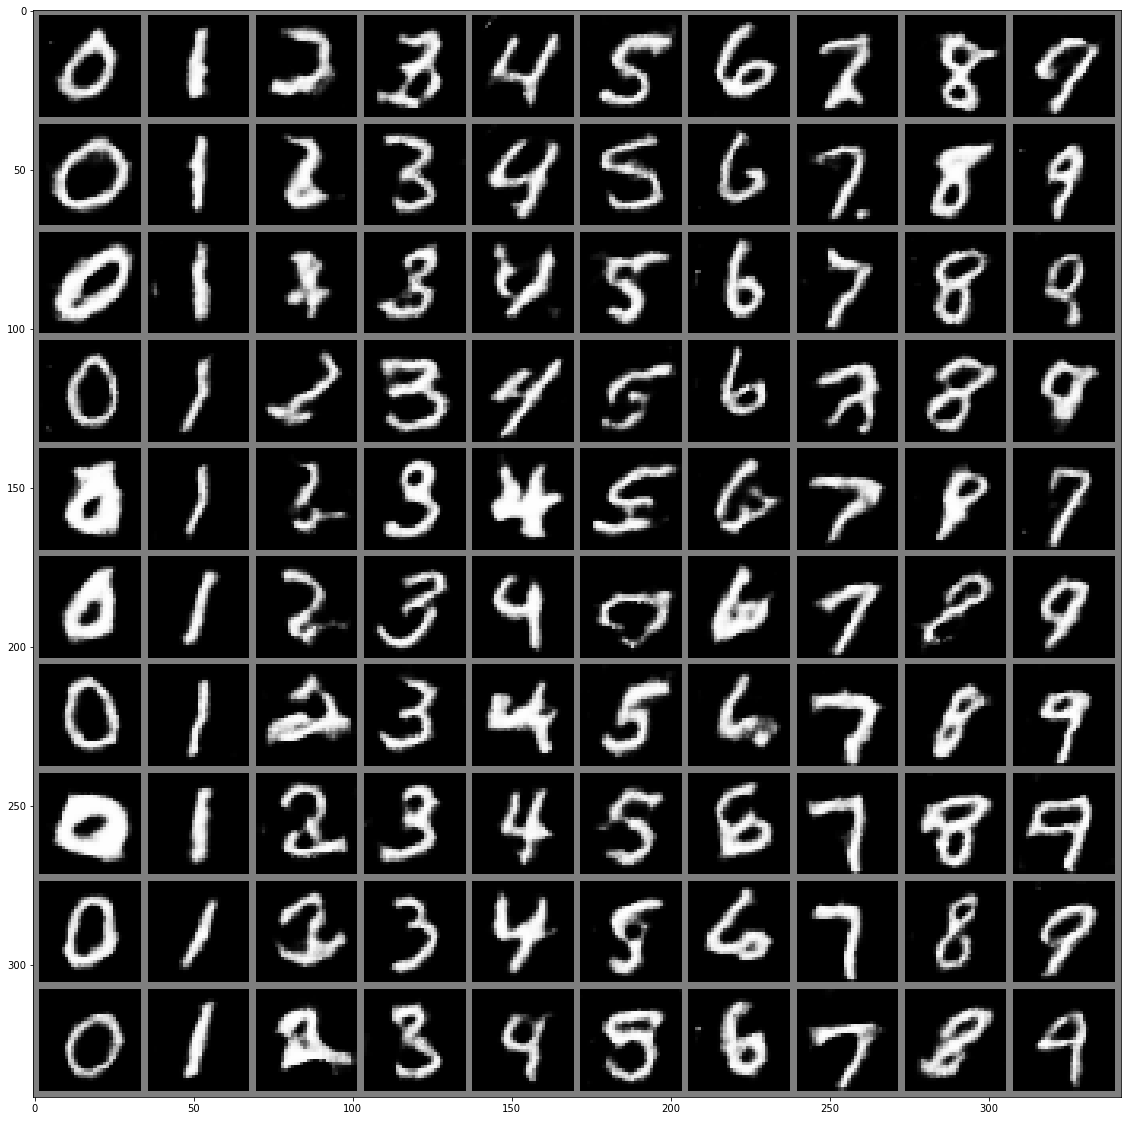

[Epoch 81/200] [Batch 192/468] [D loss: 0.188632, acc: 95%] [G loss: 1.472447]
[Epoch 81/200] [Batch 292/468] [D loss: 0.266873, acc: 96%] [G loss: 0.659470]
[Epoch 81/200] [Batch 392/468] [D loss: 0.212736, acc: 94%] [G loss: 1.927692]
[Epoch 82/200] [Batch 24/468] [D loss: 0.136625, acc: 98%] [G loss: 0.549161]
[Epoch 82/200] [Batch 124/468] [D loss: 0.293559, acc: 94%] [G loss: 1.415233]
[Epoch 82/200] [Batch 224/468] [D loss: 0.266457, acc: 96%] [G loss: 1.059395]
[Epoch 82/200] [Batch 324/468] [D loss: 0.130912, acc: 96%] [G loss: 1.049527]
[Epoch 82/200] [Batch 424/468] [D loss: 0.172953, acc: 95%] [G loss: 1.425901]
[Epoch 83/200] [Batch 56/468] [D loss: 0.191834, acc: 94%] [G loss: 0.812045]
[Epoch 83/200] [Batch 156/468] [D loss: 0.115149, acc: 96%] [G loss: 0.962079]
[Epoch 83/200] [Batch 256/468] [D loss: 0.180290, acc: 96%] [G loss: 0.476134]
[Epoch 83/200] [Batch 356/468] [D loss: 0.198820, acc: 95%] [G loss: 0.511752]
[Epoch 83/200] [Batch 456/468] [D loss: 0.206525, acc:

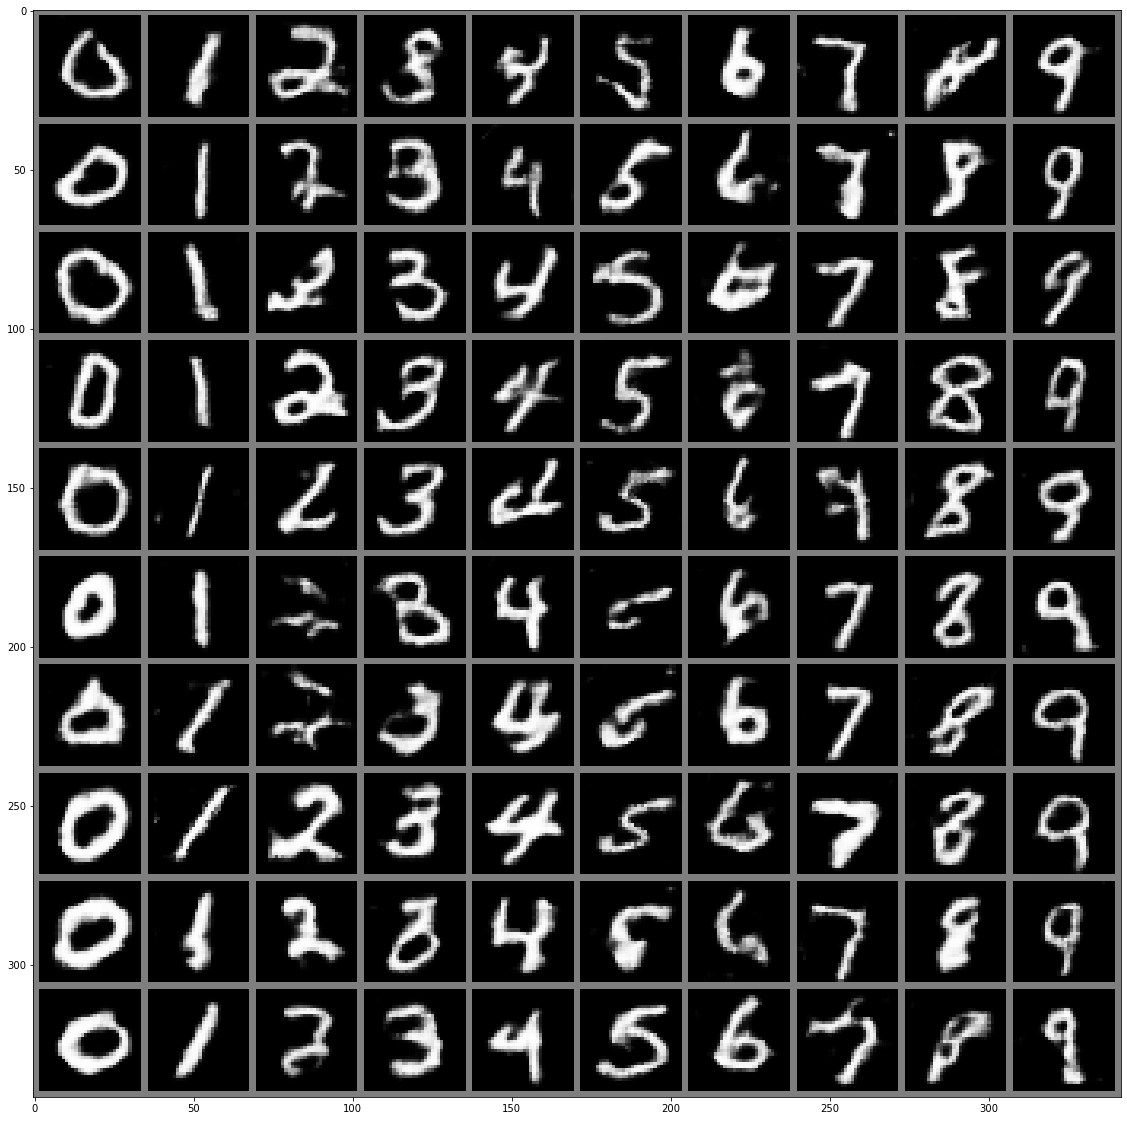

[Epoch 85/200] [Batch 320/468] [D loss: 0.116503, acc: 97%] [G loss: 0.866814]
[Epoch 85/200] [Batch 420/468] [D loss: 0.216186, acc: 94%] [G loss: 0.595697]
[Epoch 86/200] [Batch 52/468] [D loss: 0.242100, acc: 95%] [G loss: 1.322028]
[Epoch 86/200] [Batch 152/468] [D loss: 0.211265, acc: 94%] [G loss: 1.392729]
[Epoch 86/200] [Batch 252/468] [D loss: 0.147628, acc: 95%] [G loss: 1.924920]
[Epoch 86/200] [Batch 352/468] [D loss: 0.166356, acc: 94%] [G loss: 1.077920]
[Epoch 86/200] [Batch 452/468] [D loss: 0.264622, acc: 92%] [G loss: 0.402901]
[Epoch 87/200] [Batch 84/468] [D loss: 0.273035, acc: 94%] [G loss: 1.143878]
[Epoch 87/200] [Batch 184/468] [D loss: 0.186170, acc: 94%] [G loss: 0.774664]
[Epoch 87/200] [Batch 284/468] [D loss: 0.188172, acc: 95%] [G loss: 0.727362]
[Epoch 87/200] [Batch 384/468] [D loss: 0.175933, acc: 97%] [G loss: 0.524692]
[Epoch 88/200] [Batch 16/468] [D loss: 0.163088, acc: 96%] [G loss: 0.642432]
[Epoch 88/200] [Batch 116/468] [D loss: 0.166705, acc: 

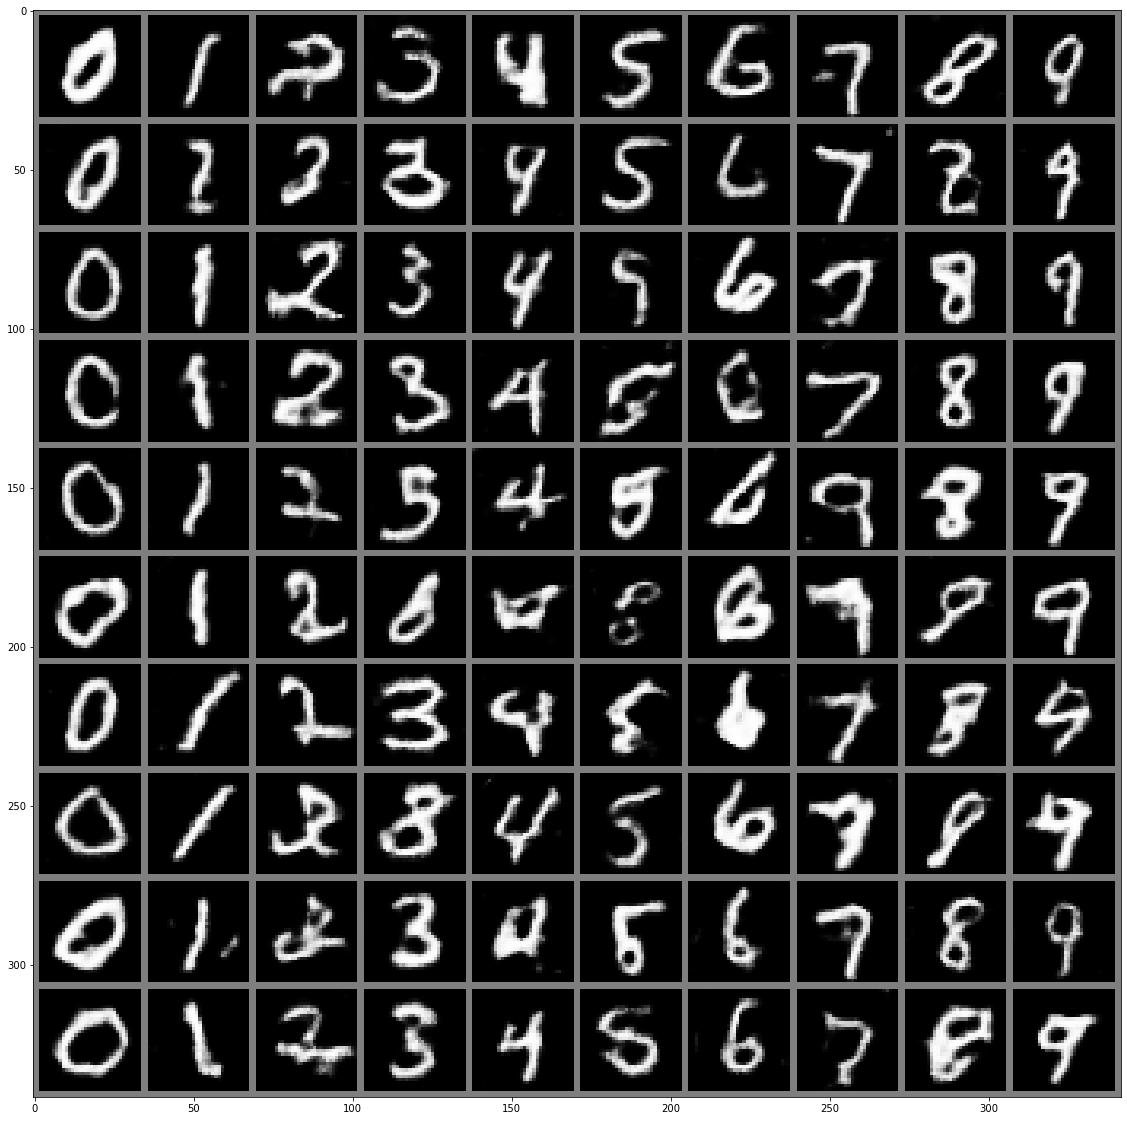

[Epoch 89/200] [Batch 448/468] [D loss: 0.134181, acc: 95%] [G loss: 1.063227]
[Epoch 90/200] [Batch 80/468] [D loss: 0.135415, acc: 96%] [G loss: 0.912997]
[Epoch 90/200] [Batch 180/468] [D loss: 0.268414, acc: 97%] [G loss: 0.512577]
[Epoch 90/200] [Batch 280/468] [D loss: 0.237013, acc: 93%] [G loss: 0.746539]
[Epoch 90/200] [Batch 380/468] [D loss: 0.202889, acc: 97%] [G loss: 0.664614]
[Epoch 91/200] [Batch 12/468] [D loss: 0.250260, acc: 94%] [G loss: 0.887172]
[Epoch 91/200] [Batch 112/468] [D loss: 0.194543, acc: 95%] [G loss: 0.825380]
[Epoch 91/200] [Batch 212/468] [D loss: 0.218924, acc: 94%] [G loss: 1.243924]
[Epoch 91/200] [Batch 312/468] [D loss: 0.115739, acc: 97%] [G loss: 0.607846]
[Epoch 91/200] [Batch 412/468] [D loss: 0.141258, acc: 95%] [G loss: 0.985608]
[Epoch 92/200] [Batch 44/468] [D loss: 0.170529, acc: 94%] [G loss: 1.232206]
[Epoch 92/200] [Batch 144/468] [D loss: 0.204057, acc: 96%] [G loss: 0.790922]
[Epoch 92/200] [Batch 244/468] [D loss: 0.203145, acc: 

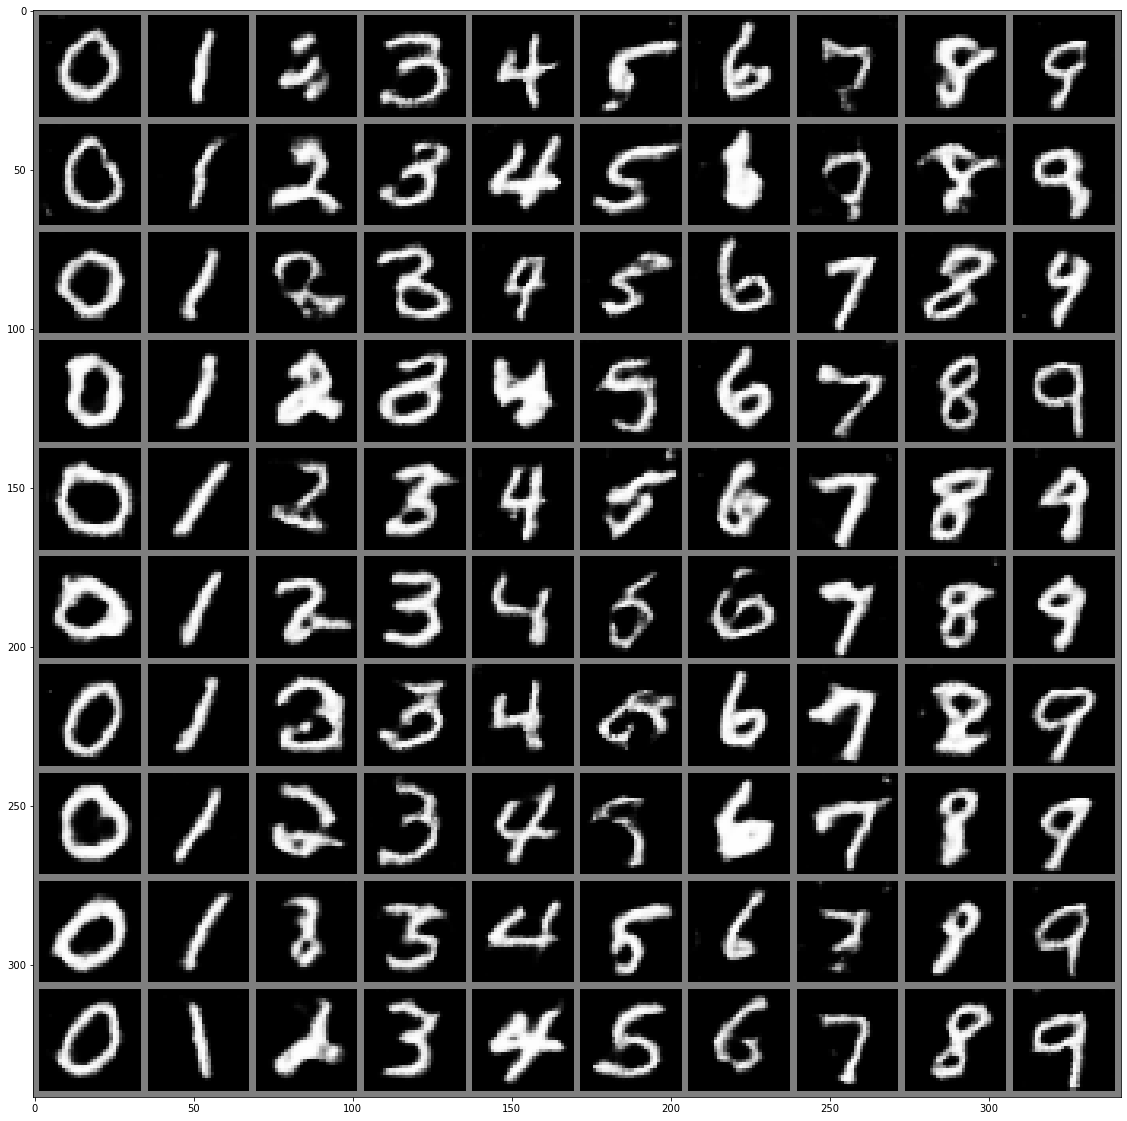

[Epoch 94/200] [Batch 108/468] [D loss: 0.274560, acc: 96%] [G loss: 0.969160]
[Epoch 94/200] [Batch 208/468] [D loss: 0.180057, acc: 95%] [G loss: 1.292415]
[Epoch 94/200] [Batch 308/468] [D loss: 0.192811, acc: 95%] [G loss: 1.392309]
[Epoch 94/200] [Batch 408/468] [D loss: 0.163040, acc: 95%] [G loss: 0.846123]
[Epoch 95/200] [Batch 40/468] [D loss: 0.267400, acc: 95%] [G loss: 1.793538]
[Epoch 95/200] [Batch 140/468] [D loss: 0.159340, acc: 96%] [G loss: 1.158414]
[Epoch 95/200] [Batch 240/468] [D loss: 0.381581, acc: 95%] [G loss: 1.370781]
[Epoch 95/200] [Batch 340/468] [D loss: 0.205526, acc: 96%] [G loss: 1.083744]
[Epoch 95/200] [Batch 440/468] [D loss: 0.188974, acc: 95%] [G loss: 1.372387]
[Epoch 96/200] [Batch 72/468] [D loss: 0.311048, acc: 95%] [G loss: 1.013775]
[Epoch 96/200] [Batch 172/468] [D loss: 0.233435, acc: 94%] [G loss: 1.696516]
[Epoch 96/200] [Batch 272/468] [D loss: 0.304325, acc: 94%] [G loss: 1.045913]
[Epoch 96/200] [Batch 372/468] [D loss: 0.277534, acc:

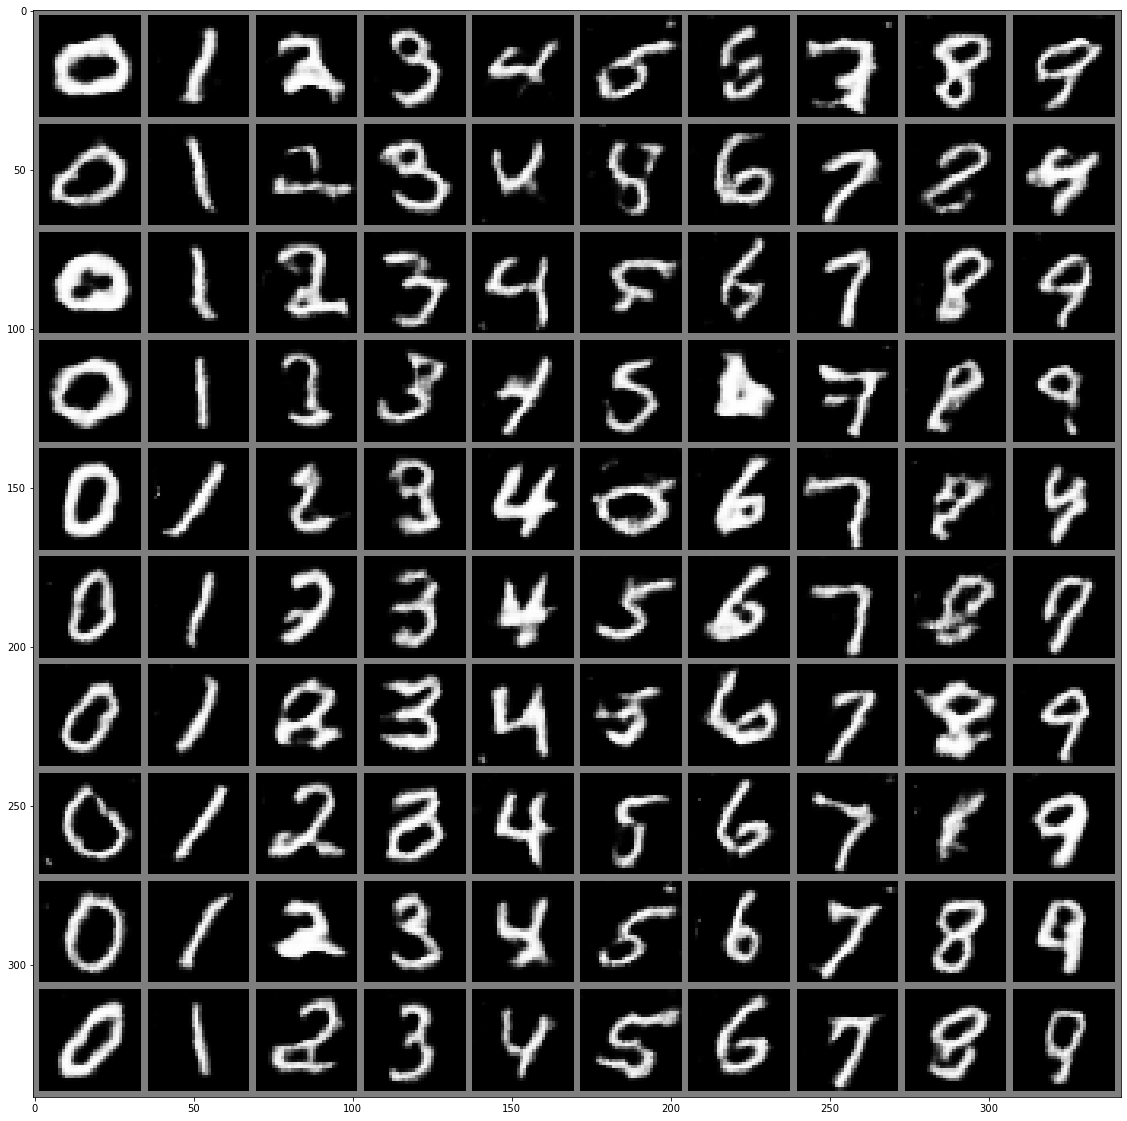

[Epoch 98/200] [Batch 236/468] [D loss: 0.207896, acc: 94%] [G loss: 1.543375]
[Epoch 98/200] [Batch 336/468] [D loss: 0.146481, acc: 96%] [G loss: 0.863452]
[Epoch 98/200] [Batch 436/468] [D loss: 0.180316, acc: 98%] [G loss: 0.864216]
[Epoch 99/200] [Batch 68/468] [D loss: 0.225646, acc: 93%] [G loss: 1.476915]
[Epoch 99/200] [Batch 168/468] [D loss: 0.132603, acc: 97%] [G loss: 1.261251]
[Epoch 99/200] [Batch 268/468] [D loss: 0.124866, acc: 95%] [G loss: 1.429784]
[Epoch 99/200] [Batch 368/468] [D loss: 0.229377, acc: 94%] [G loss: 1.820170]
[Epoch 100/200] [Batch 0/468] [D loss: 0.263011, acc: 94%] [G loss: 1.298459]
[Epoch 100/200] [Batch 100/468] [D loss: 0.186937, acc: 96%] [G loss: 0.718836]
[Epoch 100/200] [Batch 200/468] [D loss: 0.207720, acc: 96%] [G loss: 0.548501]
[Epoch 100/200] [Batch 300/468] [D loss: 0.162522, acc: 95%] [G loss: 1.093853]
[Epoch 100/200] [Batch 400/468] [D loss: 0.211079, acc: 94%] [G loss: 0.961797]
[Epoch 101/200] [Batch 32/468] [D loss: 0.157650, 

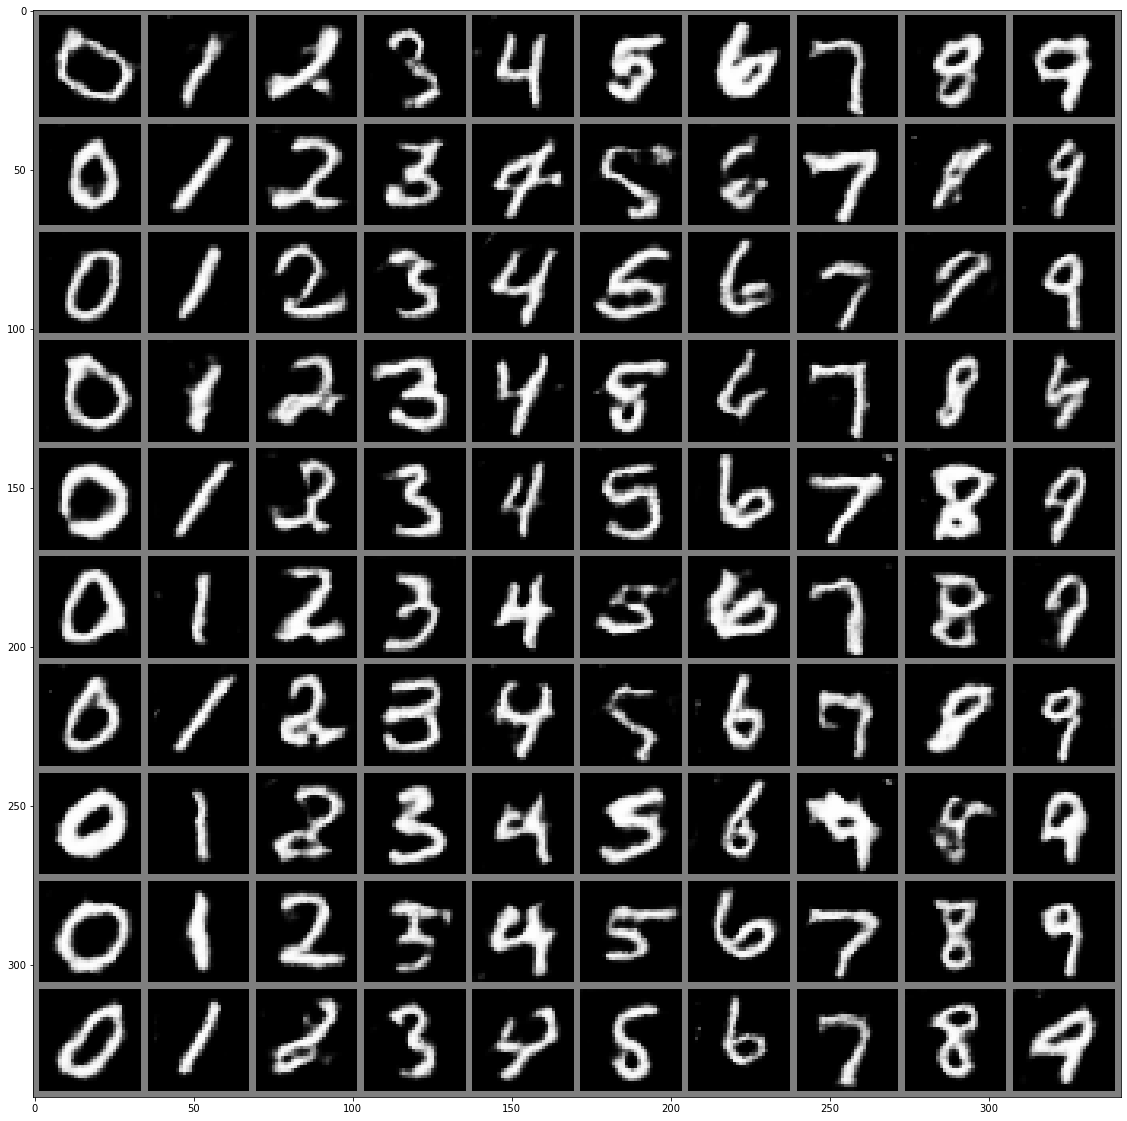

[Epoch 102/200] [Batch 364/468] [D loss: 0.216915, acc: 96%] [G loss: 1.200028]
[Epoch 102/200] [Batch 464/468] [D loss: 0.182284, acc: 95%] [G loss: 1.822234]
[Epoch 103/200] [Batch 96/468] [D loss: 0.123956, acc: 94%] [G loss: 1.322951]
[Epoch 103/200] [Batch 196/468] [D loss: 0.276922, acc: 97%] [G loss: 2.269213]
[Epoch 103/200] [Batch 296/468] [D loss: 0.142418, acc: 96%] [G loss: 0.882767]
[Epoch 103/200] [Batch 396/468] [D loss: 0.114380, acc: 97%] [G loss: 1.094041]
[Epoch 104/200] [Batch 28/468] [D loss: 0.167938, acc: 97%] [G loss: 1.186108]
[Epoch 104/200] [Batch 128/468] [D loss: 0.220960, acc: 97%] [G loss: 0.540609]
[Epoch 104/200] [Batch 228/468] [D loss: 0.162819, acc: 98%] [G loss: 0.950695]
[Epoch 104/200] [Batch 328/468] [D loss: 0.168317, acc: 97%] [G loss: 1.101645]
[Epoch 104/200] [Batch 428/468] [D loss: 0.198080, acc: 95%] [G loss: 1.168218]
[Epoch 105/200] [Batch 60/468] [D loss: 0.164644, acc: 95%] [G loss: 1.274410]
[Epoch 105/200] [Batch 160/468] [D loss: 0.

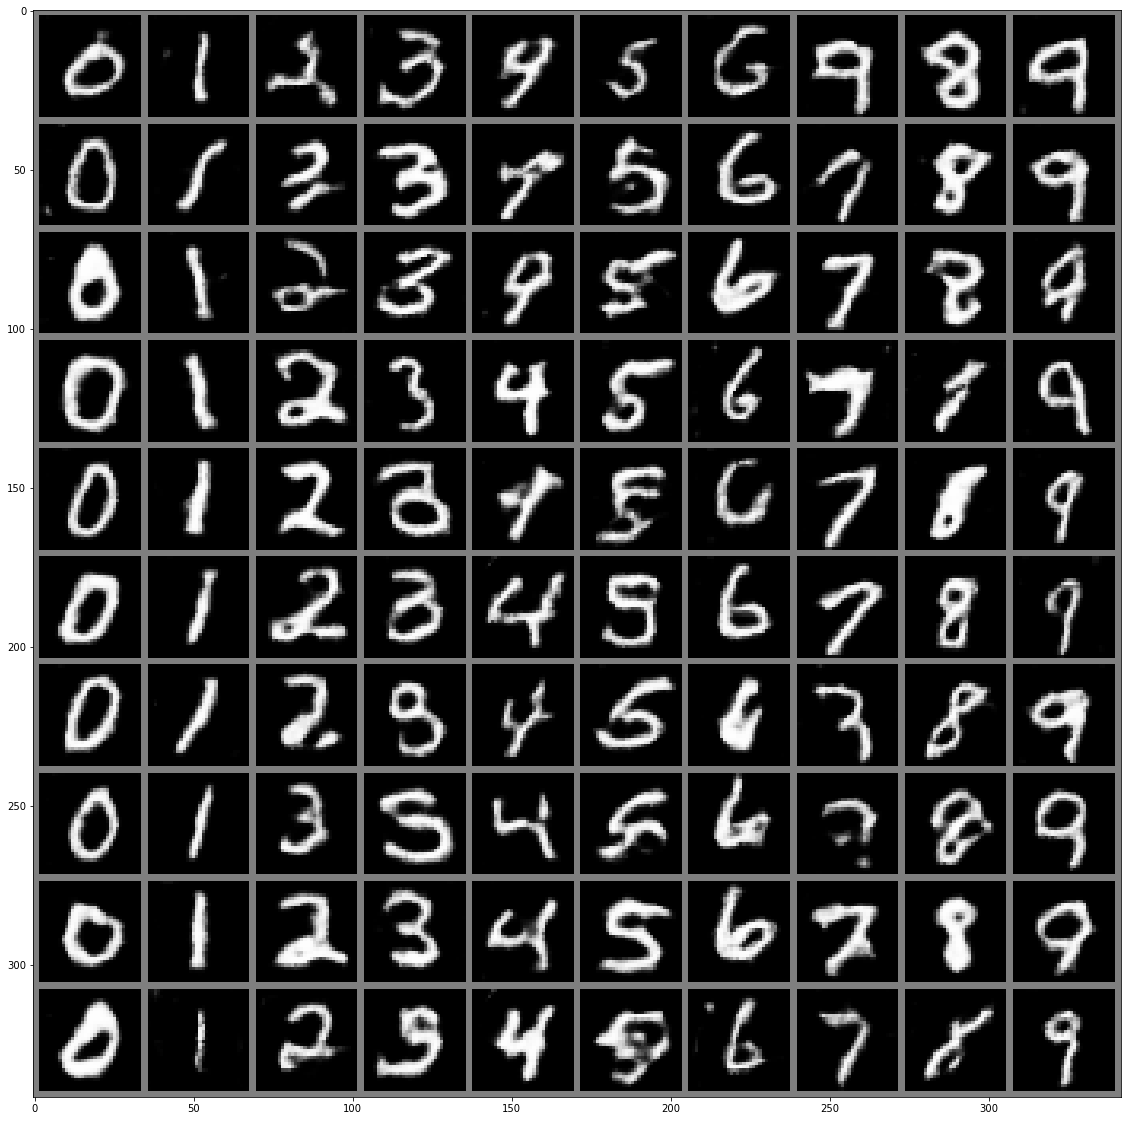

[Epoch 107/200] [Batch 24/468] [D loss: 0.187369, acc: 96%] [G loss: 0.585416]
[Epoch 107/200] [Batch 124/468] [D loss: 0.214140, acc: 96%] [G loss: 1.404533]
[Epoch 107/200] [Batch 224/468] [D loss: 0.142129, acc: 95%] [G loss: 0.842088]
[Epoch 107/200] [Batch 324/468] [D loss: 0.156990, acc: 96%] [G loss: 1.565146]
[Epoch 107/200] [Batch 424/468] [D loss: 0.264518, acc: 95%] [G loss: 0.621074]
[Epoch 108/200] [Batch 56/468] [D loss: 0.244484, acc: 96%] [G loss: 1.495090]
[Epoch 108/200] [Batch 156/468] [D loss: 0.220603, acc: 96%] [G loss: 0.412724]
[Epoch 108/200] [Batch 256/468] [D loss: 0.163571, acc: 95%] [G loss: 1.552393]
[Epoch 108/200] [Batch 356/468] [D loss: 0.119017, acc: 97%] [G loss: 1.142044]
[Epoch 108/200] [Batch 456/468] [D loss: 0.114250, acc: 95%] [G loss: 1.487809]
[Epoch 109/200] [Batch 88/468] [D loss: 0.089900, acc: 98%] [G loss: 0.766874]
[Epoch 109/200] [Batch 188/468] [D loss: 0.188922, acc: 96%] [G loss: 0.452641]
[Epoch 109/200] [Batch 288/468] [D loss: 0.

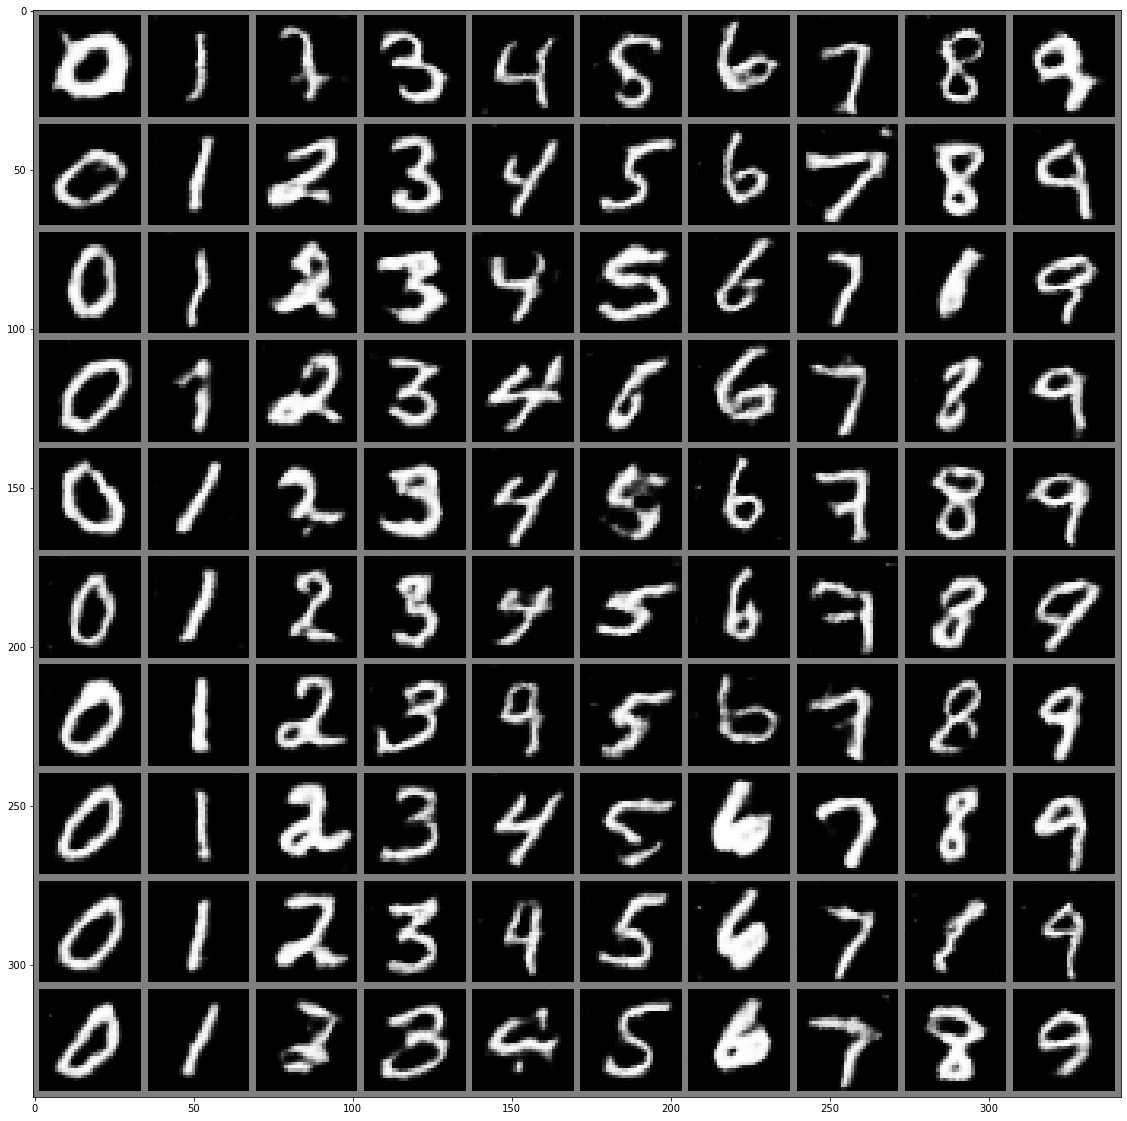

[Epoch 111/200] [Batch 152/468] [D loss: 0.096351, acc: 98%] [G loss: 1.200499]
[Epoch 111/200] [Batch 252/468] [D loss: 0.373121, acc: 94%] [G loss: 1.203598]
[Epoch 111/200] [Batch 352/468] [D loss: 0.195166, acc: 95%] [G loss: 1.315775]
[Epoch 111/200] [Batch 452/468] [D loss: 0.144629, acc: 99%] [G loss: 0.987906]
[Epoch 112/200] [Batch 84/468] [D loss: 0.141912, acc: 95%] [G loss: 1.712240]
[Epoch 112/200] [Batch 184/468] [D loss: 0.232231, acc: 96%] [G loss: 0.933017]
[Epoch 112/200] [Batch 284/468] [D loss: 0.284391, acc: 98%] [G loss: 0.426178]
[Epoch 112/200] [Batch 384/468] [D loss: 0.189216, acc: 96%] [G loss: 1.109994]
[Epoch 113/200] [Batch 16/468] [D loss: 0.202939, acc: 96%] [G loss: 1.408538]
[Epoch 113/200] [Batch 116/468] [D loss: 0.169340, acc: 96%] [G loss: 0.451169]
[Epoch 113/200] [Batch 216/468] [D loss: 0.185802, acc: 96%] [G loss: 1.469324]
[Epoch 113/200] [Batch 316/468] [D loss: 0.165042, acc: 94%] [G loss: 1.105051]
[Epoch 113/200] [Batch 416/468] [D loss: 0

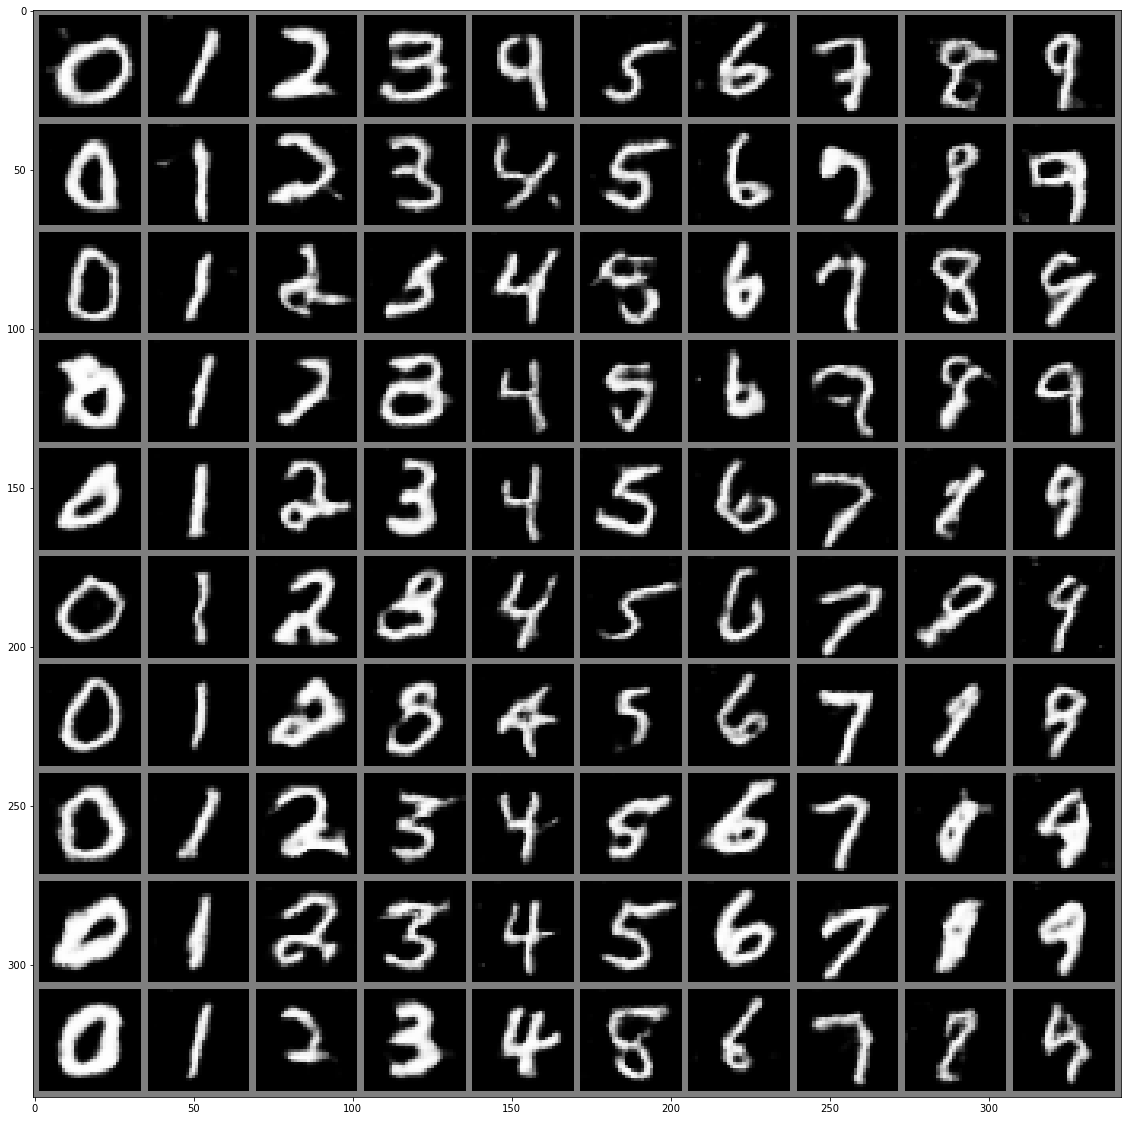

[Epoch 115/200] [Batch 280/468] [D loss: 0.197750, acc: 96%] [G loss: 1.176020]
[Epoch 115/200] [Batch 380/468] [D loss: 0.194209, acc: 97%] [G loss: 0.806095]
[Epoch 116/200] [Batch 12/468] [D loss: 0.230262, acc: 95%] [G loss: 0.891615]
[Epoch 116/200] [Batch 112/468] [D loss: 0.099526, acc: 94%] [G loss: 1.802316]
[Epoch 116/200] [Batch 212/468] [D loss: 0.349743, acc: 95%] [G loss: 1.539042]
[Epoch 116/200] [Batch 312/468] [D loss: 0.180923, acc: 96%] [G loss: 1.117764]
[Epoch 116/200] [Batch 412/468] [D loss: 0.173881, acc: 95%] [G loss: 0.784384]
[Epoch 117/200] [Batch 44/468] [D loss: 0.148891, acc: 95%] [G loss: 1.003502]
[Epoch 117/200] [Batch 144/468] [D loss: 0.138132, acc: 95%] [G loss: 0.350145]
[Epoch 117/200] [Batch 244/468] [D loss: 0.125441, acc: 96%] [G loss: 1.224159]
[Epoch 117/200] [Batch 344/468] [D loss: 0.288960, acc: 95%] [G loss: 1.662070]
[Epoch 117/200] [Batch 444/468] [D loss: 0.154736, acc: 95%] [G loss: 1.147973]
[Epoch 118/200] [Batch 76/468] [D loss: 0.

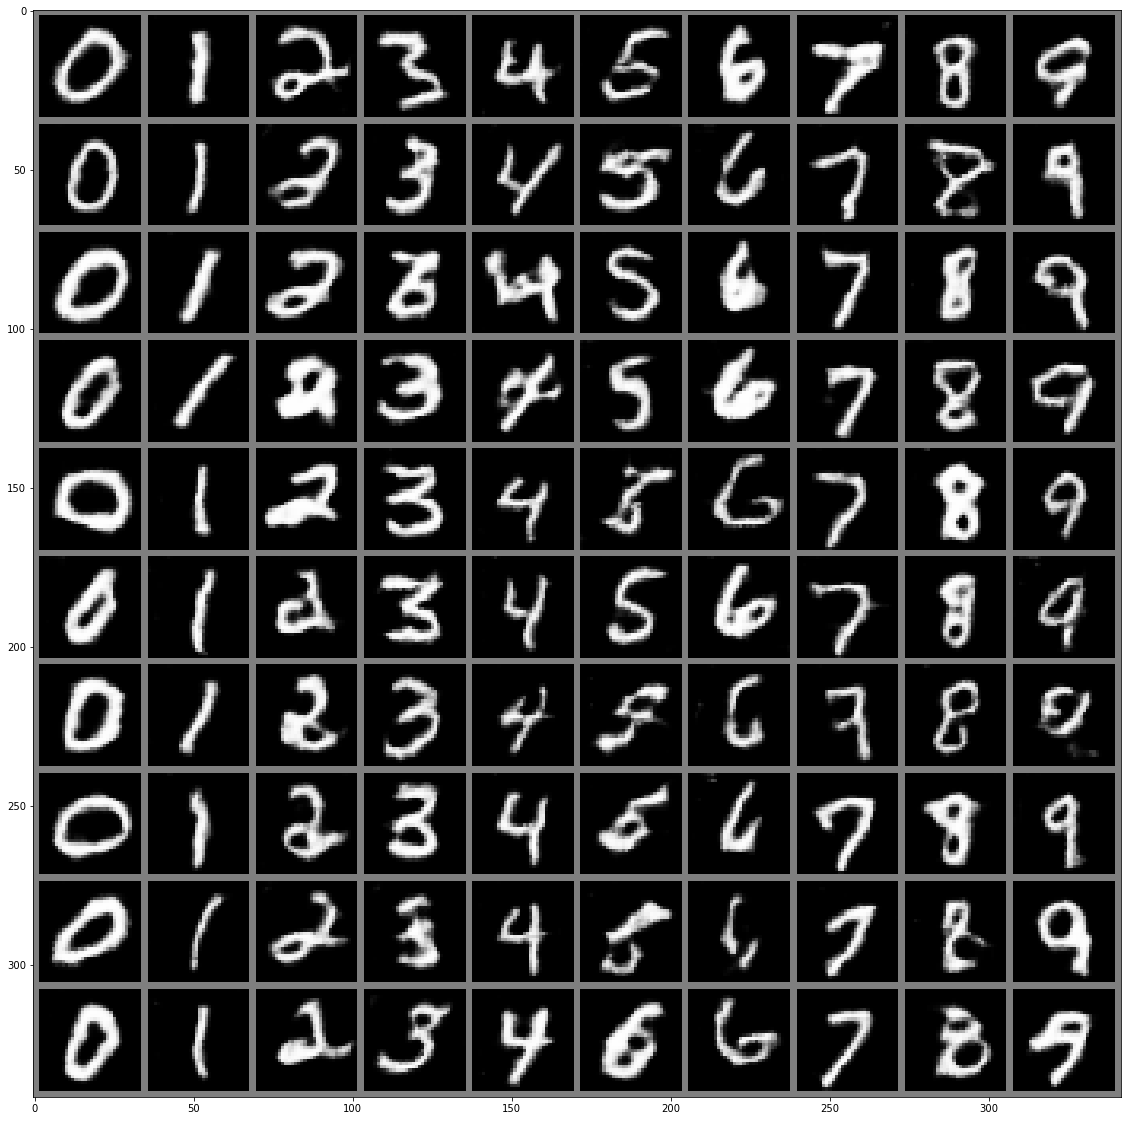

[Epoch 119/200] [Batch 408/468] [D loss: 0.150537, acc: 96%] [G loss: 0.979886]
[Epoch 120/200] [Batch 40/468] [D loss: 0.129468, acc: 96%] [G loss: 1.334219]
[Epoch 120/200] [Batch 140/468] [D loss: 0.125319, acc: 98%] [G loss: 1.513230]
[Epoch 120/200] [Batch 240/468] [D loss: 0.112836, acc: 96%] [G loss: 0.408084]
[Epoch 120/200] [Batch 340/468] [D loss: 0.169565, acc: 93%] [G loss: 1.642219]
[Epoch 120/200] [Batch 440/468] [D loss: 0.256783, acc: 95%] [G loss: 1.333642]
[Epoch 121/200] [Batch 72/468] [D loss: 0.194843, acc: 97%] [G loss: 1.788781]
[Epoch 121/200] [Batch 172/468] [D loss: 0.158215, acc: 96%] [G loss: 1.693116]
[Epoch 121/200] [Batch 272/468] [D loss: 0.237707, acc: 98%] [G loss: 1.303717]
[Epoch 121/200] [Batch 372/468] [D loss: 0.137469, acc: 96%] [G loss: 0.843387]
[Epoch 122/200] [Batch 4/468] [D loss: 0.299784, acc: 96%] [G loss: 0.721922]
[Epoch 122/200] [Batch 104/468] [D loss: 0.132673, acc: 96%] [G loss: 1.321765]
[Epoch 122/200] [Batch 204/468] [D loss: 0.3

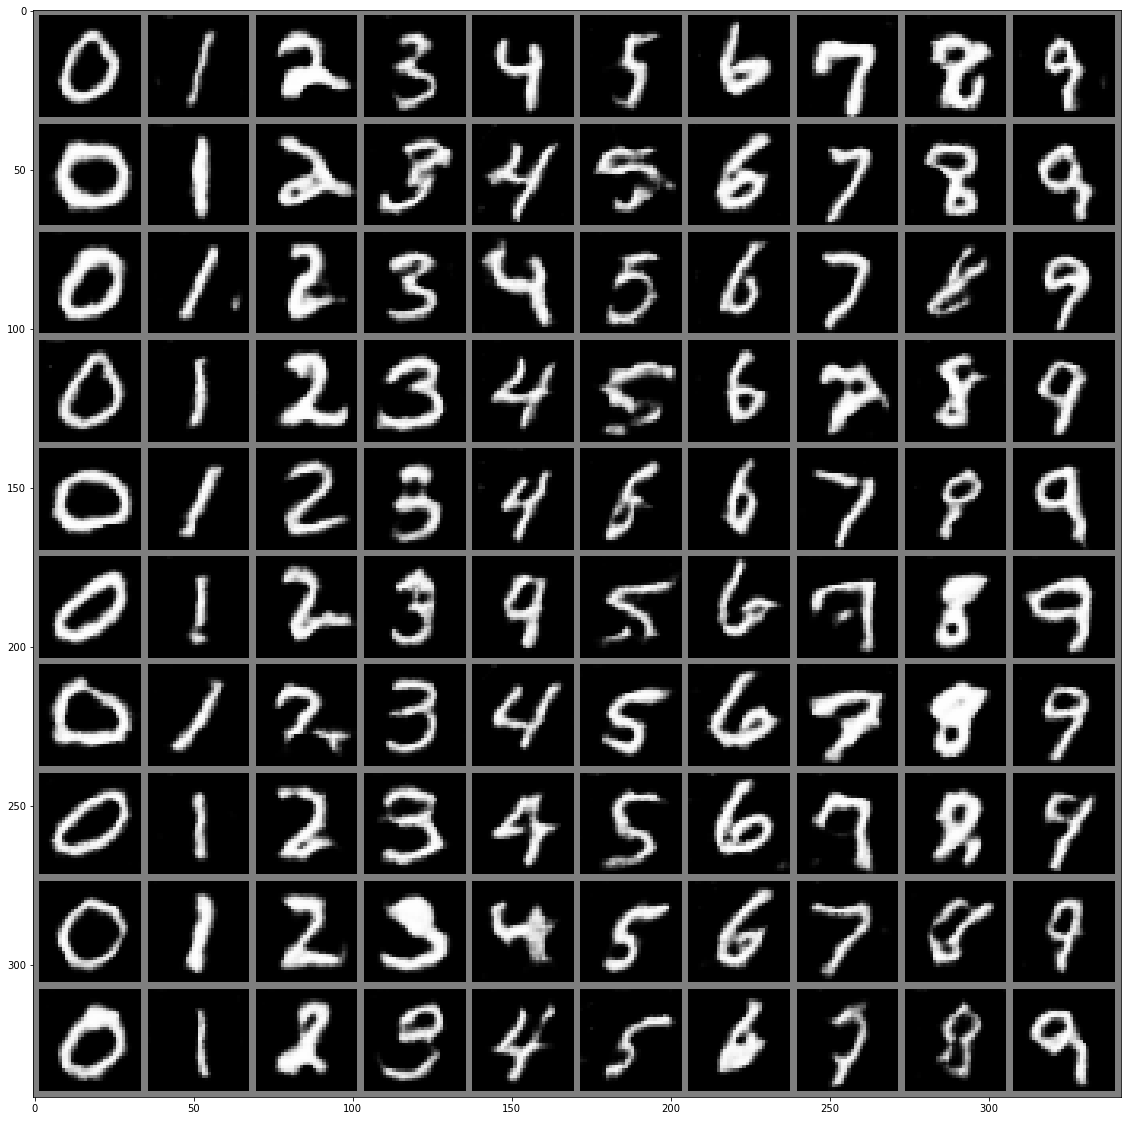

[Epoch 124/200] [Batch 68/468] [D loss: 0.251656, acc: 96%] [G loss: 0.791854]
[Epoch 124/200] [Batch 168/468] [D loss: 0.174699, acc: 96%] [G loss: 1.456051]
[Epoch 124/200] [Batch 268/468] [D loss: 0.318109, acc: 97%] [G loss: 1.137787]
[Epoch 124/200] [Batch 368/468] [D loss: 0.193478, acc: 95%] [G loss: 1.008952]
[Epoch 125/200] [Batch 0/468] [D loss: 0.202870, acc: 96%] [G loss: 1.653095]
[Epoch 125/200] [Batch 100/468] [D loss: 0.265915, acc: 96%] [G loss: 1.094595]
[Epoch 125/200] [Batch 200/468] [D loss: 0.176449, acc: 95%] [G loss: 0.752045]
[Epoch 125/200] [Batch 300/468] [D loss: 0.173218, acc: 96%] [G loss: 1.332627]
[Epoch 125/200] [Batch 400/468] [D loss: 0.175461, acc: 96%] [G loss: 1.522001]
[Epoch 126/200] [Batch 32/468] [D loss: 0.273115, acc: 96%] [G loss: 0.673556]
[Epoch 126/200] [Batch 132/468] [D loss: 0.335161, acc: 95%] [G loss: 1.173592]
[Epoch 126/200] [Batch 232/468] [D loss: 0.212223, acc: 95%] [G loss: 0.976588]
[Epoch 126/200] [Batch 332/468] [D loss: 0.2

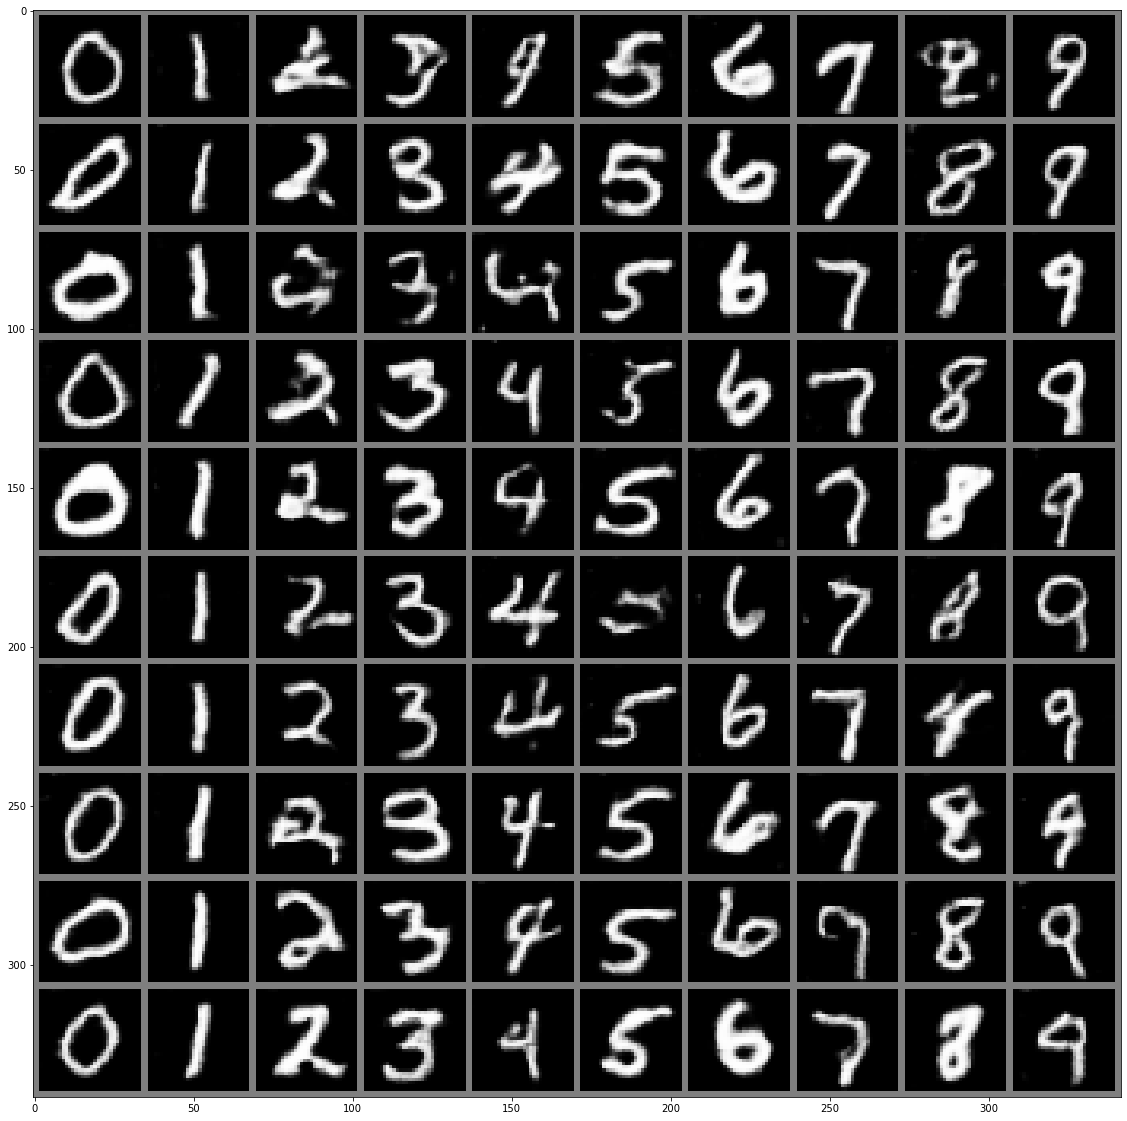

[Epoch 128/200] [Batch 196/468] [D loss: 0.260960, acc: 95%] [G loss: 0.710403]
[Epoch 128/200] [Batch 296/468] [D loss: 0.123473, acc: 98%] [G loss: 1.229279]
[Epoch 128/200] [Batch 396/468] [D loss: 0.173099, acc: 95%] [G loss: 0.967002]
[Epoch 129/200] [Batch 28/468] [D loss: 0.194858, acc: 96%] [G loss: 1.152663]
[Epoch 129/200] [Batch 128/468] [D loss: 0.128687, acc: 96%] [G loss: 0.318471]
[Epoch 129/200] [Batch 228/468] [D loss: 0.205396, acc: 96%] [G loss: 1.532560]
[Epoch 129/200] [Batch 328/468] [D loss: 0.143849, acc: 94%] [G loss: 1.529911]
[Epoch 129/200] [Batch 428/468] [D loss: 0.232295, acc: 98%] [G loss: 0.623347]
[Epoch 130/200] [Batch 60/468] [D loss: 0.139759, acc: 96%] [G loss: 1.106867]
[Epoch 130/200] [Batch 160/468] [D loss: 0.167377, acc: 94%] [G loss: 1.146729]
[Epoch 130/200] [Batch 260/468] [D loss: 0.095647, acc: 95%] [G loss: 0.955216]
[Epoch 130/200] [Batch 360/468] [D loss: 0.175321, acc: 93%] [G loss: 1.254282]
[Epoch 130/200] [Batch 460/468] [D loss: 0

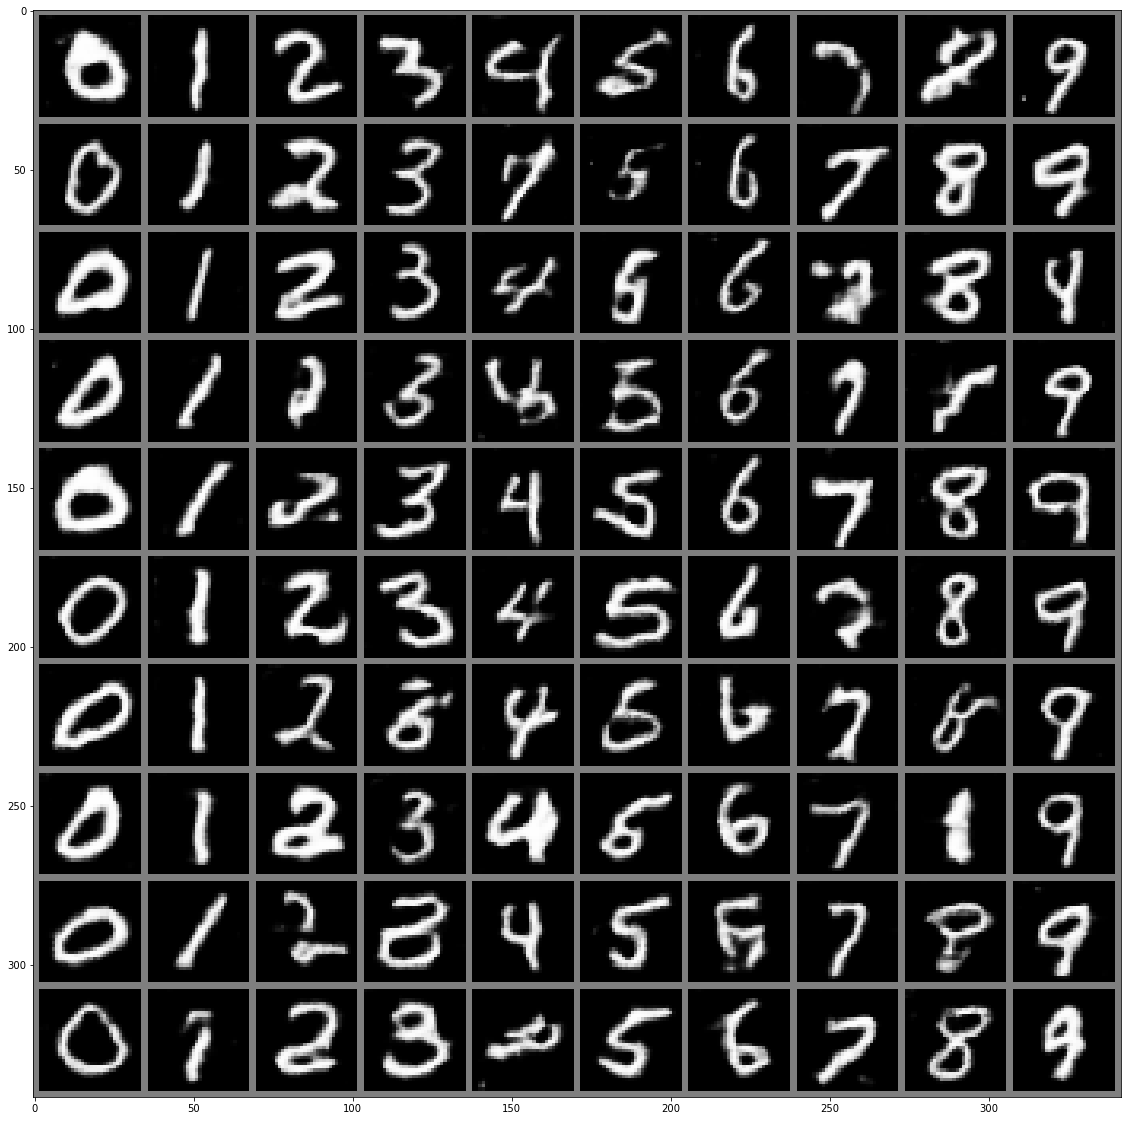

[Epoch 132/200] [Batch 324/468] [D loss: 0.161881, acc: 96%] [G loss: 0.541233]
[Epoch 132/200] [Batch 424/468] [D loss: 0.113138, acc: 95%] [G loss: 1.633425]
[Epoch 133/200] [Batch 56/468] [D loss: 0.132749, acc: 96%] [G loss: 0.959632]
[Epoch 133/200] [Batch 156/468] [D loss: 0.196696, acc: 96%] [G loss: 1.150776]
[Epoch 133/200] [Batch 256/468] [D loss: 0.121256, acc: 97%] [G loss: 0.590951]
[Epoch 133/200] [Batch 356/468] [D loss: 0.132155, acc: 95%] [G loss: 0.949689]
[Epoch 133/200] [Batch 456/468] [D loss: 0.167763, acc: 95%] [G loss: 0.696076]
[Epoch 134/200] [Batch 88/468] [D loss: 0.190391, acc: 94%] [G loss: 0.332205]
[Epoch 134/200] [Batch 188/468] [D loss: 0.148106, acc: 95%] [G loss: 0.533982]
[Epoch 134/200] [Batch 288/468] [D loss: 0.249254, acc: 94%] [G loss: 1.420996]
[Epoch 134/200] [Batch 388/468] [D loss: 0.204957, acc: 96%] [G loss: 0.873342]
[Epoch 135/200] [Batch 20/468] [D loss: 0.211634, acc: 95%] [G loss: 0.692046]
[Epoch 135/200] [Batch 120/468] [D loss: 0.

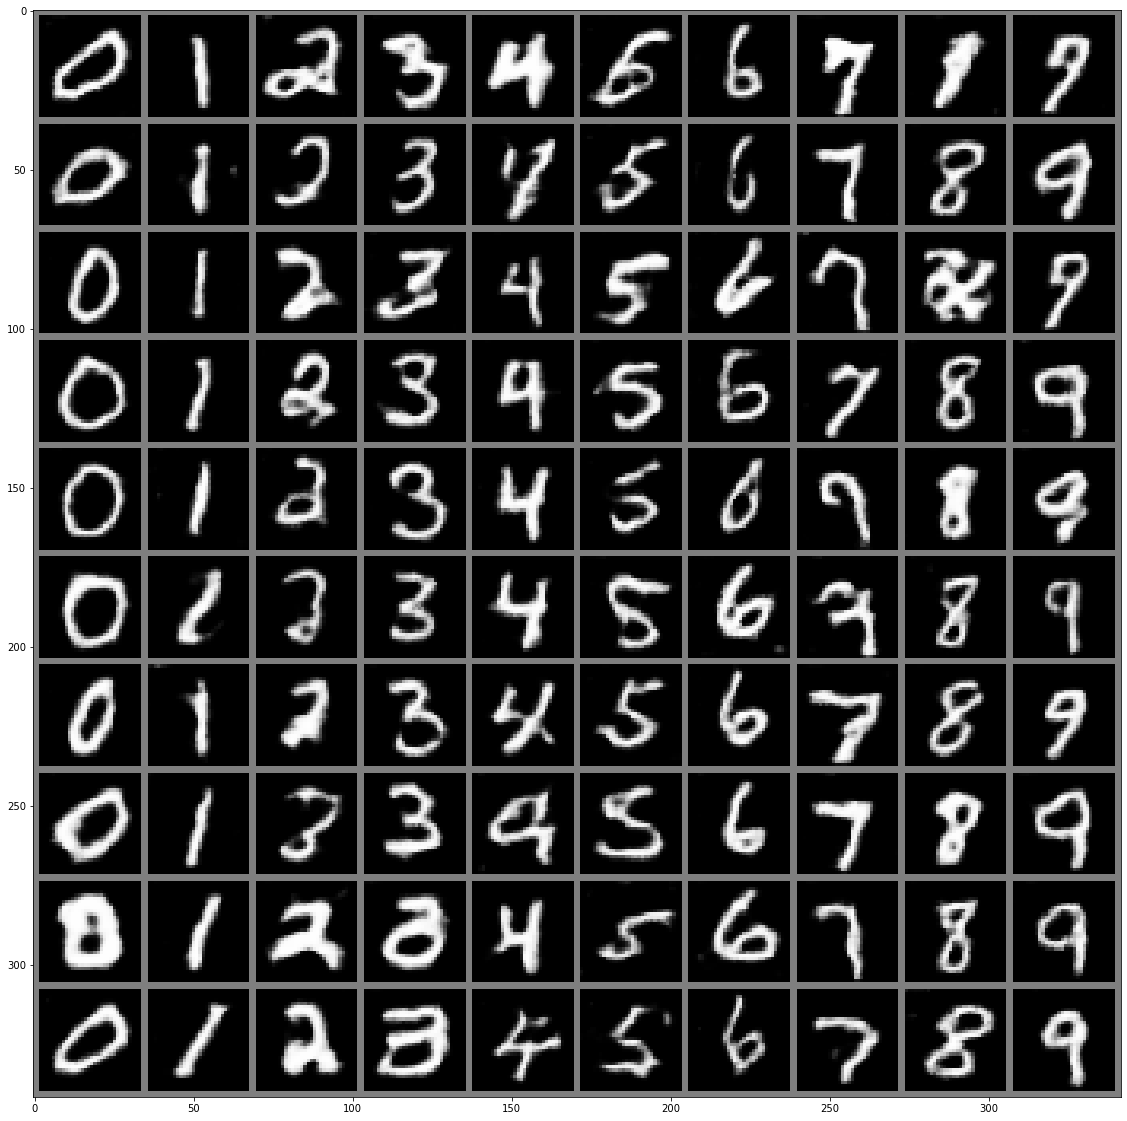

[Epoch 136/200] [Batch 452/468] [D loss: 0.279684, acc: 98%] [G loss: 0.414121]
[Epoch 137/200] [Batch 84/468] [D loss: 0.190291, acc: 93%] [G loss: 0.872386]
[Epoch 137/200] [Batch 184/468] [D loss: 0.178523, acc: 96%] [G loss: 1.497437]
[Epoch 137/200] [Batch 284/468] [D loss: 0.155591, acc: 96%] [G loss: 1.014961]
[Epoch 137/200] [Batch 384/468] [D loss: 0.179335, acc: 96%] [G loss: 0.790934]
[Epoch 138/200] [Batch 16/468] [D loss: 0.159908, acc: 97%] [G loss: 1.169804]
[Epoch 138/200] [Batch 116/468] [D loss: 0.186969, acc: 95%] [G loss: 0.644864]
[Epoch 138/200] [Batch 216/468] [D loss: 0.158965, acc: 96%] [G loss: 0.316623]
[Epoch 138/200] [Batch 316/468] [D loss: 0.277239, acc: 92%] [G loss: 1.444172]
[Epoch 138/200] [Batch 416/468] [D loss: 0.239131, acc: 95%] [G loss: 0.589005]
[Epoch 139/200] [Batch 48/468] [D loss: 0.251944, acc: 96%] [G loss: 0.999073]
[Epoch 139/200] [Batch 148/468] [D loss: 0.201008, acc: 94%] [G loss: 0.939736]
[Epoch 139/200] [Batch 248/468] [D loss: 0.

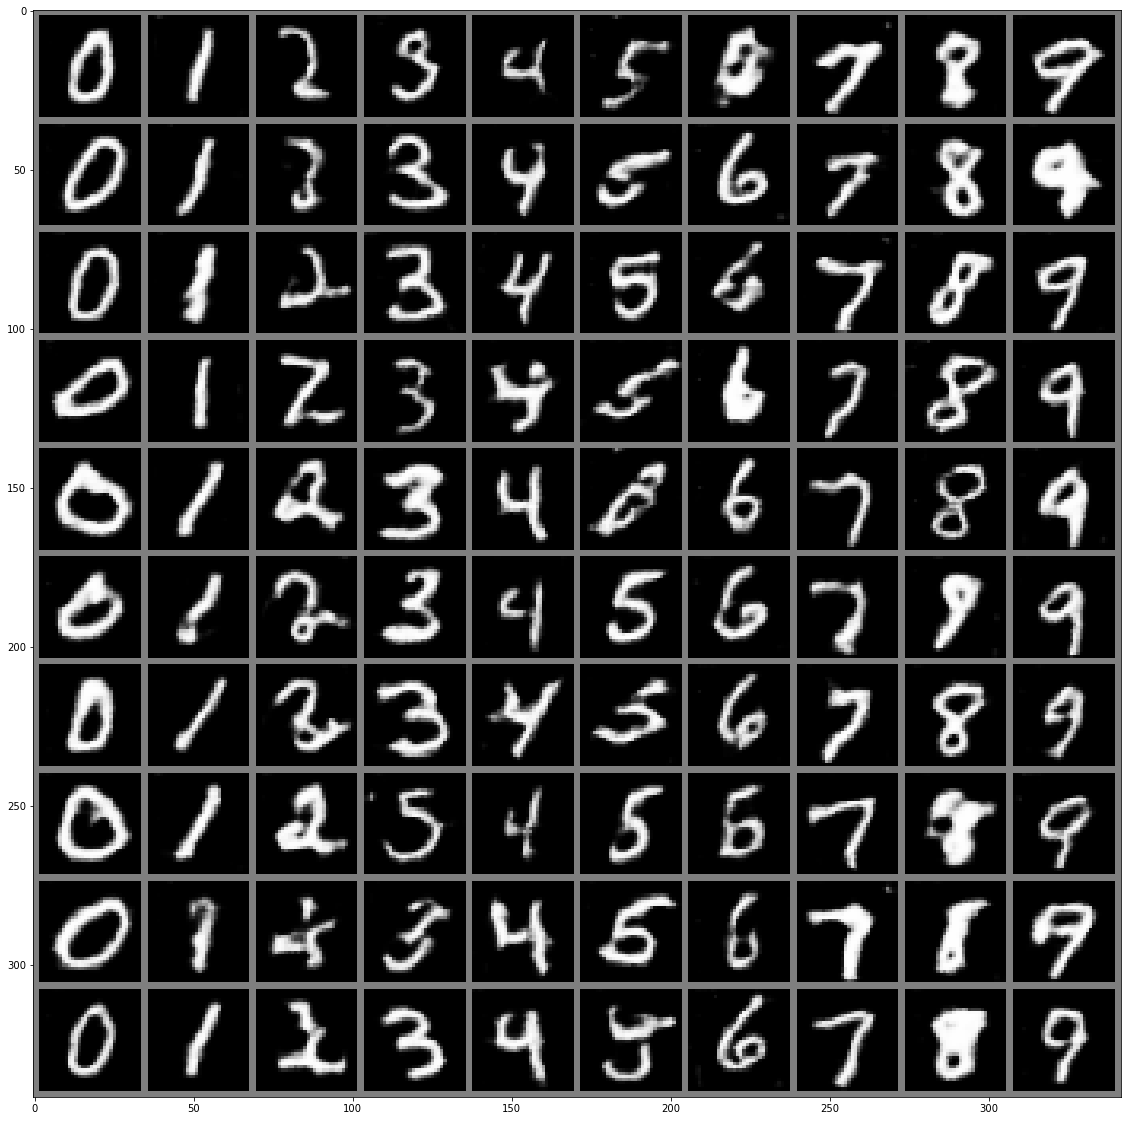

[Epoch 141/200] [Batch 112/468] [D loss: 0.216111, acc: 95%] [G loss: 1.263767]
[Epoch 141/200] [Batch 212/468] [D loss: 0.119914, acc: 97%] [G loss: 1.175104]
[Epoch 141/200] [Batch 312/468] [D loss: 0.141829, acc: 96%] [G loss: 1.107299]
[Epoch 141/200] [Batch 412/468] [D loss: 0.169567, acc: 96%] [G loss: 1.085649]
[Epoch 142/200] [Batch 44/468] [D loss: 0.146912, acc: 96%] [G loss: 0.464671]
[Epoch 142/200] [Batch 144/468] [D loss: 0.238854, acc: 96%] [G loss: 1.267034]
[Epoch 142/200] [Batch 244/468] [D loss: 0.123482, acc: 96%] [G loss: 1.240744]
[Epoch 142/200] [Batch 344/468] [D loss: 0.175296, acc: 95%] [G loss: 0.907727]
[Epoch 142/200] [Batch 444/468] [D loss: 0.225967, acc: 97%] [G loss: 0.838745]
[Epoch 143/200] [Batch 76/468] [D loss: 0.163437, acc: 96%] [G loss: 1.471272]
[Epoch 143/200] [Batch 176/468] [D loss: 0.131932, acc: 96%] [G loss: 0.650007]
[Epoch 143/200] [Batch 276/468] [D loss: 0.173608, acc: 97%] [G loss: 0.741899]
[Epoch 143/200] [Batch 376/468] [D loss: 0

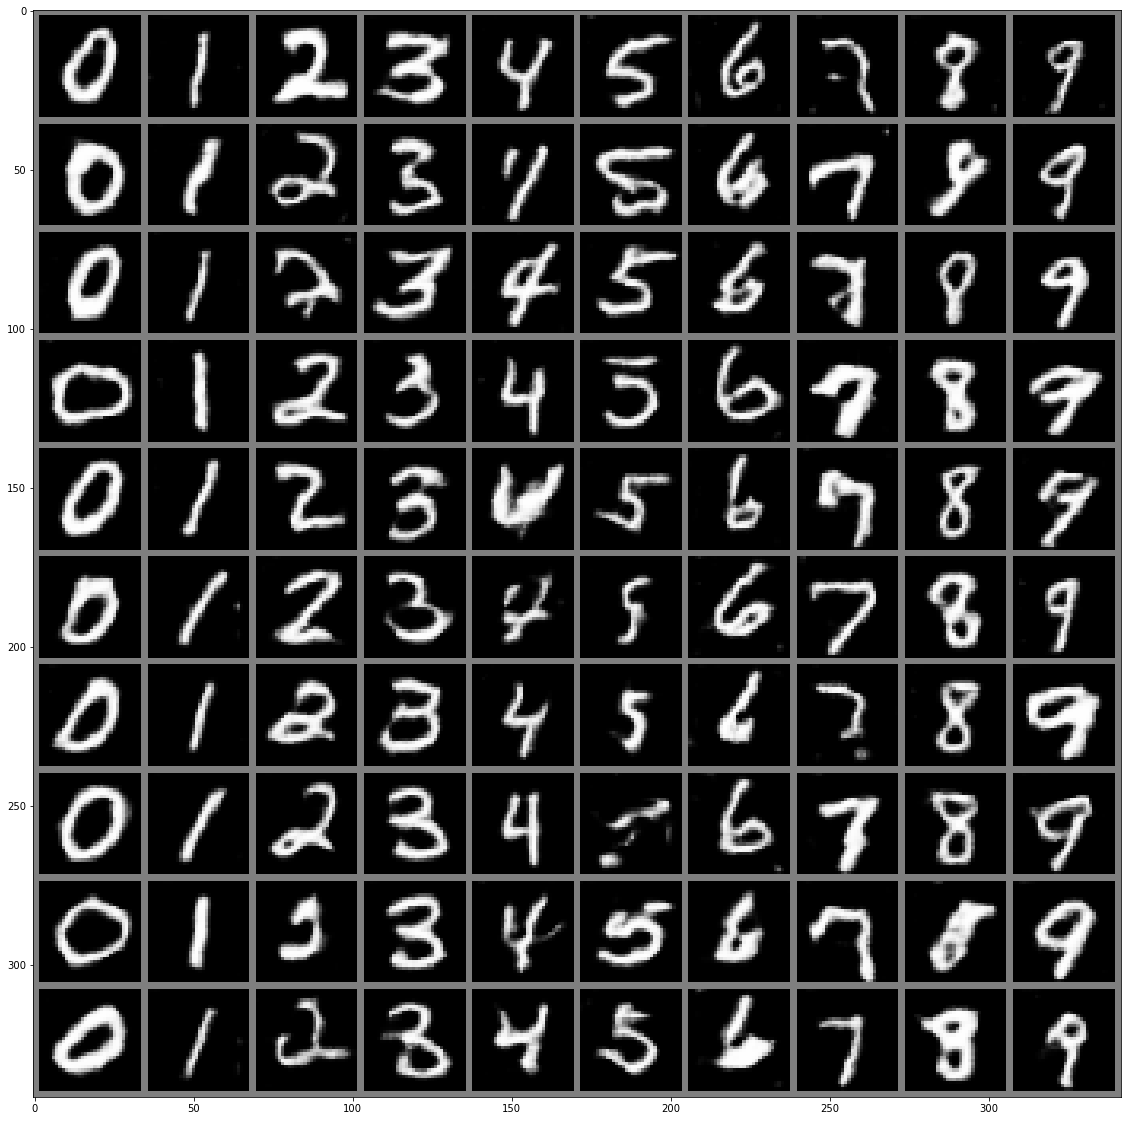

[Epoch 145/200] [Batch 240/468] [D loss: 0.164442, acc: 97%] [G loss: 1.164604]
[Epoch 145/200] [Batch 340/468] [D loss: 0.082784, acc: 97%] [G loss: 1.379039]
[Epoch 145/200] [Batch 440/468] [D loss: 0.388174, acc: 95%] [G loss: 0.589248]
[Epoch 146/200] [Batch 72/468] [D loss: 0.197996, acc: 96%] [G loss: 0.698542]
[Epoch 146/200] [Batch 172/468] [D loss: 0.120701, acc: 95%] [G loss: 0.844135]
[Epoch 146/200] [Batch 272/468] [D loss: 0.089918, acc: 96%] [G loss: 1.146242]
[Epoch 146/200] [Batch 372/468] [D loss: 0.165882, acc: 98%] [G loss: 1.399584]
[Epoch 147/200] [Batch 4/468] [D loss: 0.176556, acc: 94%] [G loss: 1.806711]
[Epoch 147/200] [Batch 104/468] [D loss: 0.099286, acc: 97%] [G loss: 1.216120]
[Epoch 147/200] [Batch 204/468] [D loss: 0.100849, acc: 96%] [G loss: 0.842615]
[Epoch 147/200] [Batch 304/468] [D loss: 0.184027, acc: 97%] [G loss: 1.457532]
[Epoch 147/200] [Batch 404/468] [D loss: 0.191914, acc: 98%] [G loss: 1.376633]
[Epoch 148/200] [Batch 36/468] [D loss: 0.1

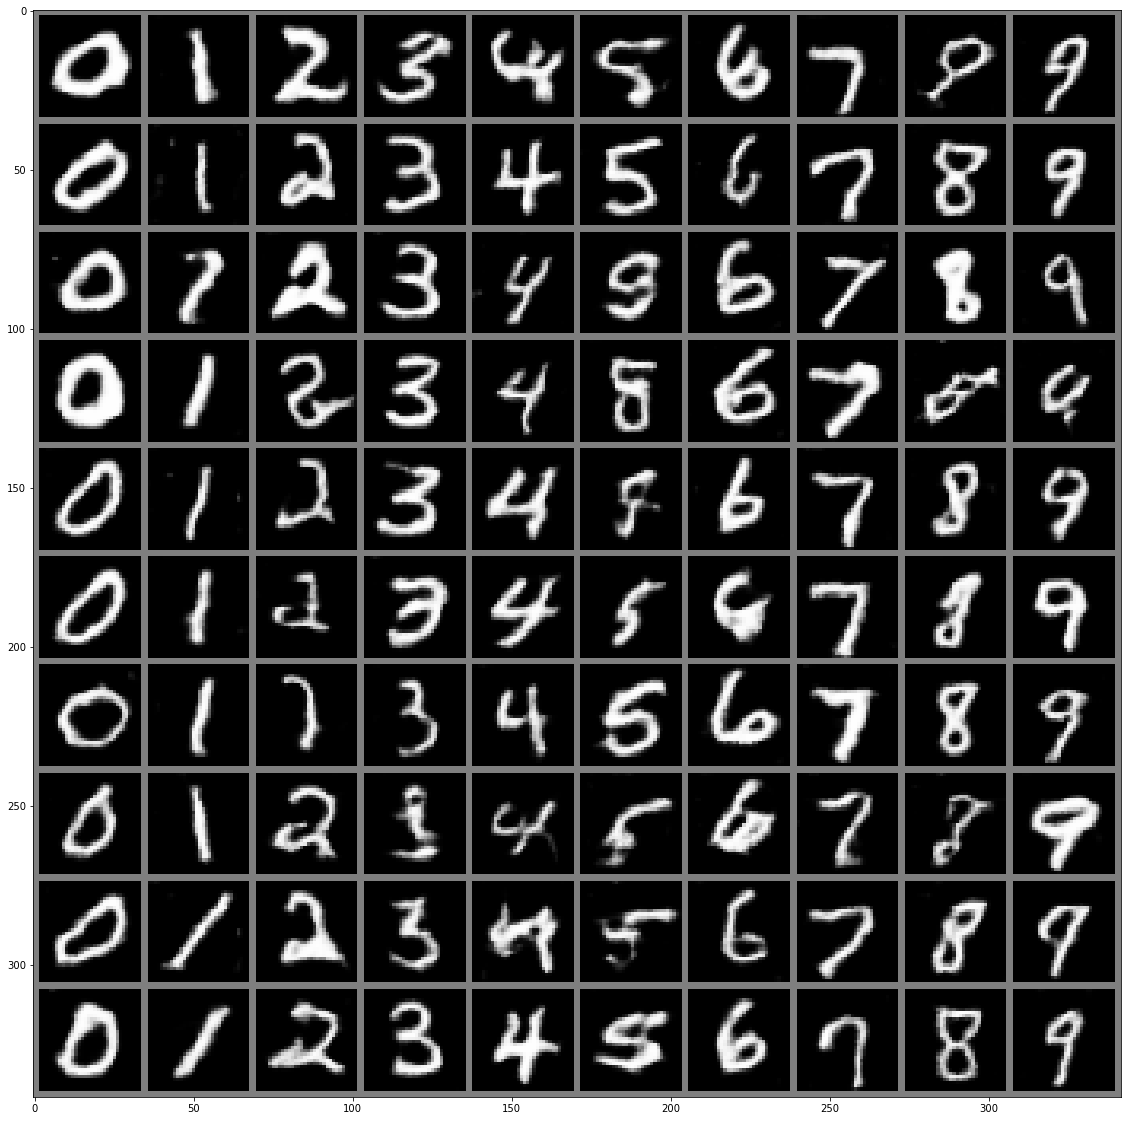

[Epoch 149/200] [Batch 368/468] [D loss: 0.189225, acc: 95%] [G loss: 0.771717]
[Epoch 150/200] [Batch 0/468] [D loss: 0.113937, acc: 96%] [G loss: 1.426176]
[Epoch 150/200] [Batch 100/468] [D loss: 0.241285, acc: 96%] [G loss: 0.653943]
[Epoch 150/200] [Batch 200/468] [D loss: 0.189622, acc: 96%] [G loss: 1.089515]
[Epoch 150/200] [Batch 300/468] [D loss: 0.154904, acc: 94%] [G loss: 1.273578]
[Epoch 150/200] [Batch 400/468] [D loss: 0.248324, acc: 98%] [G loss: 1.349904]
[Epoch 151/200] [Batch 32/468] [D loss: 0.301329, acc: 98%] [G loss: 1.118250]
[Epoch 151/200] [Batch 132/468] [D loss: 0.223319, acc: 96%] [G loss: 1.288949]
[Epoch 151/200] [Batch 232/468] [D loss: 0.222082, acc: 96%] [G loss: 1.149981]
[Epoch 151/200] [Batch 332/468] [D loss: 0.265828, acc: 92%] [G loss: 1.339718]
[Epoch 151/200] [Batch 432/468] [D loss: 0.253670, acc: 93%] [G loss: 0.837132]
[Epoch 152/200] [Batch 64/468] [D loss: 0.138012, acc: 96%] [G loss: 0.640567]
[Epoch 152/200] [Batch 164/468] [D loss: 0.1

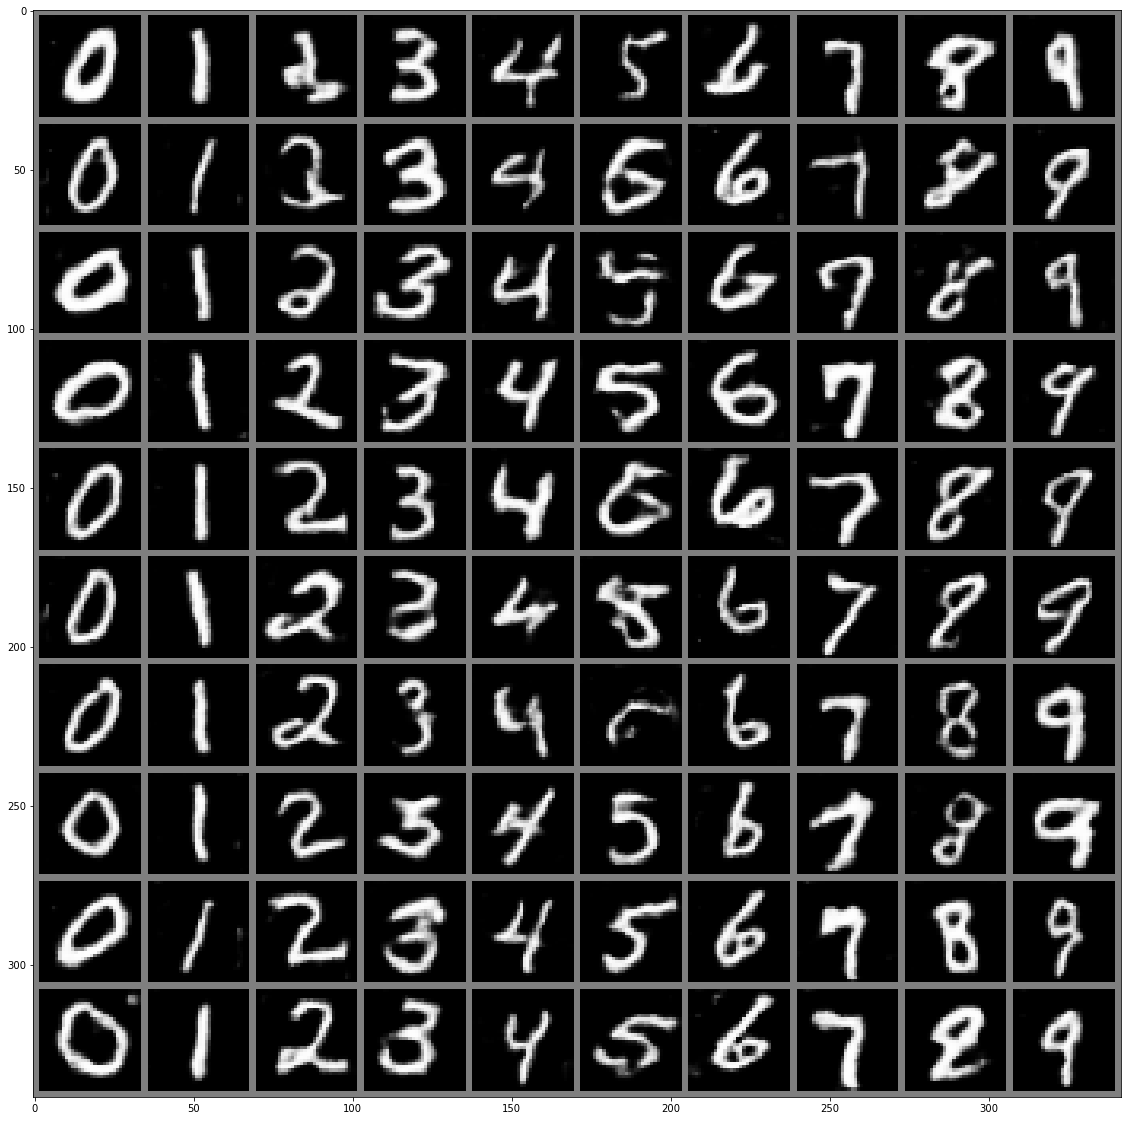

[Epoch 154/200] [Batch 28/468] [D loss: 0.265191, acc: 98%] [G loss: 1.546929]
[Epoch 154/200] [Batch 128/468] [D loss: 0.105688, acc: 95%] [G loss: 1.194813]
[Epoch 154/200] [Batch 228/468] [D loss: 0.158397, acc: 96%] [G loss: 1.043935]
[Epoch 154/200] [Batch 328/468] [D loss: 0.106251, acc: 94%] [G loss: 0.851567]
[Epoch 154/200] [Batch 428/468] [D loss: 0.162579, acc: 96%] [G loss: 1.526296]
[Epoch 155/200] [Batch 60/468] [D loss: 0.226042, acc: 93%] [G loss: 1.757004]
[Epoch 155/200] [Batch 160/468] [D loss: 0.163964, acc: 96%] [G loss: 0.780051]
[Epoch 155/200] [Batch 260/468] [D loss: 0.147972, acc: 95%] [G loss: 1.417817]
[Epoch 155/200] [Batch 360/468] [D loss: 0.219687, acc: 97%] [G loss: 1.469269]
[Epoch 155/200] [Batch 460/468] [D loss: 0.252153, acc: 97%] [G loss: 1.067510]
[Epoch 156/200] [Batch 92/468] [D loss: 0.226966, acc: 96%] [G loss: 1.467927]
[Epoch 156/200] [Batch 192/468] [D loss: 0.206410, acc: 96%] [G loss: 0.749266]
[Epoch 156/200] [Batch 292/468] [D loss: 0.

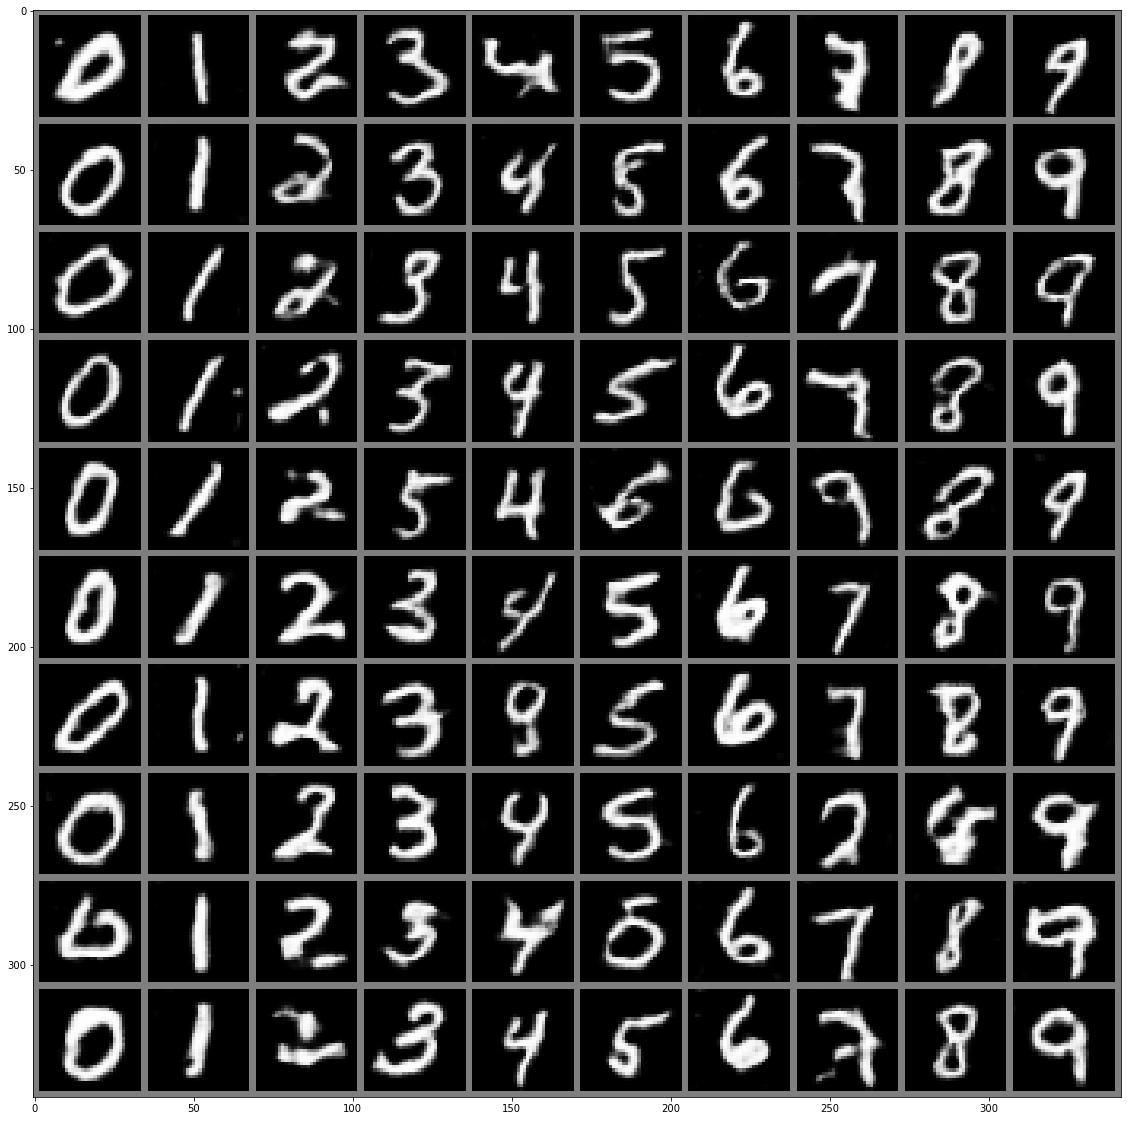

[Epoch 158/200] [Batch 156/468] [D loss: 0.123943, acc: 96%] [G loss: 1.349505]
[Epoch 158/200] [Batch 256/468] [D loss: 0.157872, acc: 98%] [G loss: 1.693570]
[Epoch 158/200] [Batch 356/468] [D loss: 0.162476, acc: 93%] [G loss: 1.706512]
[Epoch 158/200] [Batch 456/468] [D loss: 0.106828, acc: 94%] [G loss: 2.791875]
[Epoch 159/200] [Batch 88/468] [D loss: 0.238793, acc: 96%] [G loss: 1.623195]
[Epoch 159/200] [Batch 188/468] [D loss: 0.142037, acc: 95%] [G loss: 1.106943]
[Epoch 159/200] [Batch 288/468] [D loss: 0.251221, acc: 98%] [G loss: 1.165504]
[Epoch 159/200] [Batch 388/468] [D loss: 0.168585, acc: 96%] [G loss: 0.777960]
[Epoch 160/200] [Batch 20/468] [D loss: 0.148876, acc: 96%] [G loss: 1.219742]
[Epoch 160/200] [Batch 120/468] [D loss: 0.200635, acc: 95%] [G loss: 1.033157]
[Epoch 160/200] [Batch 220/468] [D loss: 0.128799, acc: 97%] [G loss: 0.653386]
[Epoch 160/200] [Batch 320/468] [D loss: 0.142213, acc: 94%] [G loss: 2.013396]
[Epoch 160/200] [Batch 420/468] [D loss: 0

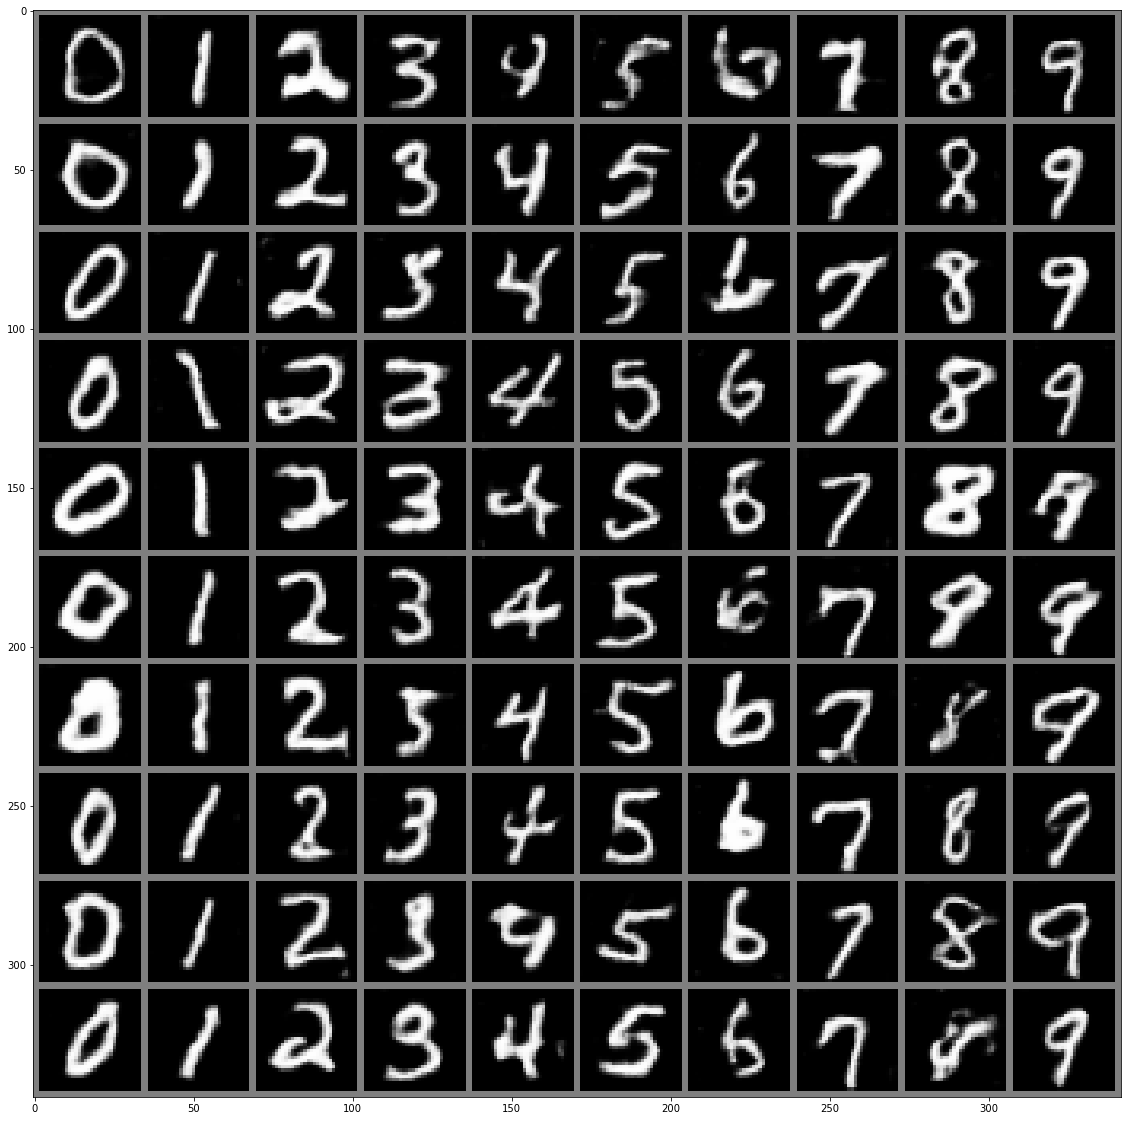

[Epoch 162/200] [Batch 284/468] [D loss: 0.116896, acc: 96%] [G loss: 0.972527]
[Epoch 162/200] [Batch 384/468] [D loss: 0.105476, acc: 96%] [G loss: 0.246036]
[Epoch 163/200] [Batch 16/468] [D loss: 0.161744, acc: 95%] [G loss: 0.648435]
[Epoch 163/200] [Batch 116/468] [D loss: 0.137240, acc: 97%] [G loss: 1.137168]
[Epoch 163/200] [Batch 216/468] [D loss: 0.150504, acc: 97%] [G loss: 0.870818]
[Epoch 163/200] [Batch 316/468] [D loss: 0.221633, acc: 98%] [G loss: 1.223177]
[Epoch 163/200] [Batch 416/468] [D loss: 0.139650, acc: 96%] [G loss: 1.446660]
[Epoch 164/200] [Batch 48/468] [D loss: 0.121067, acc: 95%] [G loss: 0.393181]
[Epoch 164/200] [Batch 148/468] [D loss: 0.255350, acc: 94%] [G loss: 1.450119]
[Epoch 164/200] [Batch 248/468] [D loss: 0.331041, acc: 97%] [G loss: 0.480164]
[Epoch 164/200] [Batch 348/468] [D loss: 0.202809, acc: 97%] [G loss: 1.300917]
[Epoch 164/200] [Batch 448/468] [D loss: 0.147139, acc: 96%] [G loss: 1.289261]
[Epoch 165/200] [Batch 80/468] [D loss: 0.

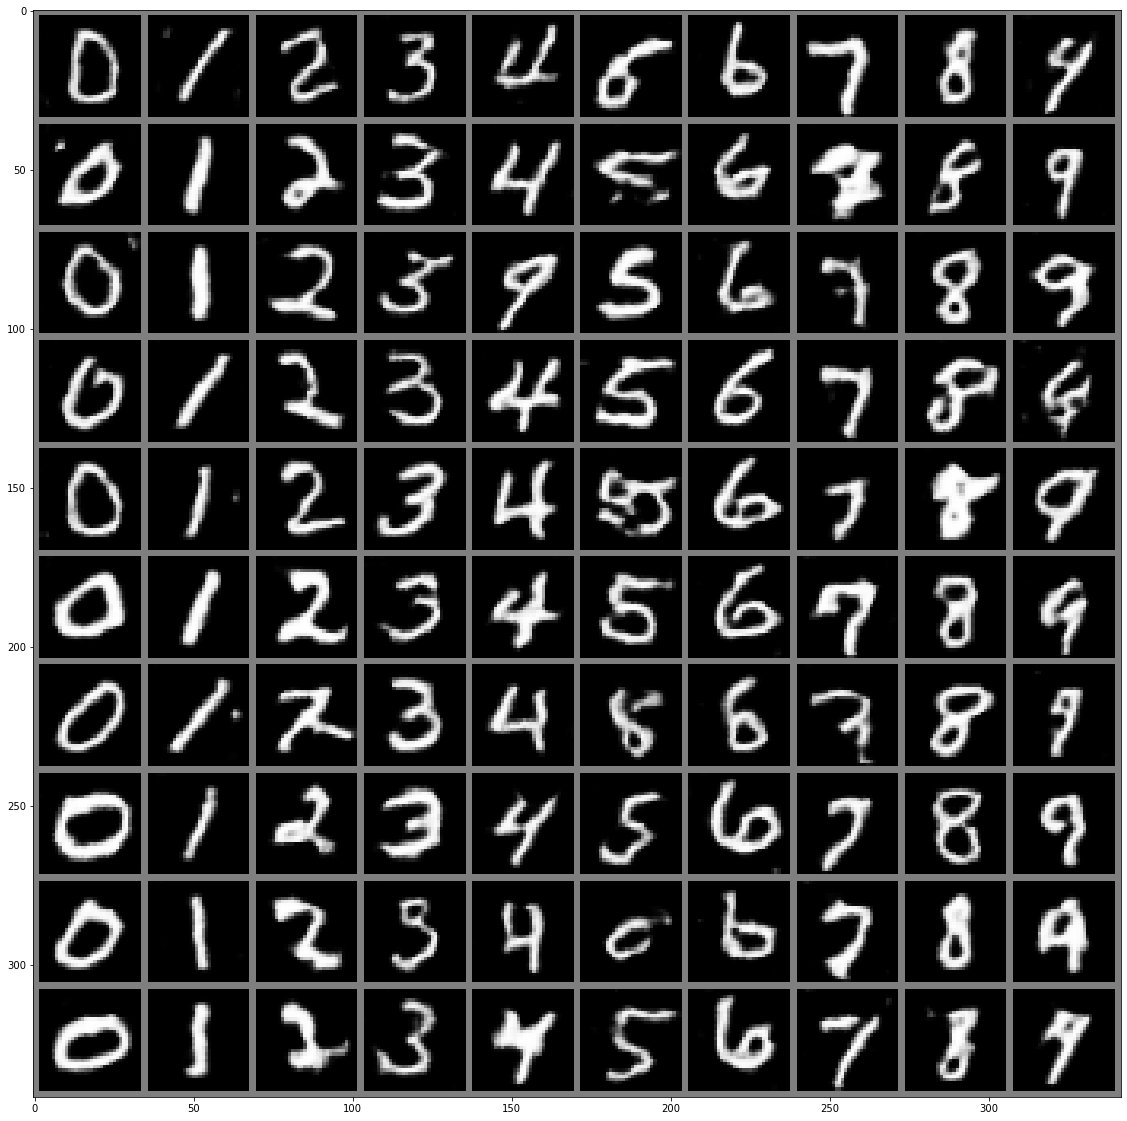

[Epoch 166/200] [Batch 412/468] [D loss: 0.078842, acc: 96%] [G loss: 1.650241]
[Epoch 167/200] [Batch 44/468] [D loss: 0.260542, acc: 94%] [G loss: 1.024419]
[Epoch 167/200] [Batch 144/468] [D loss: 0.163337, acc: 96%] [G loss: 0.609143]
[Epoch 167/200] [Batch 244/468] [D loss: 0.199393, acc: 92%] [G loss: 0.841837]
[Epoch 167/200] [Batch 344/468] [D loss: 0.230664, acc: 96%] [G loss: 1.033870]
[Epoch 167/200] [Batch 444/468] [D loss: 0.192862, acc: 95%] [G loss: 1.147561]
[Epoch 168/200] [Batch 76/468] [D loss: 0.213313, acc: 96%] [G loss: 1.724178]
[Epoch 168/200] [Batch 176/468] [D loss: 0.200409, acc: 94%] [G loss: 1.674330]
[Epoch 168/200] [Batch 276/468] [D loss: 0.150112, acc: 96%] [G loss: 1.377120]
[Epoch 168/200] [Batch 376/468] [D loss: 0.185675, acc: 95%] [G loss: 1.727391]
[Epoch 169/200] [Batch 8/468] [D loss: 0.191205, acc: 96%] [G loss: 1.954803]
[Epoch 169/200] [Batch 108/468] [D loss: 0.281477, acc: 95%] [G loss: 1.057503]
[Epoch 169/200] [Batch 208/468] [D loss: 0.2

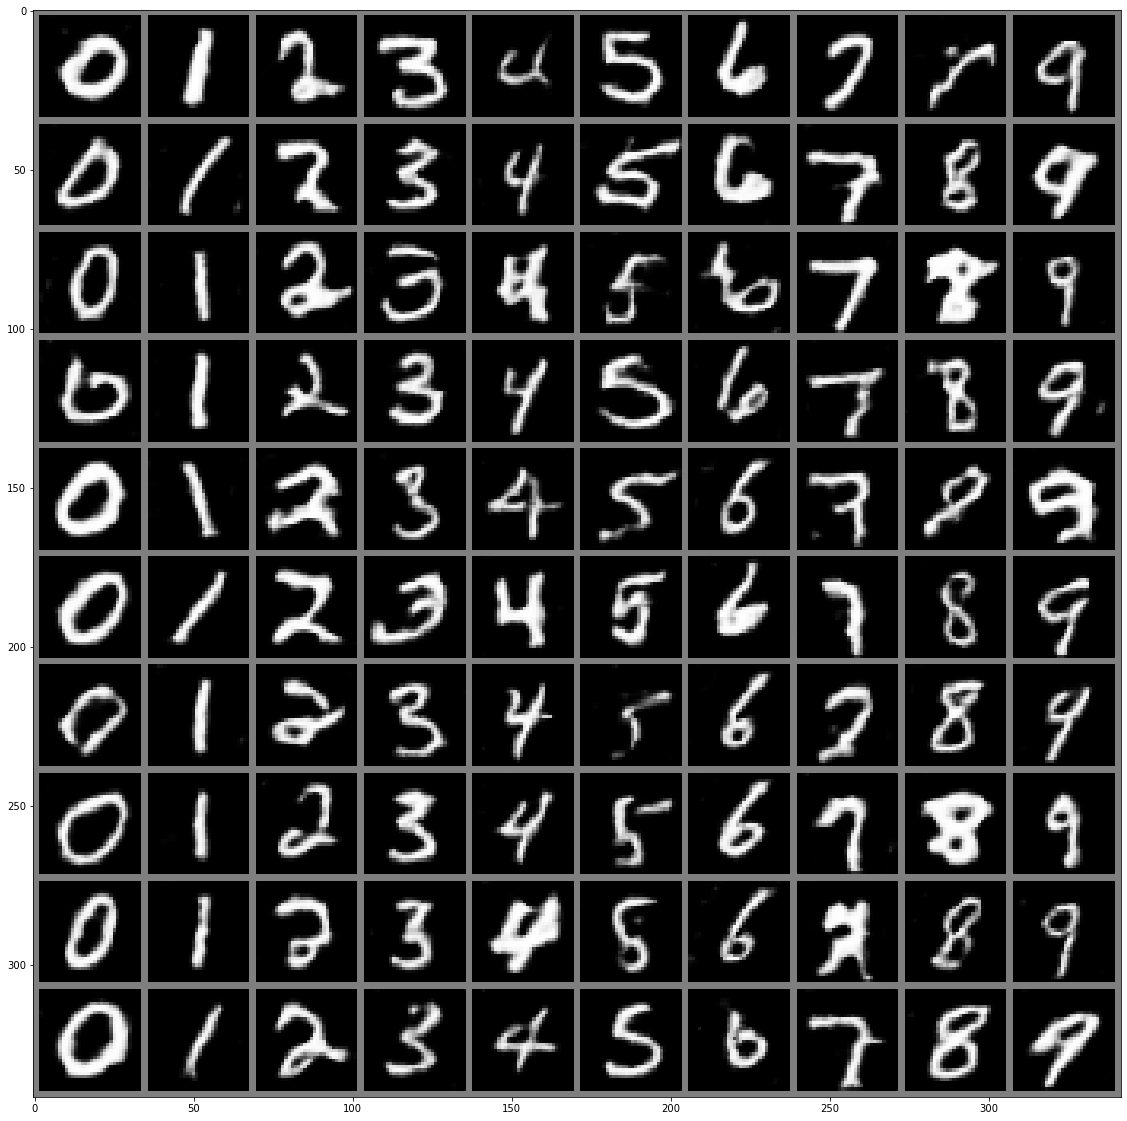

[Epoch 171/200] [Batch 72/468] [D loss: 0.095493, acc: 95%] [G loss: 1.972639]
[Epoch 171/200] [Batch 172/468] [D loss: 0.186531, acc: 95%] [G loss: 1.413697]
[Epoch 171/200] [Batch 272/468] [D loss: 0.097468, acc: 95%] [G loss: 1.247588]
[Epoch 171/200] [Batch 372/468] [D loss: 0.118347, acc: 96%] [G loss: 0.723379]
[Epoch 172/200] [Batch 4/468] [D loss: 0.109392, acc: 96%] [G loss: 0.912973]
[Epoch 172/200] [Batch 104/468] [D loss: 0.109829, acc: 97%] [G loss: 1.079063]
[Epoch 172/200] [Batch 204/468] [D loss: 0.205133, acc: 95%] [G loss: 1.067018]
[Epoch 172/200] [Batch 304/468] [D loss: 0.145087, acc: 96%] [G loss: 1.534972]
[Epoch 172/200] [Batch 404/468] [D loss: 0.189539, acc: 96%] [G loss: 1.425015]
[Epoch 173/200] [Batch 36/468] [D loss: 0.118200, acc: 97%] [G loss: 1.862173]
[Epoch 173/200] [Batch 136/468] [D loss: 0.135825, acc: 97%] [G loss: 0.358602]
[Epoch 173/200] [Batch 236/468] [D loss: 0.118872, acc: 96%] [G loss: 0.843910]
[Epoch 173/200] [Batch 336/468] [D loss: 0.1

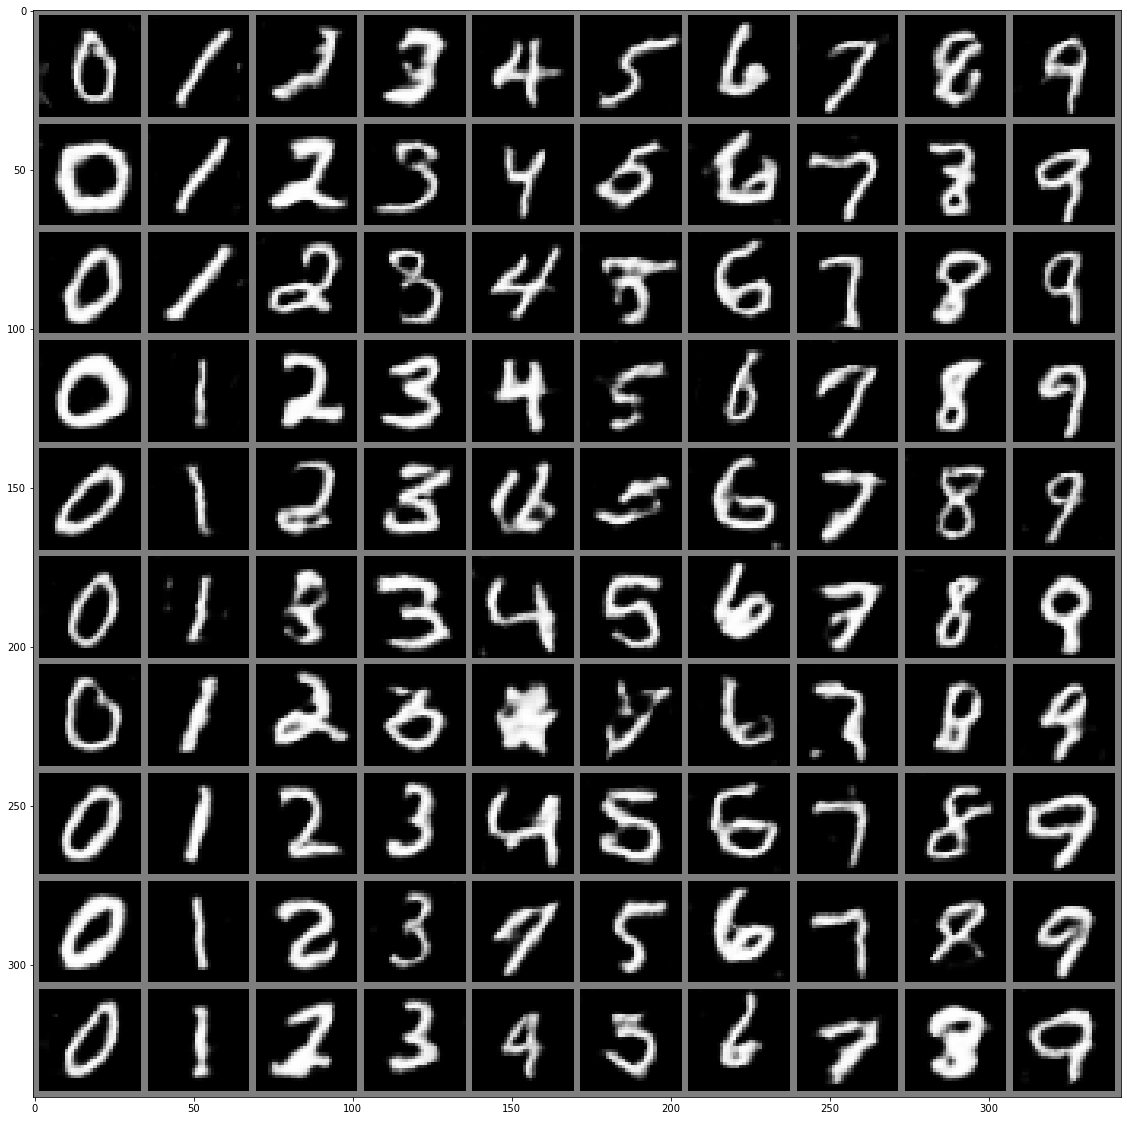

[Epoch 175/200] [Batch 200/468] [D loss: 0.148476, acc: 96%] [G loss: 1.517315]
[Epoch 175/200] [Batch 300/468] [D loss: 0.155823, acc: 97%] [G loss: 0.935110]
[Epoch 175/200] [Batch 400/468] [D loss: 0.165084, acc: 97%] [G loss: 1.407719]
[Epoch 176/200] [Batch 32/468] [D loss: 0.139418, acc: 96%] [G loss: 0.989923]
[Epoch 176/200] [Batch 132/468] [D loss: 0.129539, acc: 96%] [G loss: 0.394101]
[Epoch 176/200] [Batch 232/468] [D loss: 0.196540, acc: 95%] [G loss: 1.253653]
[Epoch 176/200] [Batch 332/468] [D loss: 0.241817, acc: 97%] [G loss: 1.196516]
[Epoch 176/200] [Batch 432/468] [D loss: 0.122793, acc: 93%] [G loss: 1.351116]
[Epoch 177/200] [Batch 64/468] [D loss: 0.202299, acc: 96%] [G loss: 0.953934]
[Epoch 177/200] [Batch 164/468] [D loss: 0.105918, acc: 97%] [G loss: 1.180253]
[Epoch 177/200] [Batch 264/468] [D loss: 0.162262, acc: 96%] [G loss: 0.600329]
[Epoch 177/200] [Batch 364/468] [D loss: 0.182613, acc: 92%] [G loss: 0.854417]
[Epoch 177/200] [Batch 464/468] [D loss: 0

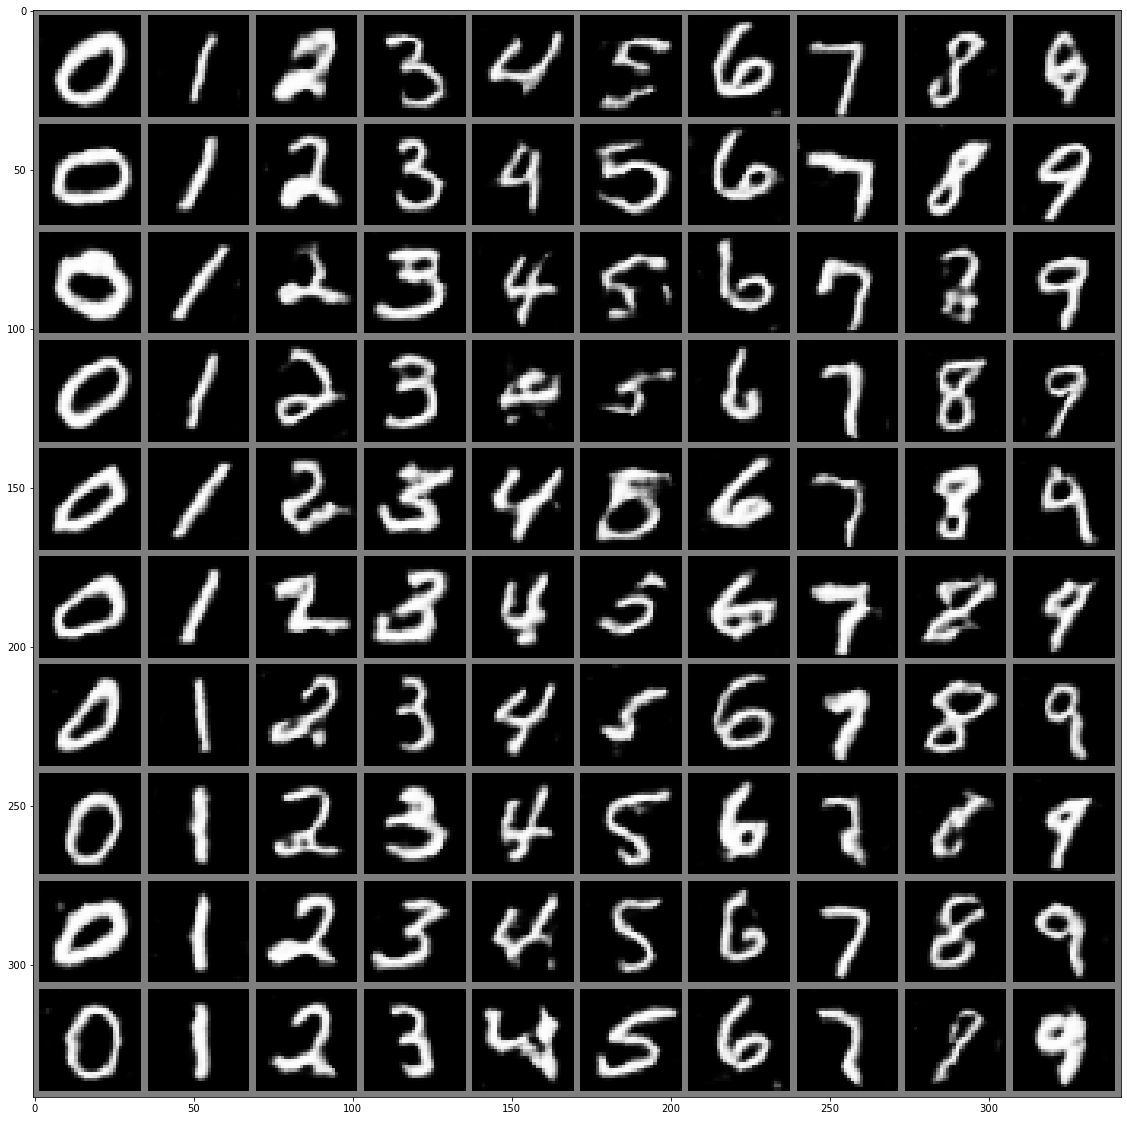

[Epoch 179/200] [Batch 328/468] [D loss: 0.105611, acc: 96%] [G loss: 1.132738]
[Epoch 179/200] [Batch 428/468] [D loss: 0.118137, acc: 95%] [G loss: 0.772992]
[Epoch 180/200] [Batch 60/468] [D loss: 0.319534, acc: 96%] [G loss: 0.827271]
[Epoch 180/200] [Batch 160/468] [D loss: 0.249957, acc: 94%] [G loss: 1.160322]
[Epoch 180/200] [Batch 260/468] [D loss: 0.120910, acc: 96%] [G loss: 1.330276]
[Epoch 180/200] [Batch 360/468] [D loss: 0.123505, acc: 96%] [G loss: 1.592720]
[Epoch 180/200] [Batch 460/468] [D loss: 0.150090, acc: 95%] [G loss: 0.949217]
[Epoch 181/200] [Batch 92/468] [D loss: 0.156872, acc: 96%] [G loss: 0.737459]
[Epoch 181/200] [Batch 192/468] [D loss: 0.264073, acc: 94%] [G loss: 0.935707]
[Epoch 181/200] [Batch 292/468] [D loss: 0.148503, acc: 97%] [G loss: 1.363443]
[Epoch 181/200] [Batch 392/468] [D loss: 0.204207, acc: 97%] [G loss: 1.364712]
[Epoch 182/200] [Batch 24/468] [D loss: 0.129845, acc: 98%] [G loss: 0.965966]
[Epoch 182/200] [Batch 124/468] [D loss: 0.

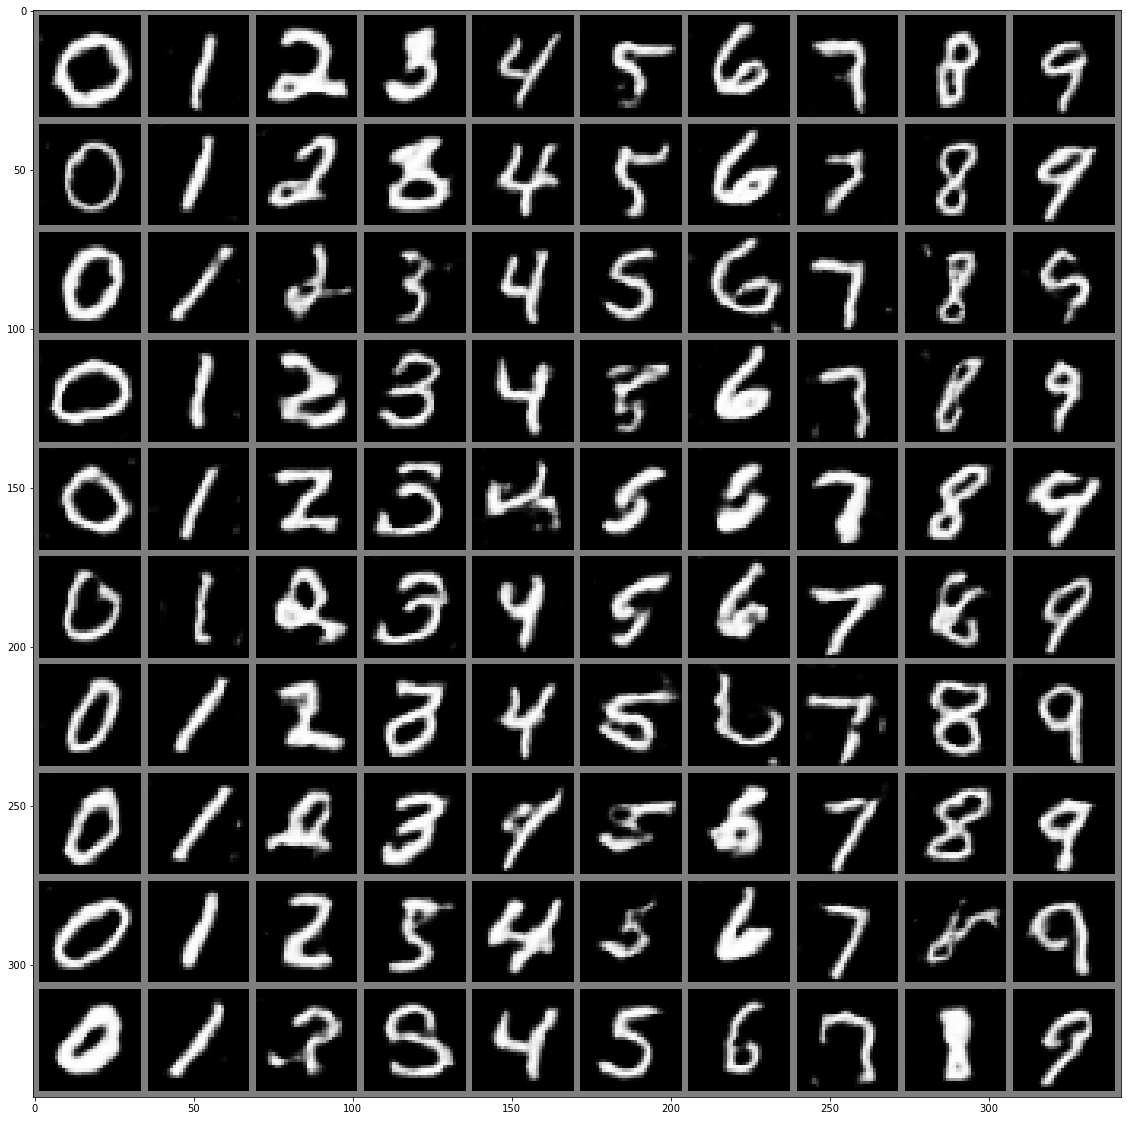

[Epoch 183/200] [Batch 456/468] [D loss: 0.180913, acc: 96%] [G loss: 1.016833]
[Epoch 184/200] [Batch 88/468] [D loss: 0.223587, acc: 97%] [G loss: 0.571293]
[Epoch 184/200] [Batch 188/468] [D loss: 0.258152, acc: 97%] [G loss: 0.591375]
[Epoch 184/200] [Batch 288/468] [D loss: 0.254097, acc: 94%] [G loss: 0.673835]
[Epoch 184/200] [Batch 388/468] [D loss: 0.166548, acc: 95%] [G loss: 1.163762]
[Epoch 185/200] [Batch 20/468] [D loss: 0.212966, acc: 95%] [G loss: 0.869245]
[Epoch 185/200] [Batch 120/468] [D loss: 0.199836, acc: 97%] [G loss: 1.440502]
[Epoch 185/200] [Batch 220/468] [D loss: 0.226566, acc: 96%] [G loss: 0.510217]
[Epoch 185/200] [Batch 320/468] [D loss: 0.208779, acc: 96%] [G loss: 0.984820]
[Epoch 185/200] [Batch 420/468] [D loss: 0.264620, acc: 96%] [G loss: 1.244945]
[Epoch 186/200] [Batch 52/468] [D loss: 0.094598, acc: 95%] [G loss: 0.752259]
[Epoch 186/200] [Batch 152/468] [D loss: 0.115787, acc: 95%] [G loss: 0.849021]
[Epoch 186/200] [Batch 252/468] [D loss: 0.

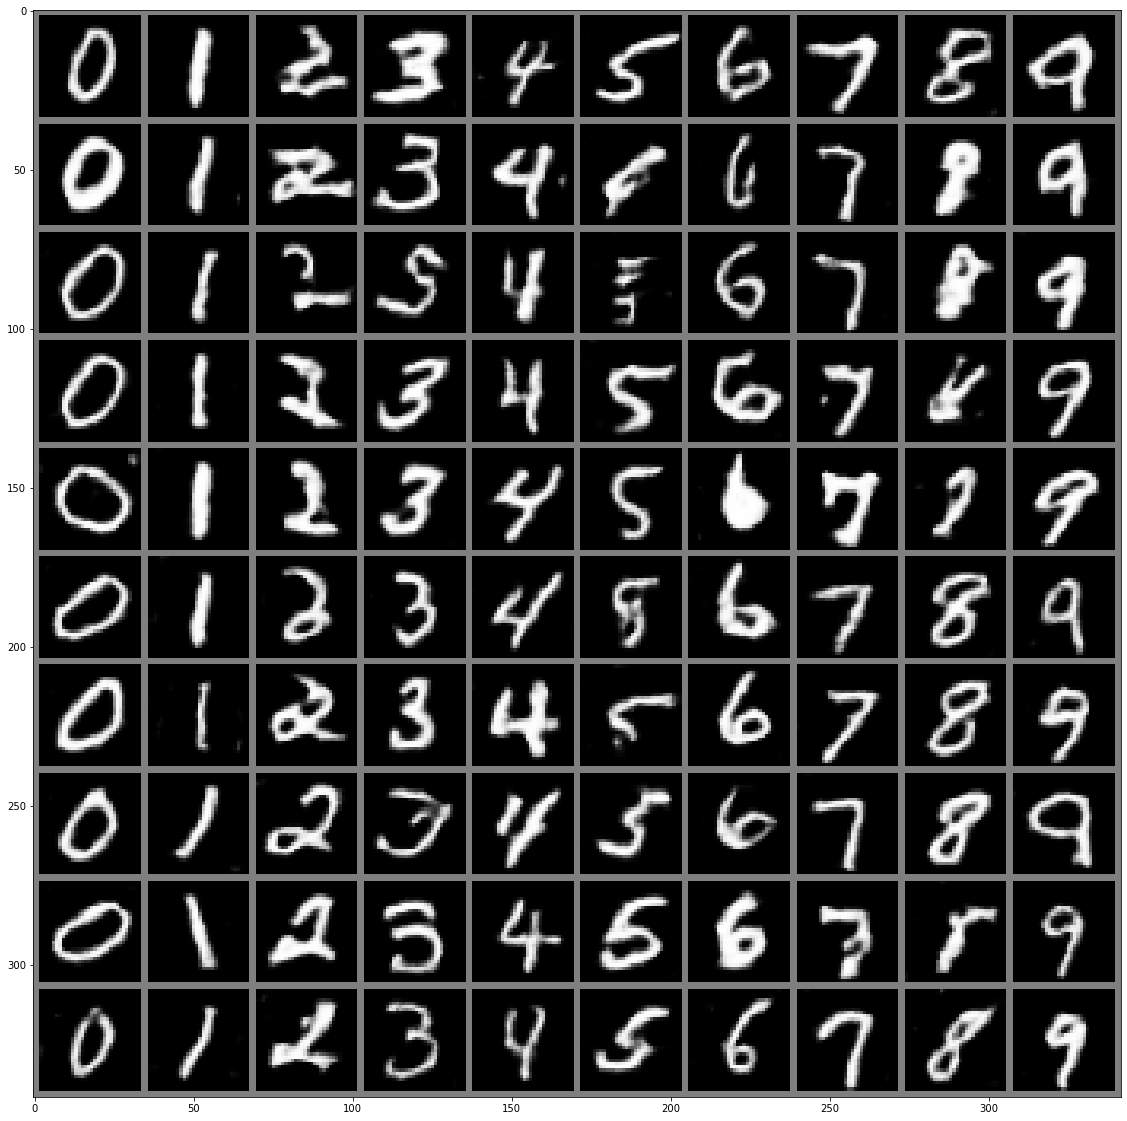

[Epoch 188/200] [Batch 116/468] [D loss: 0.168678, acc: 96%] [G loss: 0.986977]
[Epoch 188/200] [Batch 216/468] [D loss: 0.213472, acc: 97%] [G loss: 1.070758]
[Epoch 188/200] [Batch 316/468] [D loss: 0.078658, acc: 96%] [G loss: 0.988761]
[Epoch 188/200] [Batch 416/468] [D loss: 0.223592, acc: 94%] [G loss: 0.513650]
[Epoch 189/200] [Batch 48/468] [D loss: 0.150378, acc: 94%] [G loss: 0.393883]
[Epoch 189/200] [Batch 148/468] [D loss: 0.193047, acc: 97%] [G loss: 1.711315]
[Epoch 189/200] [Batch 248/468] [D loss: 0.138288, acc: 94%] [G loss: 0.410543]
[Epoch 189/200] [Batch 348/468] [D loss: 0.186476, acc: 97%] [G loss: 2.103189]
[Epoch 189/200] [Batch 448/468] [D loss: 0.187650, acc: 94%] [G loss: 0.935500]
[Epoch 190/200] [Batch 80/468] [D loss: 0.130313, acc: 92%] [G loss: 1.149395]
[Epoch 190/200] [Batch 180/468] [D loss: 0.172999, acc: 96%] [G loss: 1.391985]
[Epoch 190/200] [Batch 280/468] [D loss: 0.152106, acc: 94%] [G loss: 0.982249]
[Epoch 190/200] [Batch 380/468] [D loss: 0

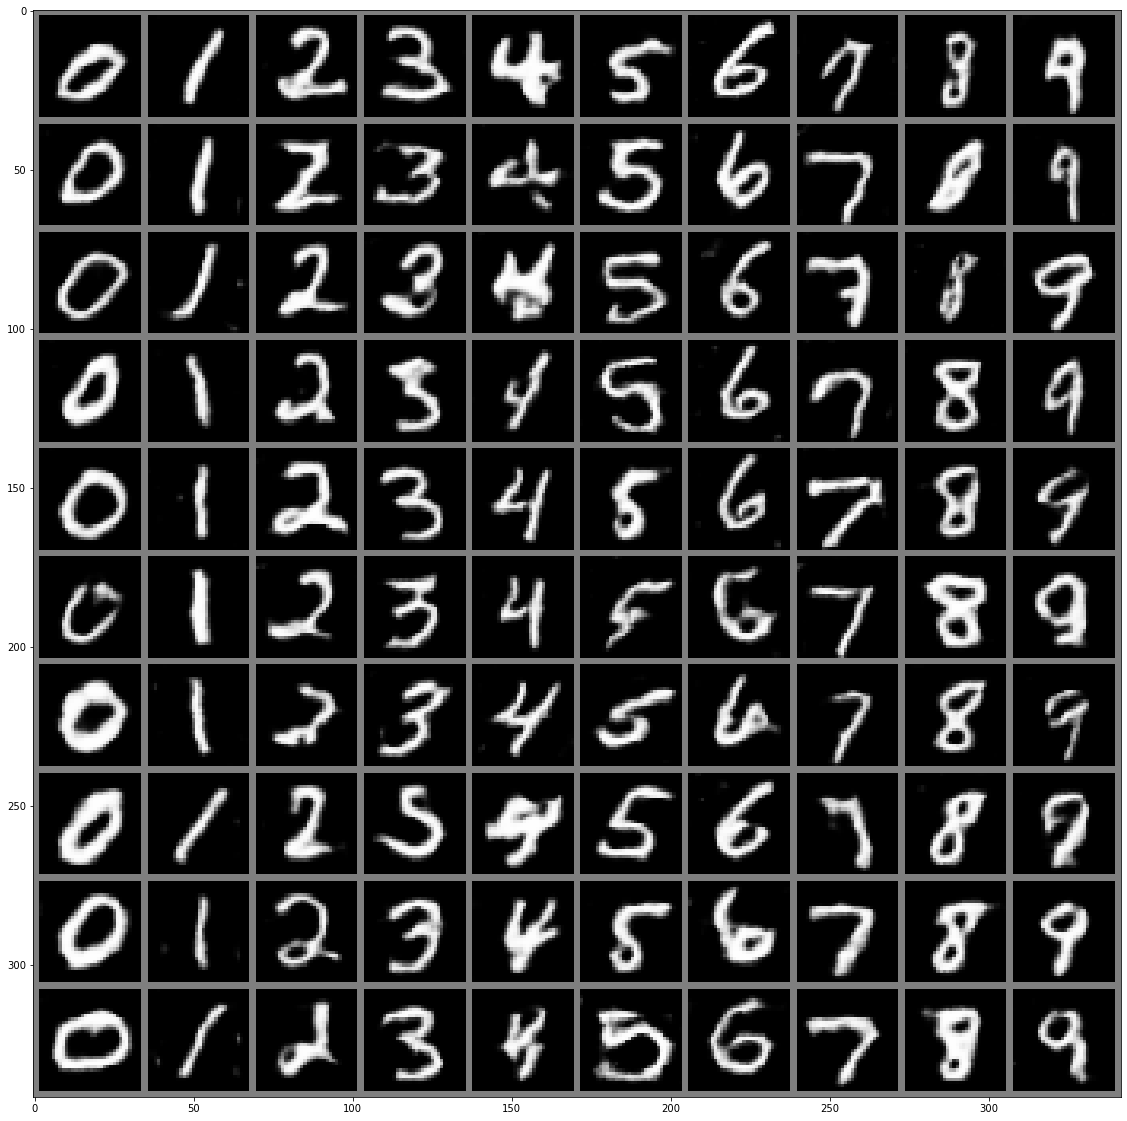

[Epoch 192/200] [Batch 244/468] [D loss: 0.129244, acc: 98%] [G loss: 1.554990]
[Epoch 192/200] [Batch 344/468] [D loss: 0.176174, acc: 96%] [G loss: 0.676194]
[Epoch 192/200] [Batch 444/468] [D loss: 0.133083, acc: 97%] [G loss: 0.595701]
[Epoch 193/200] [Batch 76/468] [D loss: 0.119879, acc: 98%] [G loss: 1.389360]
[Epoch 193/200] [Batch 176/468] [D loss: 0.113682, acc: 95%] [G loss: 0.675391]
[Epoch 193/200] [Batch 276/468] [D loss: 0.152328, acc: 98%] [G loss: 1.066395]
[Epoch 193/200] [Batch 376/468] [D loss: 0.186250, acc: 96%] [G loss: 0.569032]
[Epoch 194/200] [Batch 8/468] [D loss: 0.152582, acc: 98%] [G loss: 0.655207]
[Epoch 194/200] [Batch 108/468] [D loss: 0.175395, acc: 95%] [G loss: 1.612562]
[Epoch 194/200] [Batch 208/468] [D loss: 0.200793, acc: 96%] [G loss: 0.444825]
[Epoch 194/200] [Batch 308/468] [D loss: 0.092285, acc: 97%] [G loss: 0.379461]
[Epoch 194/200] [Batch 408/468] [D loss: 0.136535, acc: 97%] [G loss: 1.013585]
[Epoch 195/200] [Batch 40/468] [D loss: 0.1

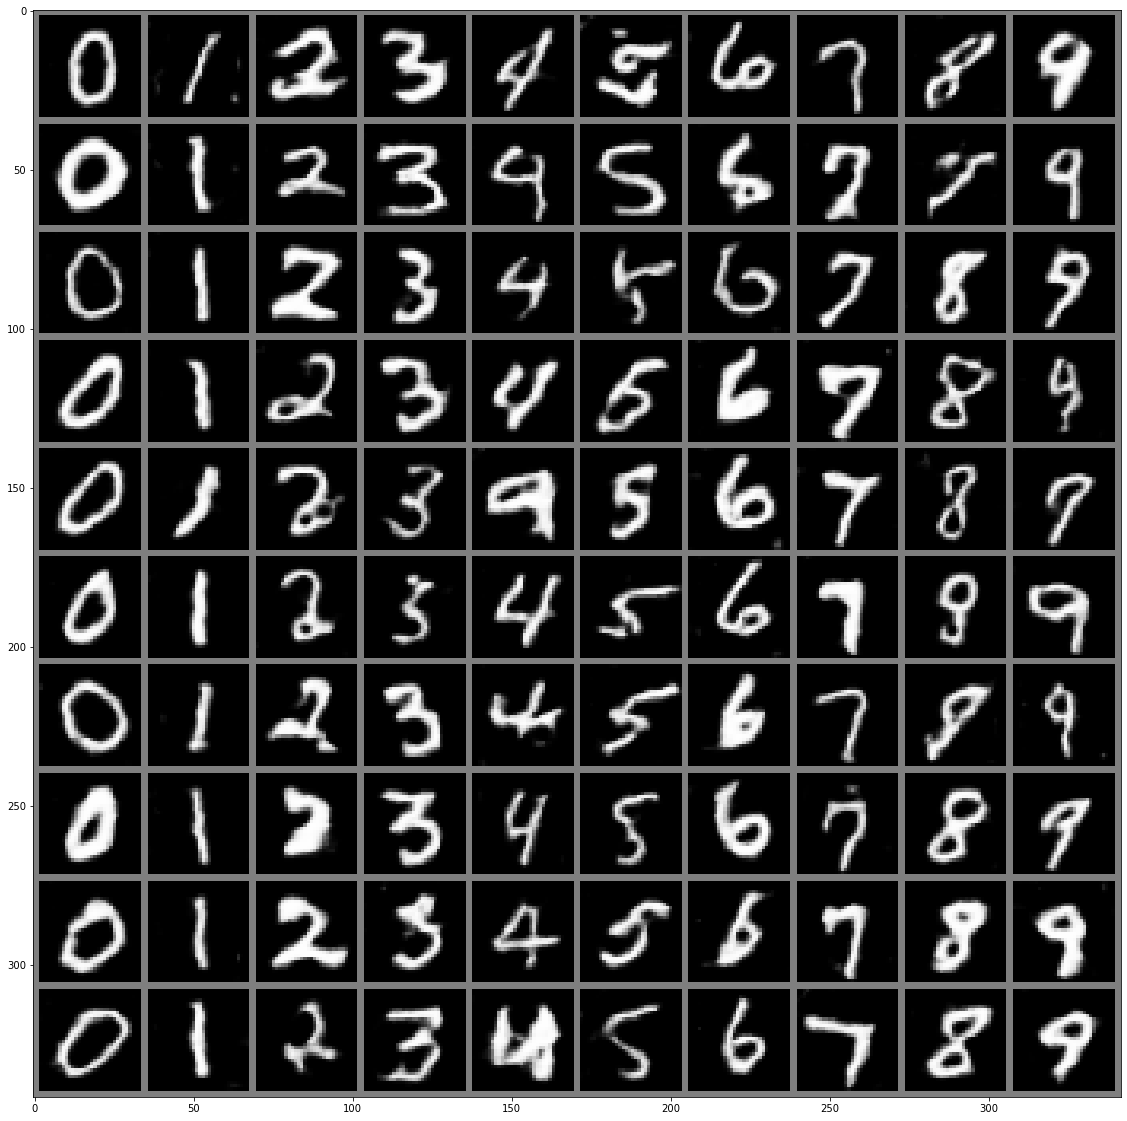

[Epoch 196/200] [Batch 372/468] [D loss: 0.255193, acc: 92%] [G loss: 1.887980]
[Epoch 197/200] [Batch 4/468] [D loss: 0.158783, acc: 94%] [G loss: 0.599902]
[Epoch 197/200] [Batch 104/468] [D loss: 0.084841, acc: 98%] [G loss: 1.049378]
[Epoch 197/200] [Batch 204/468] [D loss: 0.314537, acc: 94%] [G loss: 0.531681]
[Epoch 197/200] [Batch 304/468] [D loss: 0.084993, acc: 97%] [G loss: 0.850095]
[Epoch 197/200] [Batch 404/468] [D loss: 0.323862, acc: 97%] [G loss: 1.983437]
[Epoch 198/200] [Batch 36/468] [D loss: 0.158360, acc: 96%] [G loss: 1.354700]
[Epoch 198/200] [Batch 136/468] [D loss: 0.149121, acc: 99%] [G loss: 0.475275]
[Epoch 198/200] [Batch 236/468] [D loss: 0.127450, acc: 94%] [G loss: 1.752843]
[Epoch 198/200] [Batch 336/468] [D loss: 0.184229, acc: 98%] [G loss: 1.527169]
[Epoch 198/200] [Batch 436/468] [D loss: 0.127940, acc: 94%] [G loss: 0.633503]
[Epoch 199/200] [Batch 68/468] [D loss: 0.179160, acc: 96%] [G loss: 1.898226]
[Epoch 199/200] [Batch 168/468] [D loss: 0.1

In [13]:
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):

        batch_size = real_imgs.shape[0]

        # Configure input
        real_imgs = real_imgs.to(device)
        real_labels = labels.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        ones = torch.ones((real_imgs.size(0), 1)).to(device)
        zeros = torch.zeros((real_imgs.size(0), 1)).to(device)
        #### Implement Here ####
        ## z random sample
        ## label random sample 0-9 int
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, 100))).to(device)
        gen_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)
        
        optimizer_G.zero_grad()
        
        ## generator, discriminator output
        gen_images = G(z, gen_labels)
        fake_validity, fake_labels_pred = D(gen_images)
        
        ## g_loss = adversarial_loss + classification loss
        ce_loss = auxiliary_loss(fake_labels_pred, gen_labels)
        adv_loss = adversarial_loss(fake_validity, ones)
        g_loss = (adv_loss + ce_loss)/2
        
        g_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        #### Implement Here ####
        optimizer_D.zero_grad()
        
        # Loss for real images : adversarial_loss + classification loss
        real_validity, real_labels_pred = D(real_imgs)
        real_loss = (adversarial_loss(real_validity, ones) 
                     + auxiliary_loss(real_labels_pred, real_labels))/2
        
        # Loss for fake images : adversarial_loss + classification loss
        fake_validity, fake_labels_pred = D(gen_images.detach())
        fake_loss = (adversarial_loss(fake_validity, zeros) 
                     + auxiliary_loss(fake_labels_pred, gen_labels))/2
        
        # Total discriminator loss
        d_loss = (real_loss + fake_loss)/2
        d_loss.backward()
        optimizer_D.step()
        
        # Calculate discriminator accuracy
        pred = np.concatenate([real_labels_pred.detach().cpu().numpy(), fake_labels_pred.detach().cpu().numpy()], axis=0)
        gt = np.concatenate([labels.detach().cpu().numpy(), gen_labels.detach().cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        batches_done = epoch * len(dataloader) + i
        if batches_done % 100 == 0:     
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, 200, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
            
        if batches_done % 2000 == 0:
            sample_image(n_row=10, batches_done=batches_done)

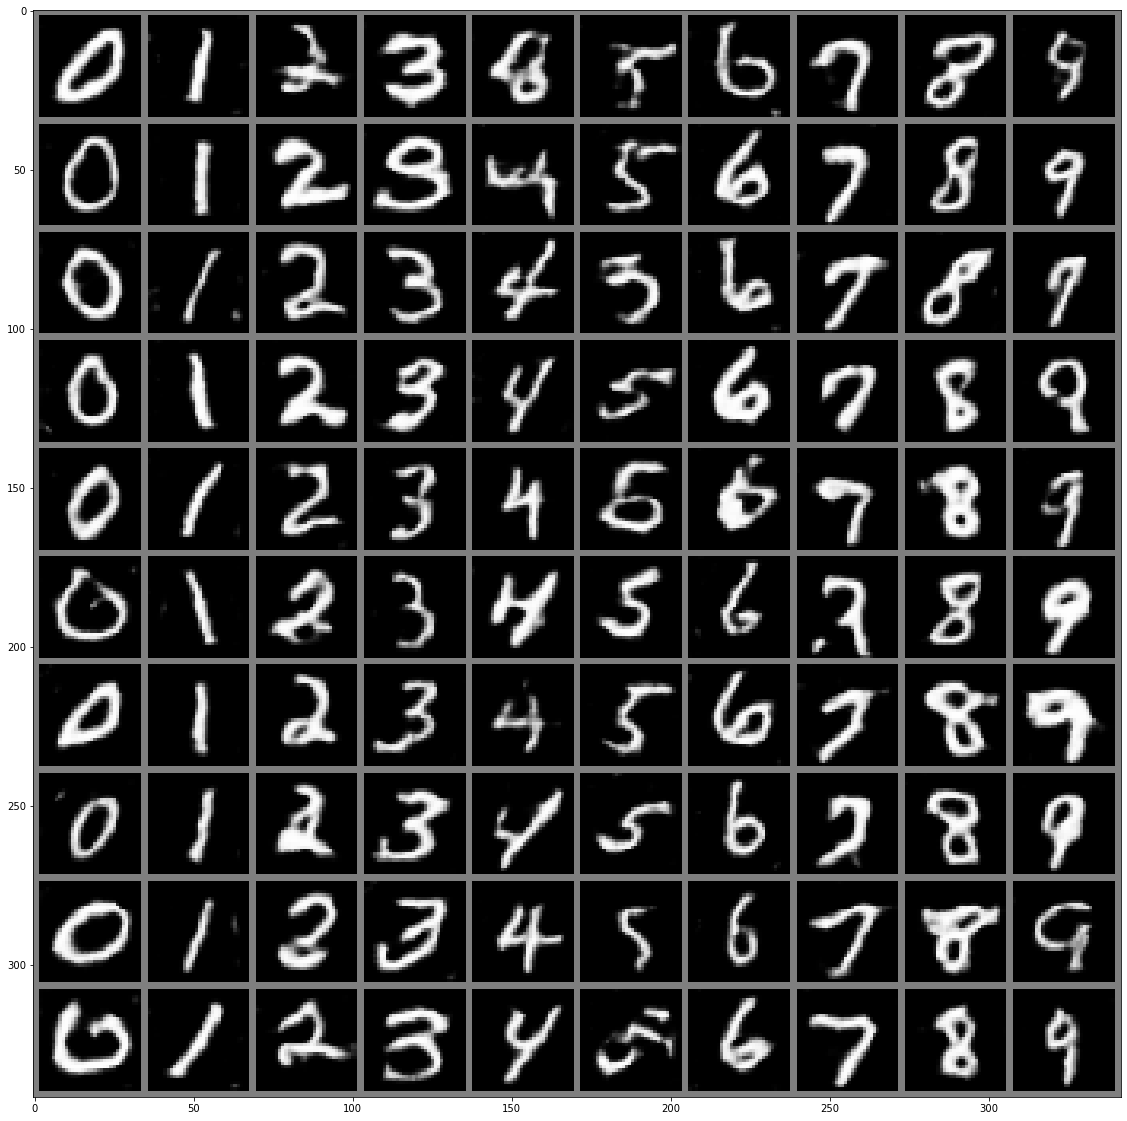

In [14]:
n_row = 10
z = torch.Tensor(np.random.normal(0, 1, (n_row ** 2, 100))).to(device)
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(n_row) for num in range(n_row)])
labels = torch.LongTensor(labels).to(device)
gen_imgs = G(z, labels)
imshow(torchvision.utils.make_grid(gen_imgs.cpu(), nrow=10))